In [1]:
import re, gensim, pickle, operator
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
df_competition = pd.read_csv(data_folder + 'competitors.csv')
df_category = pd.read_csv(data_folder + 'category_groups.csv')
df_investors = pd.read_csv(data_folder + 'investors.csv')

In [3]:
# 각 카테고리에 속하는 회사들의 펀딩 찍어보기
# 회사-카테고리 매핑
df_category = df_organizations[['uuid','category_list']]
print(df_category.head())

                                   uuid  \
0  1e4f199c-363b-451b-a164-f94571075ee5   
1  6681b1b0-0cea-6a4a-820d-60b15793fa66   
2  fd80725f-53fc-7009-9878-aeecf1e9ffbb   
3  10a3b2fd-b142-046b-7d8f-3b1aa4877aca   
4  1d410d6c-13ce-3d53-4e3f-be70dd5ffd54   

                                       category_list  
0  hardware|manufacturing|product design|semicond...  
1                                  hardware|software  
2  cloud computing|collaboration|developer tools|...  
3           hardware|information technology|software  
4               computer|government|service industry  


In [4]:
# 카테고리 리스트를 개별 카테고리로 나눠서 dataframe 으로 만든다
df2 = df_category['category_list'].str.split('|').apply(pd.Series, 1).stack()
df2.index = df2.index.droplevel(-1)
df2.name = 'category_list'
del df_category['category_list']
df_category = df_category.join(df2)
df_category.columns = ['uuid', 'category']
df_category.head()

uuid        category
0  1e4f199c-363b-451b-a164-f94571075ee5        hardware
0  1e4f199c-363b-451b-a164-f94571075ee5   manufacturing
0  1e4f199c-363b-451b-a164-f94571075ee5  product design
0  1e4f199c-363b-451b-a164-f94571075ee5   semiconductor
1  6681b1b0-0cea-6a4a-820d-60b15793fa66        hardware

In [5]:
# 각 회사의 투자 정보를 불러온다
df_funding = df_funding_rounds[['company_uuid', 'funding_round_uuid', 'announced_on', 'funding_round_type', 'funding_round_code']]
df_funding = df_funding.merge(df_category, left_on = 'company_uuid', right_on = 'uuid', how = 'inner')
df_funding = df_funding.drop('uuid', axis = 1)
df_funding.columns = ['company_uuid', 'funding_round_uuid', 'date',  'funding_round_type', 'funding_round_code', 'category']
df_funding['year-month'] = df_funding['date'].str[:7]
df_funding.head()

company_uuid                    funding_round_uuid  \
0  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
1  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
2  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
3  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
4  bb971d77-d7b8-a3c3-6925-c418077e5d3c  828b3a89-451e-cd0a-6d57-e31dd6a46124   

         date funding_round_type funding_round_code            category  \
0  2017-07-04            venture                  B  financial services   
1  2017-07-04            venture                  B             fintech   
2  2016-03-15            venture                  A  financial services   
3  2016-03-15            venture                  A             fintech   
4  2017-07-04            venture                  A  financial services   

  year-month  
0    2017-07  
1    2017-07  
2    2016-03  
3    2016-03  
4    2017-07

In [6]:
# 각 회사에 투자한 투자사들의 정보를 합친다
df_investment = pd.DataFrame(df_investments[['funding_round_uuid', 'investor_uuid']].groupby('funding_round_uuid')['investor_uuid'].apply(list)).reset_index()
df_funding = df_funding.merge(df_investment, on = 'funding_round_uuid')
df_funding.head()

company_uuid                    funding_round_uuid  \
0  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
1  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
2  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
3  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
4  bb971d77-d7b8-a3c3-6925-c418077e5d3c  828b3a89-451e-cd0a-6d57-e31dd6a46124   

         date funding_round_type funding_round_code            category  \
0  2017-07-04            venture                  B  financial services   
1  2017-07-04            venture                  B             fintech   
2  2016-03-15            venture                  A  financial services   
3  2016-03-15            venture                  A             fintech   
4  2017-07-04            venture                  A  financial services   

  year-month                                      investor_uuid  
0    2017-07  [1d91db1b-8aa3-3a98-aca1-b375b327235b, 307c51d...  
1    2017-07  [1d91db1b-8aa3-3a98-aca1-b375b327235b, 307c51d...  
2    2016-03  [307c51d2-b1f2-315a-9dcc-87643466bb87, 8ea4648...  
3    2016-03  [307c51d2-b1f2-315a-9dcc-87643466bb87, 8ea4648...  
4    2017-07  [4ede174d-3254-8602-e977-d9c0bfe34433, 94c2fe4...

In [7]:
# 가장 많이 사용된 탑 10 카테고리
df_category_count = pd.read_csv('../data/others/category_count.csv')
print(df_category_count.head(20))

# # csv 파일이 없을 시 다음의 코드로 저장할 수 있다
# df_funding.groupby('category').size().rename('count').reset_index().sort_values('count', ascending = False).to_csv('../data/others/category_count.csv', index = False)

                  category  count
0                 software  15892
1                   mobile  12275
2              health care  10972
3      enterprise software   9600
4               e-commerce   9173
5                 internet   8314
6            biotechnology   7931
7   information technology   6659
8                     saas   6240
9                analytics   5959
10             advertising   4872
11           manufacturing   4829
12                 medical   4767
13                    apps   4493
14            social media   4357
15               education   3717
16                 finance   3650
17                big data   3482
18                 fintech   3348
19                hardware   3257


In [45]:
# crunchbase 의 카테고리 정보로 빠른 투자자들 찾기
def get_early_investors_by_categories(categories, investment_criteria = ['seed'], early_investment_percent = 10, top_k = 30,verbose = True, norm = False):
    color1 = 'blue'
    if type(categories) == str:
        categories = [categories]

    # 펀딩 정보중 겹치는 데이터를 뺀다
    df = df_funding[df_funding['category'].isin(categories)].drop_duplicates('funding_round_uuid')

    if 'seed' in investment_criteria:
        df = pd.concat([df[df['funding_round_type'] == 'seed'],
                                   df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    else:
        df = pd.concat([df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    

#     print df.shape
    if df.shape[0] == 0:
        if verbose:
            print 'not found in categories'
        return
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        valid_categories = list(set(list(df_funding['category'].unique())).intersection(set(categories)))
        print('Relevant categories: {}'.format(valid_categories))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    try:
        df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
        df2 = df['investor_uuid'].apply(pd.Series, 1).stack()
    except Exception as e:
        return None
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    df2.index = df2.index.droplevel(-1)
    df2.name = 'investor_uuid'
    del df['investor_uuid']
    df = df.join(df2)

    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()
    df3 = df.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    
    score_norm = df.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score_norm = score_norm.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score_norm = score_norm.merge(df3, on = 'investor_uuid')
    
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    if norm:
#         score = score[score['count'] > 10]
        score['count'] /= np.sqrt(score_norm['count'])
        score = score.sort_values(['count'], ascending = False)
        return score
    else:
        return score

In [46]:
# company description 에 있는 단어 기반으로 해당 단어에 관련된 회사들에 빨리 투자한 투자자 찾기
def get_early_investors_by_words(words, investment_criteria = ['seed'], early_investment_percent = 10, top_k = 30, expand = False, verbose = True):
    color1 = 'blue'
    
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

    # 연관 단어도 같이 보고 싶을 시 비슷한 단어를 검색에 포함시킨다
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            if word not in model: continue
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    
    # 해당 단어가 있는 회사들을 모은다
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    # 펀딩 정보중 필요한 회사들만 취하고, 겹치는 데이터를 뺀다
    df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')    
    if 'seed' in investment_criteria:
        df = pd.concat([df[df['funding_round_type'] == 'seed'],
                                   df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    else:
        df = pd.concat([df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    
    if df.shape[0] < 10:
        return None
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        print('Keywords: {}'.format(final_words))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:    
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    try:
        df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
    except Exception as e:
        print 'none'
        return None
        
        
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:        
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    return score

In [47]:
def get_early_investors(words, investment_criteria = ['seed'], early_investment_percent = 10, top_k = 30):
    get_early_investors_by_categories(words, investment_criteria, early_investment_percent, top_k)
    get_early_investors_by_words(words, investment_criteria, early_investment_percent, top_k)

In [67]:
# 모든 카테고리에 대해서 빠른 회사들 찾아서 저장
# 모든 단어에 대해서 빠른 회사들 찾아서 저장
category_min = 10
word_min = 10
save_category = True
save_word = False
investment_criteria = ['seed']
# investment_criteria = ['seed', 'A', 'B', 'C', 'D', 'E']

if save_category:
    df_category_count = pd.read_csv('../data/others/category_count.csv')
    category2investor = {}
    investor2category = {}

    df_category_count = df_category_count[df_category_count['count'] >= category_min]
    categories = df_category_count['category'].values
    for index, category in enumerate(categories):
        if index % (len(categories) // 10) == 0:
            print index, len(categories)
        if type(category) != str: continue
        score = get_early_investors_by_categories(category, investment_criteria = investment_criteria, \
                                                  early_investment_percent = 10, top_k = 30, verbose = False, norm = False)
        if score is None:
            continue
#         print score['investor_name'].head(10)
        investors = score['investor_uuid'].values
        category2investor[category] = investors
        for investor in investors:
            if investor not in investor2category:
                investor2category[investor] = []
            investor2category[investor].append(category)

    with open('../data/others/category2early_investor_{}.pickle'.format('_'.join(investment_criteria)), 'w') as f:
        pickle.dump(category2investor, f)
    with open('../data/others/early_investor2category_{}.pickle'.format('_'.join(investment_criteria)), 'w') as f:
        pickle.dump(investor2category, f)

    for category, investors in category2investor.items():
        print category
        print investors
        break
    
if save_word:
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'company2word' not in globals():
        print('loading company2word')
        global company2word
        company2word = pickle.load(open(util_folder + 'company2word.pickle'))

    word2investor = {}
    investor2word = {}

    words = word2company.keys()
    for index, word in enumerate(words):
        if index % (len(words) // 100) == 0:
            print index, len(words)
        if len(word2company[word]) < word_min: continue            
            
        score = get_early_investors_by_words([word], early_investment_percent = 10, top_k = 30, verbose = False)
        if score is None: continue
        investors = score['investor_uuid'].values
        word2investor[word] = investors
        for investor in investors:
            if investor not in investor2word:
                investor2word[investor] = []
            investor2word[investor].append(word)
    with open('../data/others/word2investor.pickle', 'w') as f:
        pickle.dump(word2investor, f)
    with open('../data/others/investor2word.pickle', 'w') as f:
        pickle.dump(investor2word, f)

    for word, investors in word2investor.items():
        print word
        print investors
        break

0 651
65 651
130 651
195 651
260 651
325 651
390 651
455 651
520 651
585 651
650 651
veterinary
['2ca323e0-fbcc-f738-a7a1-86b6322788bd'
 '95a40ea4-b0ae-203f-d89b-feeee84e99ae'
 'c7bf91cb-893a-d154-6637-1a28cb0ed14f']


In [68]:
save = True
begin_from = 0 # 처음부터 학습하고 싶으면 0 으로 설정
investment_criteria = ['seed']
# investment_criteria = ['seed', 'A', 'B', 'C', 'D', 'E']
norm = False

if save:
    category_weight = df_category_count.set_index('category')['count'].to_dict()
    if norm:
        category2investor = pickle.load(open('../data/others/category2early_investor_norm_{}.pickle'.\
                                            format('_'.join(investment_criteria))))
    else:
        category2investor = pickle.load(open('../data/others/category2early_investor_{}.pickle'.\
                                            format('_'.join(investment_criteria))))


#     weight_schemes = ['log', 'sqrt', 'simple']
    weight_schemes = ['sqrt']
    for weight_scheme in weight_schemes:
#         for index, _category in enumerate(df_category_count['category']):
        for index, _category in enumerate(['all']):
            if index < begin_from: continue
            score = {}
            for category, investors in category2investor.items():
                if category == _category: continue
                for investor in investors:
                    score[investor] = 0
            all_investors = score.keys()
            num_max = len(all_investors)

            print 'target category', _category, index, len(category2investor.keys())
            weight_sum = 0
            for category, investors in category2investor.items():
                if category == _category: continue
                if weight_scheme == 'simple': weight_sum += 1
                if weight_scheme == 'sqrt': weight_sum += np.sqrt(category_weight[category])
                if weight_scheme == 'log': weight_sum += np.log(category_weight[category])

                default_rank = (num_max + len(investors)) / 2.0
                default_rank = 1.0 / default_rank

                for rank, investor in enumerate(investors):
                    rank = 1.0 / (rank + 1)
                    if weight_scheme == 'simple': score[investor] += rank
                    if weight_scheme == 'sqrt': score[investor] += (np.sqrt(category_weight[category]) * rank)
                    if weight_scheme == 'log': score[investor] += (np.log(category_weight[category]) * rank)

                for investor in all_investors:
                    if investor not in investors:
                        if weight_scheme == 'simple': score[investor] += default_rank
                        if weight_scheme == 'sqrt': score[investor] += (np.sqrt(category_weight[category]) * default_rank)
                        if weight_scheme == 'log': score[investor] += (np.log(category_weight[category]) * default_rank)

            for investor in all_investors:
                score[investor] = weight_sum / score[investor]

            try:
                if norm:
                    with open('../data/others/early_{}_investor_{}_harmonic_rank_for_{}_norm.pickle'.format('_'.join(investment_criteria), weight_scheme, _category), 'w') as f:
                        pickle.dump(score, f)
                else:
                    with open('../data/others/early_{}_investor_{}_harmonic_rank_for_{}.pickle'.format('_'.join(investment_criteria), weight_scheme, _category), 'w') as f:
                        pickle.dump(score, f)                    
            except Exception as e:
                print e

target category all 0 545


In [71]:
with open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all.pickle') as f:
    early = pickle.load(f)
early = sorted(early.items(), key = operator.itemgetter(1))
for i, (uuid, score) in enumerate(early[:30]):
    print i + 1, df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], score


 1 Y Combinator 3.68178901392
2 SV Angel 11.6198919841
3 High-Tech Gruenderfonds 13.58665782
4 Techstars 13.8337990529
5 ATDC 14.1599282916
6 First Round 14.5960830806
7 500 Startups 20.5127053149
8 Seedcamp 20.5546025193
9 JumpStart Inc. 21.6482020276
10 Ben Franklin Technology Partners of Northeastern Pennsylvania 22.5234578285
11 BioAdvance 25.3499418748
12 Kima Ventures 27.3194549289
13 Dreamit 28.0970457368
14 Fabrice Grinda 32.3707391057
15 Start-Up Chile 32.9841409658
16 Northstar Ventures 33.9967956815
17 Founder Collective 35.9269902711
18 AlphaLab 38.7734679171
19 CIT GAP Funds 39.1264733904
20 HV Holtzbrinck Ventures 40.0684188295
21 SOSV 42.1428482485
22 LocalGlobe 46.2019373865
23 True Ventures 47.6723524284
24 MaRS Investment Accelerator Fund 48.1581930461
25 FLOODGATE 50.6527326121
26 Innovation Works 53.8706022887
27 Felicis Ventures 55.2723899041
28 Lerer Hippeau Ventures 69.3804518011
29 LaunchBox Digital 71.0198886366
30 LaunchCapital 73.083285688


In [72]:
with open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all_norm.pickle') as f:
    early = pickle.load(f)
early = sorted(early.items(), key = operator.itemgetter(1))
for i, (uuid, score) in enumerate(early[:30]):
    print i + 1, df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], scofe


1 Y Combinator
2 Techstars
3 ATDC
4 SV Angel
5 High-Tech Gruenderfonds
6 500 Startups
7 BioAdvance
8 First Round
9 Founder Collective
10 Ben Franklin Technology Partners of Northeastern Pennsylvania
11 HV Holtzbrinck Ventures
12 Northstar Ventures
13 JumpStart Inc.
14 Seedcamp
15 Dreamit
16 Fabrice Grinda
17 Kima Ventures
18 Felicis Ventures
19 AlphaLab
20 CIT GAP Funds
21 SOSV
22 LocalGlobe
23 Innovation Works
24 True Ventures
25 Start-Up Chile
26 General Catalyst
27 LaunchCapital
28 Khosla Ventures
29 Enterprise Ireland
30 Ronald Conway


In [13]:
# 단어가 주어졌을때 연관 단어를 배출하는 helper function
def related_words(words):
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')
        
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if word not in model: continue
        _words = model.most_similar(word)
        _words = [str(_word) for _word, sim in _words if _word not in words]
        final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    print final_words
    return final_words

In [15]:
THRESHOLD = 0.7
TOP_K = 20
# # TOP VC 들에 대해서 그들이 빨리 투자하는 카테고리, 단어 클러스터 찾기
category2investor = pickle.load(open('../data/others/category2investor.pickle'))
investor2category = pickle.load(open('../data/others/investor2category.pickle'))

word2investor = pickle.load(open('../data/others/word2investor.pickle'))
investor2word = pickle.load(open('../data/others/investor2word.pickle'))

# central = pickle.load(open(util_folder + 'investor_centrality_degree.pickle'))
central = pickle.load(open(util_folder + 'investor_centrality_between_one_over_k.pickle'))
if 'model' not in globals():
    print('loading word2vec model')
    global model
    model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

category_distribution = {}

top20 = [uuid for uuid, value in central[:TOP_K]]
for i, uuid in enumerate(top20):
    print df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], central[i][1]
    categories = investor2category.get(uuid, [])
    words = investor2word.get(uuid, [])
    print "Num Categories:",len(categories), "Num Words:", len(words)
    print categories
    for category in categories:
        category_distribution[category] = category_distribution.get(category, 0) + 1

    word_list = words
    groups = {0 : [word_list[0]]}
    next_index = 1
    for word1 in word_list[1:]:
        found = False
        for index, group in groups.items():
            for word2 in group:
                if model.similarity(word1, word2) > THRESHOLD:
                    found = True
                    _index = index
                    break
            if found:
                break
        if found:
            groups[_index].append(word1)
        else:
            groups[next_index] = [word1]
            next_index += 1
    sorted_groups = sorted(groups.items(), key = lambda i: len(i[1]))
    sorted_groups.reverse()
    for index in range(min(next_index, 15)):
        if len(sorted_groups[index][1]) > 1:
            for word in sorted_groups[index][1]:
                print word,
            print
            print
    print "*"*20
print
category_distribution = sorted(category_distribution.items(), key = lambda x: x[1], reverse = True)
for word, count in category_distribution:
    print word, count, '/' , TOP_K
    

loading word2vec model
SV Angel 0.232518306176
Num Categories: 83 Num Words: 1365
['software', 'mobile', 'e-commerce', 'internet', 'saas', 'analytics', 'advertising', 'apps', 'social media', 'education', 'finance', 'big data', 'fintech', 'financial services', 'cloud computing', 'retail', 'marketplace', 'internet of things', 'mobile apps', 'real estate', 'search engine', 'machine learning', 'artificial intelligence', 'music', 'payments', 'shopping', 'gaming', 'ios', 'sports', 'publishing', 'developer tools', 'edtech', 'online portals', 'recruiting', 'food and beverage', 'events', 'fitness', 'photography', 'marketing automation', 'brand marketing', 'advertising platforms', 'wearables', 'local', 'mobile payments', 'e-learning', 'crowdsourcing', 'social media marketing', 'developer apis', 'data visualization', 'social', 'voip', 'audio', 'personal finance', 'web browsers', 'art', 'accounting', 'e-commerce platforms', 'bitcoin', 'email marketing', 'personal health', 'seo', 'subscription serv

redwood_city menlo_park santa_clara billerica_massachusetts pleasanton_california san_diego sunnyvale_california san_mateo palo_alto mountain_view san_francisco new_york los_angeles seattle hyderabad_india

voip wireless broadband wireless_networks networks ethernet broadband_internet connectivity wi_fi high_speed sonet ip_pbx optical_transport network carrier_grade

desktop web_browser pc tablet smartphone computer mac device tablets handhelds personal_computers android computers mobile_phones mobile_devices

can_easily can are_able lets will would allow may allowing ll helps enable enabling allows

family_offices broker_dealers financial_institutions corporations major_corporations companies banks enterprises businesses firms large_enterprises smes institutions smbs

autoimmune obesity cell_signaling acute chronic_inflammatory characterizing heart_failure diseases modulate cataract_surgery therapies

get give receive find offer obtain provide giving gives getting

organs human_body p

andy alexander aaron zhang edward julie paul jason mason larry nick rui john randy schwartz ben greg michael chen david

bain_capital andreessen_horowitz charles_river organization_sequoia sequoia_capital tenaya_capital norwest_venture khosla_ventures accel_partners dag_ventures venture_capitalist redpoint_ventures innovation_endeavors carmel_ventures sequoia greylock

enables enables_its allow allowing letting helps enables_users enables_individuals enable empowers enabling_them enabling allows

wdm carrier_ethernet carrier_class triple_play ethernet switching fiber_optic converged base_stations ethernet_switch broadband_wireless wireless_communications

video videos pictures_videos content music_videos photos movies streaming music audio pictures

brands retailers manufacturers merchants stores store dealers suppliers merchant wholesalers

iphone_app app smartphone_app ipad_app mobile_app application android_app system android ios

targeted_attacks attacks malware threats zero_day at

wireless broadband wimax wireless_broadband wired_wireless broadband_access cellular telecommunication broadband_networks mobile_wimax lte ethernet switching transceiver connectivity telecom wireless_networking wi_fi high_speed base_stations telecommunications gsm_gprs routers wireless_communications

redwood_city santa_monica san_jose austin_texas emeryville_california richardson_texas mumbai_india boston_mass san_diego sunnyvale_california munich_germany palo_alto guangzhou_china madison_wisconsin paris_france mountain_view san_francisco new_york bangalore_india los_angeles dulles_virginia pittsburgh_pennsylvania dubai_uae

desktop web_browser tablet smartphone smartphones tablet_smartphone touch_screen ipad pc_mac device windows smart_phone ios_android tablets personal_computers mobiles android mobile_device browser ios computers mobile_phones mobile_devices

combines leverages uses utilises by_leveraging leveraging incorporates leverage by_combining utilizes integrates utilizing us

you your someone something

discover discover_new explore

neural_networks deep_learning machine_learning

amazing awesome great

once before

comments comment

simple easy

app mobile_app

app_store google_play

open_api api

therapists doctors

instagram facebook

hubspot sendgrid

can will

********************
Draper Fisher Jurvetson (DFJ) 0.0296543473414
Num Categories: 167 Num Words: 2730
['software', 'mobile', 'health care', 'enterprise software', 'e-commerce', 'internet', 'biotechnology', 'information technology', 'saas', 'analytics', 'advertising', 'manufacturing', 'medical', 'apps', 'social media', 'finance', 'big data', 'fintech', 'hardware', 'financial services', 'medical device', 'security', 'cloud computing', 'video', 'retail', 'telecommunications', 'wireless', 'pharmaceutical', 'electronics', 'marketing', 'marketplace', 'digital media', 'energy', 'health diagnostics', 'internet of things', 'mobile apps', 'real estate', 'search engine', 'semiconductor', 'automotive', 'mac

connects empowers allows

our their

videos photos

audience target_audience

app mobile_app

creating building

beautiful colorful

advanced_analytics machine_learning

collaborate connect

athletes coaches

payment_options payment_methods

country world

track measure

get find

********************

big data 14 / 20
apps 14 / 20
social media 13 / 20
machine learning 13 / 20
mobile apps 13 / 20
fintech 13 / 20
saas 13 / 20
advertising 12 / 20
e-commerce 12 / 20
mobile 12 / 20
fashion 11 / 20
analytics 11 / 20
payments 11 / 20
artificial intelligence 11 / 20
search engine 11 / 20
retail 10 / 20
finance 10 / 20
internet 10 / 20
robotics 10 / 20
ios 10 / 20
software 10 / 20
health care 10 / 20
education 10 / 20
cloud computing 10 / 20
financial services 9 / 20
information technology 9 / 20
sports 9 / 20
travel 9 / 20
gaming 9 / 20
developer apis 9 / 20
fitness 9 / 20
enterprise software 9 / 20
drones 9 / 20
bitcoin 9 / 20
internet of things 9 / 20
collaboration 9 / 20
publishing 9 / 20


not found in categories
Keywords: ['drone']
Early 10 percent investors before 2014-05-01 
(12 early fundings out of 120 total)
    count                  investor_name     date
0       3                    SK Ventures  2012-11
1       2                  True Ventures  2012-11
2       2                 Start-Up Chile  2012-11
3       2     Oreilly AlphaTech Ventures  2012-11
4       1              Qualcomm Ventures  2013-05
5       1                   Bee Partners  2013-05
6       1          Alchemist Accelerator  2013-07
7       1                  Amino Capital  2013-05
8       1            Andreessen Horowitz  2013-11
9       1                    Legend Star  2013-11
10      1                      Ooga Labs  2013-09
11      1                  Foundry Group  2013-09
12      1                       AngelPad  2013-05
13      1                  SierraMaya360  2013-05
14      1                     Comet Labs  2013-11
15      1             Christopher Michel  2012-11
16      1              

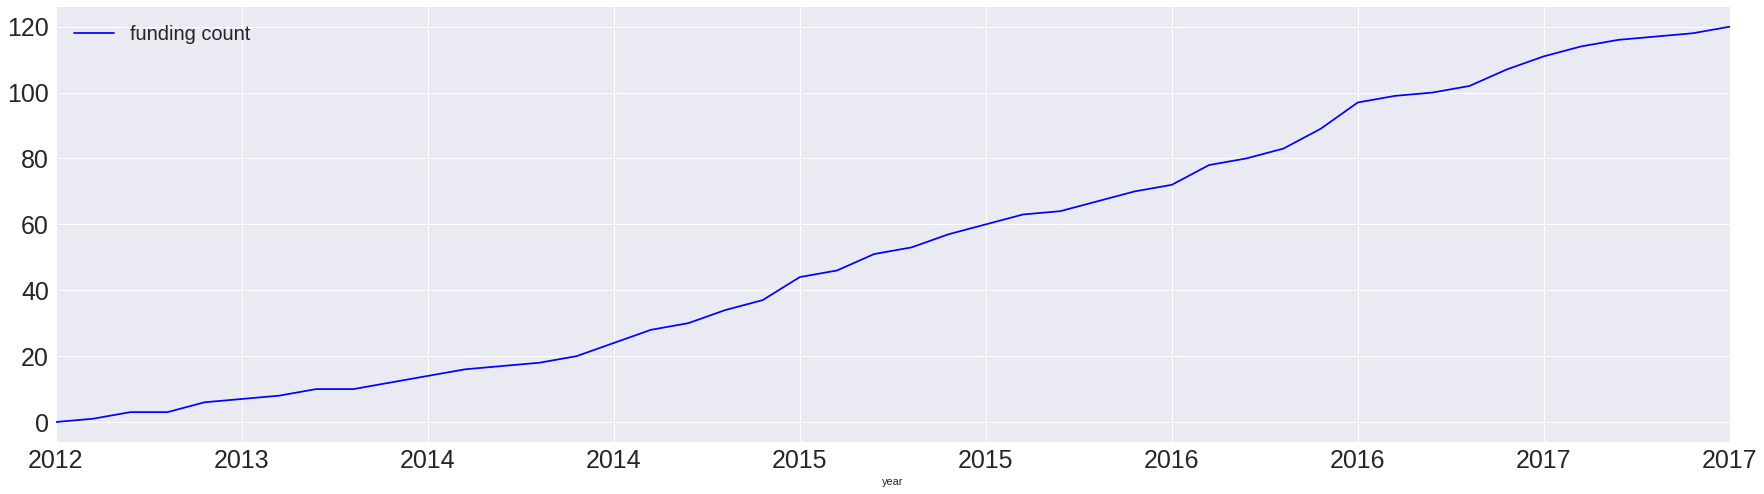

In [62]:
# get_early_investors('drone', investment_criteria=['seed'], early_investment_percent = 10, top_k = 30)
get_early_investors('drone', investment_criteria=['seed', 'A', 'B', 'C', 'D'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['robotics']
Early 10 percent investors before 2012-12-11 
(36 early fundings out of 368 total)
    count               investor_name     date
0       3        RSV Venture Partners  2012-03
1       2     High-Tech Gruenderfonds  2012-11
2       2            Innovation Works  2005-06
3       2                        SOSV  2011-11
4       2                   Techstars  2011-11
5       1                 SK Ventures  2012-09
6       1           Charlie Songhurst  2011-11
7       1          Iron Yard Ventures  2012-08
8       1         Skolkovo Foundation  2012-02
9       1                   Techammer  2012-11
10      1               Mike McCauley  2012-12
11      1                Papillon ZAO  2012-02
12      1                Daniel Debow  2012-12
13      1            Grishin Robotics  2012-09
14      1      MBG Baden Wuerttemberg  2012-11
15      1                     Eclipse  2012-08
16      1                Dylan Taylor  2009-01
17      1          Greycroft Partners

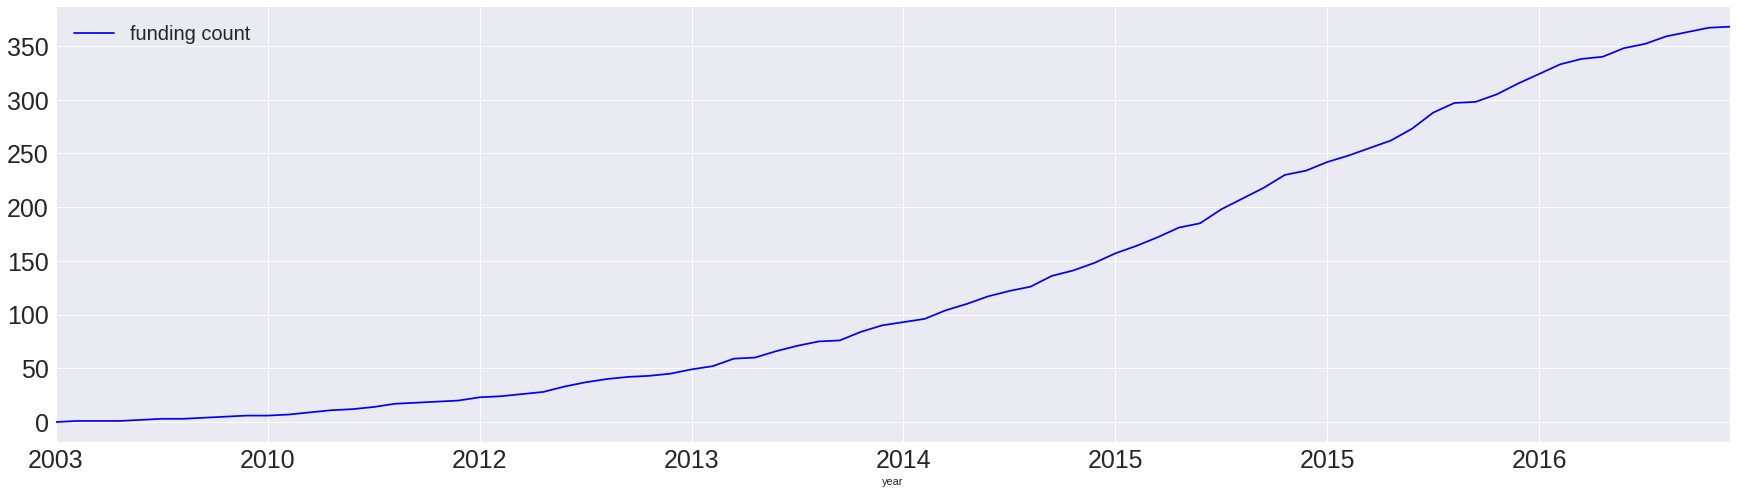

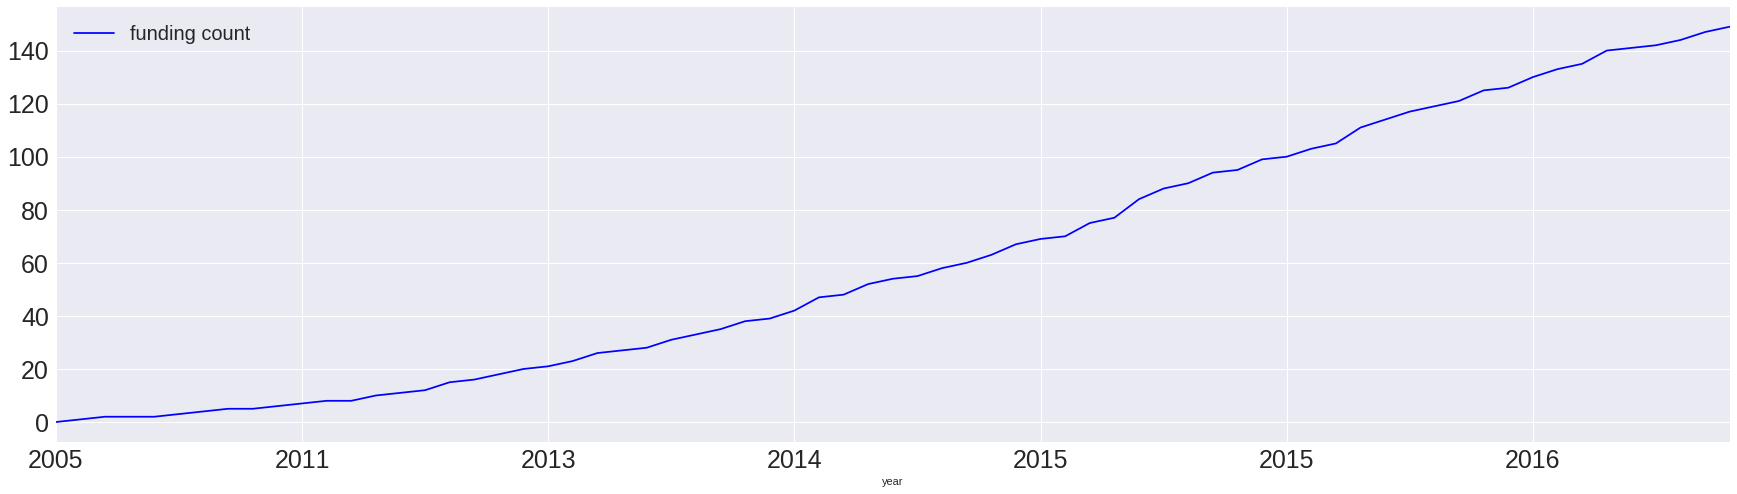

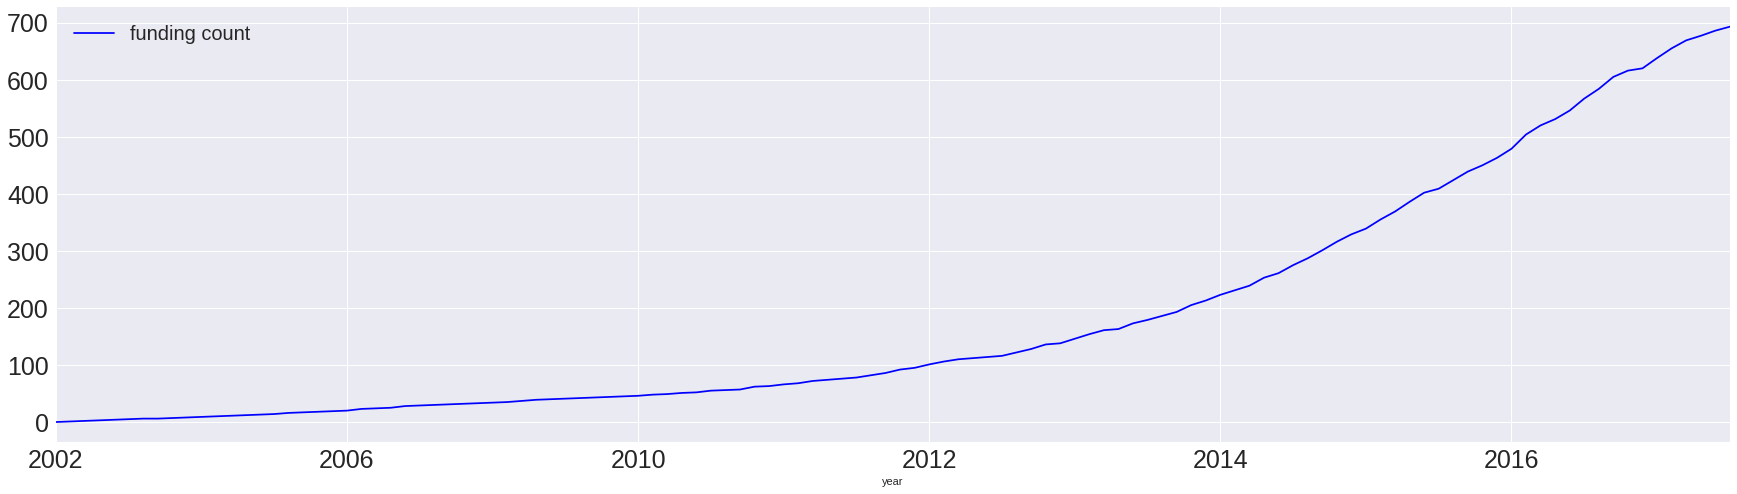

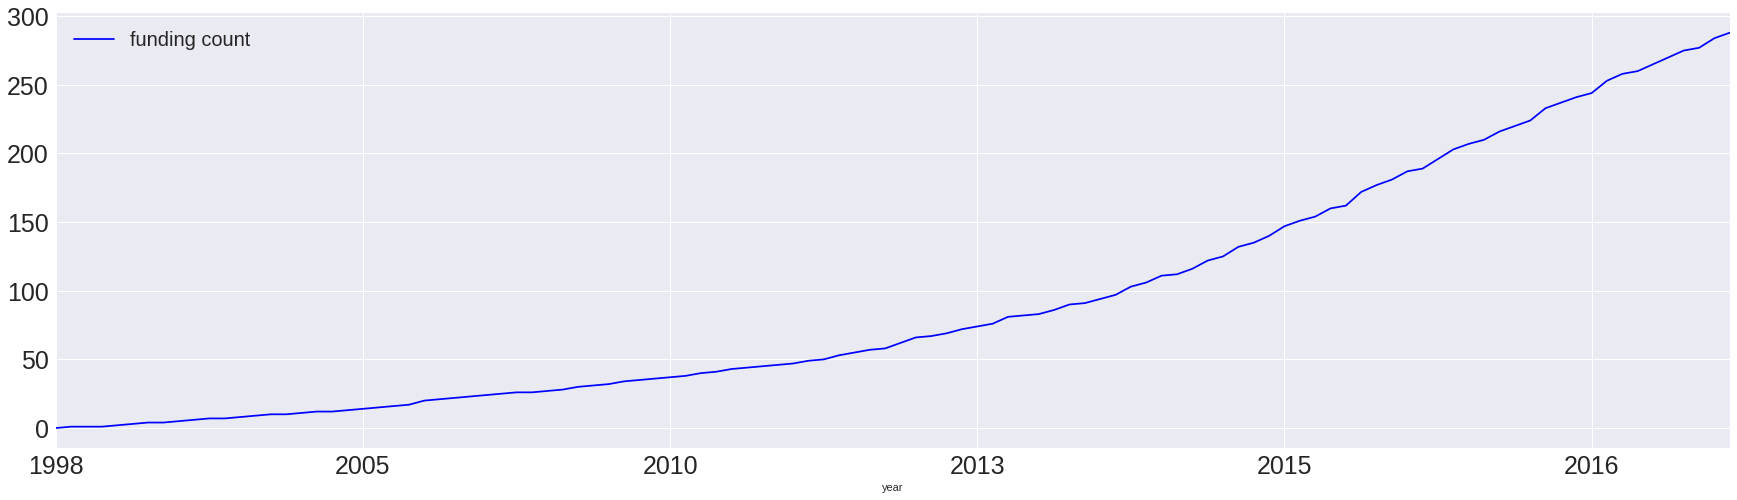

In [63]:
get_early_investors(['robotics'], early_investment_percent = 10, top_k = 30)
get_early_investors(['robotics'],investment_criteria=['seed', 'A', 'B', 'C', 'D'], early_investment_percent = 10, top_k = 30)

In [18]:
related_words(['robotics'])

['synthetic_biology', 'computer_vision', 'unmanned_systems', 'robotics', 'machine_vision', 'robots', 'mechatronic', 'mechatronics', 'industrial_robots', 'robotic', 'robotic_systems']


['synthetic_biology',
 'computer_vision',
 'unmanned_systems',
 'robotics',
 'machine_vision',
 'robots',
 'mechatronic',
 'mechatronics',
 'industrial_robots',
 'robotic',
 'robotic_systems']

['synthetic_biology', 'computer_vision', 'unmanned_systems', 'robotics', 'machine_vision', 'robots', 'mechatronic', 'mechatronics', 'industrial_robots', 'robotic', 'robotic_systems']
(1018, 6)
Relevant categories: ['robotics']
Early 10 percent investors before 2012-04-19 
(101 early fundings out of 1018 total)
    count                     investor_name     date
0       4                          3i Group  2002-04
1       4                       Giant Eagle  2005-07
2       3                   Fenway Partners  2001-10
3       3                Techstars Ventures  2010-10
4       3              RSV Venture Partners  2012-03
5       3               iD Ventures America  2001-10
6       3                  KfW Bankengruppe  2005-05
7       3       National Science Foundation  2010-04
8       3                         Techstars  2010-10
9       3                              SOSV  2011-11
10      3            First Albany Companies  2001-10
11      3                 Bezos Expeditions  2008-08

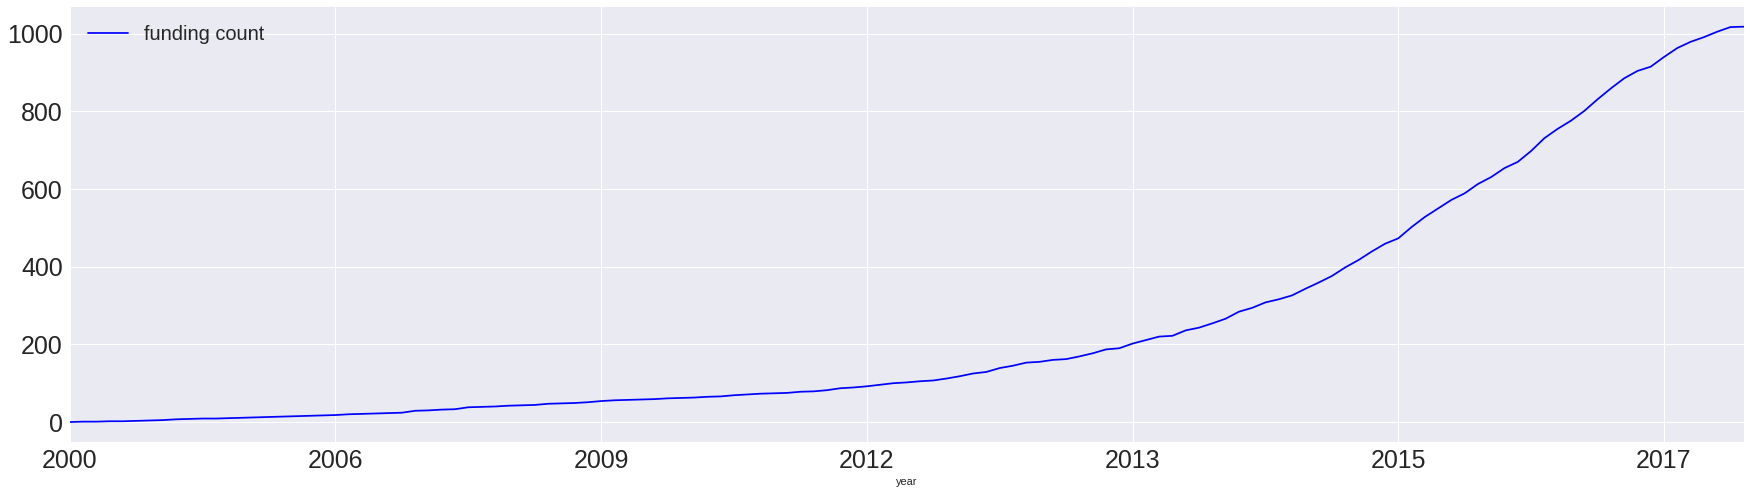

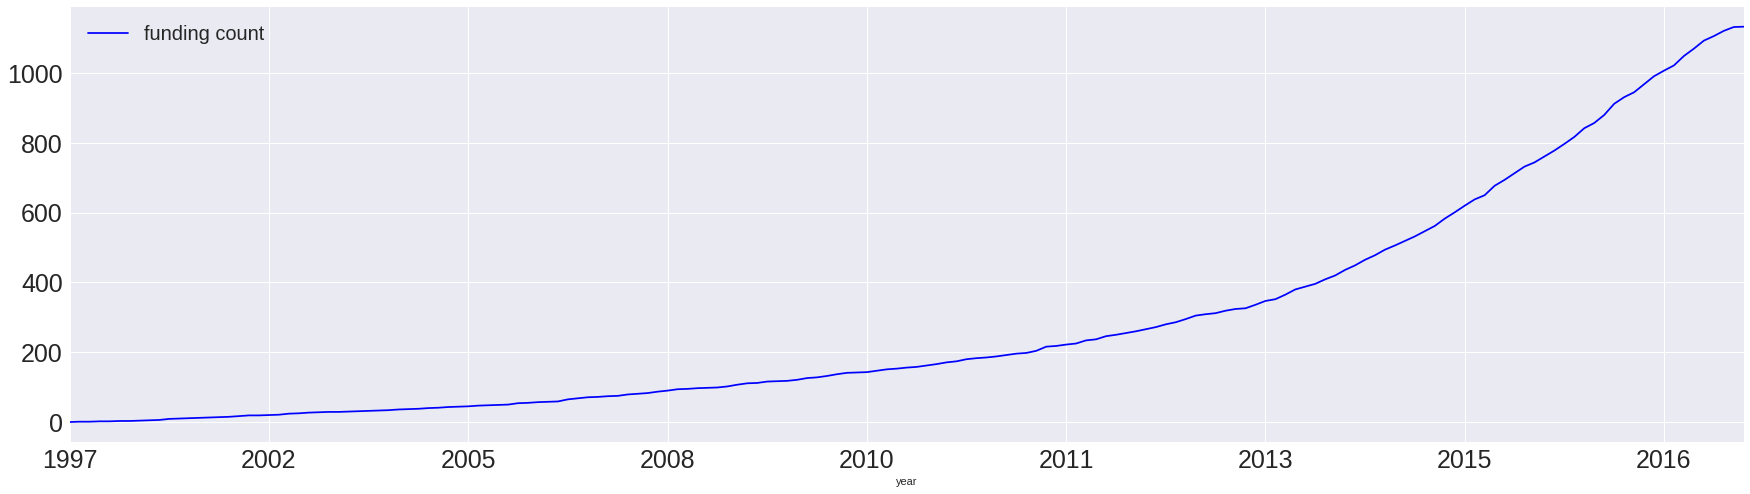

In [19]:
get_early_investors(related_words(['robotics']), early_investment_percent = 10, top_k = 30)

(12275, 6)
Relevant categories: ['mobile']
Early 10 percent investors before 2007-01-01 
(1227 early fundings out of 12275 total)
    count                                  investor_name     date
0      47                                  Intel Capital  1999-03
1      39                                Sequoia Capital  1999-10
2      35                  Draper Fisher Jurvetson (DFJ)  2000-03
3      32                      New Enterprise Associates  1998-03
4      30                                       Redpoint  2000-12
5      27                                       3i Group  2000-09
6      27                      Bessemer Venture Partners  2000-05
7      23                                  Mayfield Fund  2000-03
8      23                                  Apax Partners  2000-11
9      23                   U.S. Venture Partners (USVP)  2000-01
10     22                                 Accel Partners  1996-12
11     20             Motorola Solutions Venture Capital  2003-04
12     19   

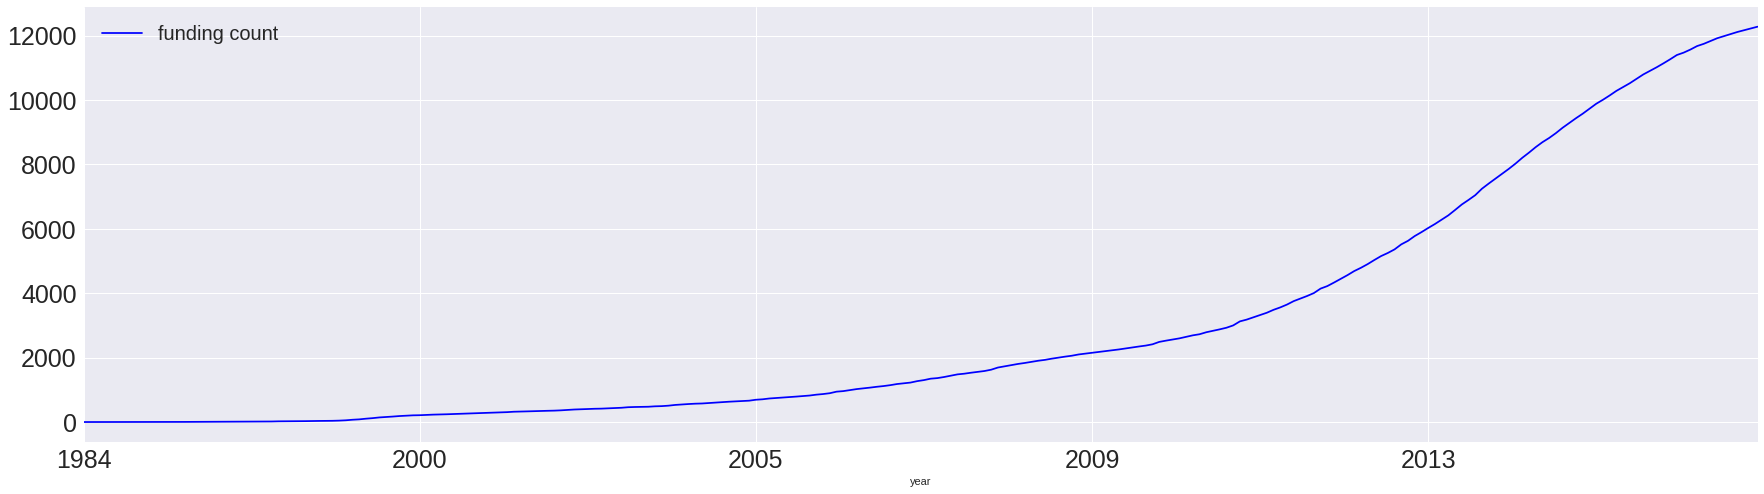

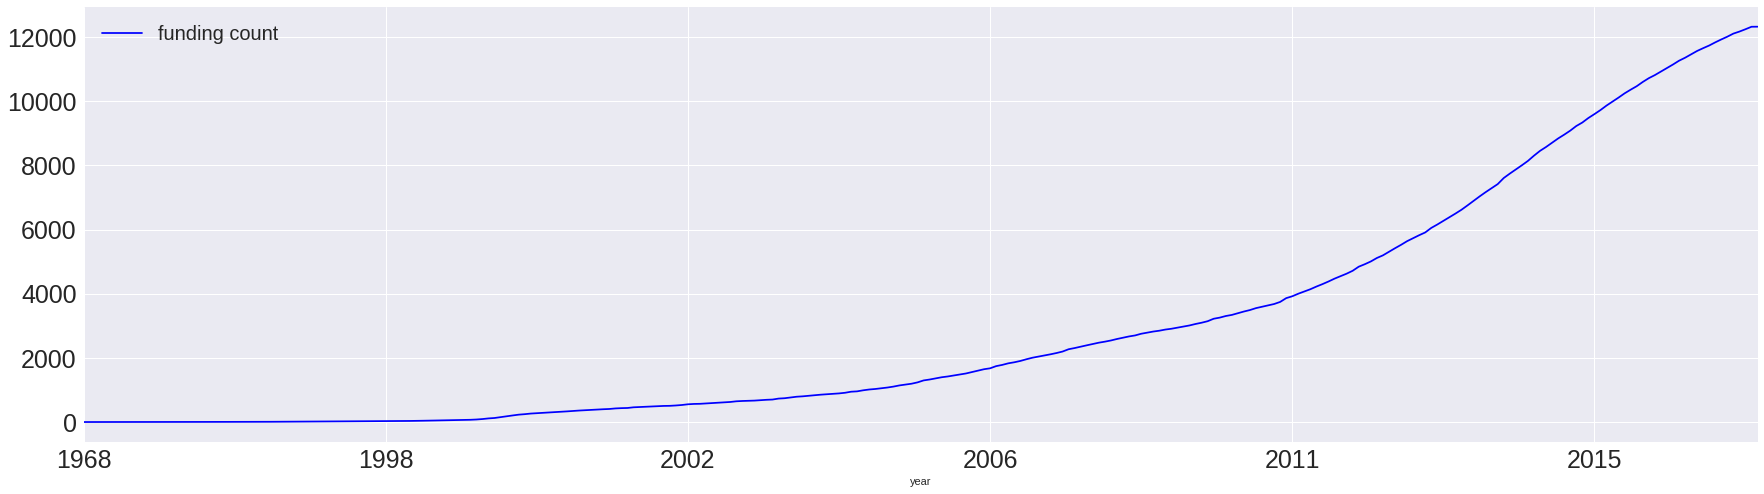

In [20]:
get_early_investors('mobile', early_investment_percent = 10, top_k = 30)

Relevant categories: ['fintech']
Early 10 percent investors before 2011-10-17 
(108 early fundings out of 1083 total)
    count               investor_name     date
0      24                   Techstars  2007-08
1       4          Techstars Ventures  2007-08
2       4                Y Combinator  2010-06
3       3                    Compound  2011-02
4       3                    Seedcamp  2010-09
5       3          Northstar Ventures  2008-05
6       3                    SV Angel  2009-05
7       3                500 Startups  2010-09
8       2                 David Cohen  2008-02
9       2               LaunchCapital  2010-03
10      2              Alexis Ohanian  2010-12
11      2               True Ventures  2008-02
12      2          ff Venture Capital  2011-03
13      2           Baseline Ventures  2006-01
14      2                    AngelPad  2011-03
15      2                   FLOODGATE  2009-12
16      2                   Lightbank  2011-08
17      2              Anthemis Grou

Relevant categories: ['fintech']
Early 10 percent investors before 2007-12-01 
(31 early fundings out of 313 total)
    count                        investor_name     date
0       3        Draper Fisher Jurvetson (DFJ)  2005-05
1       3                    Greylock Partners  2007-01
2       2                            Benchmark  2006-02
3       2                    Fidelity Ventures  2005-05
4       2                        Intel Capital  2003-10
5       2            Bessemer Venture Partners  2006-03
6       2                        Icon Ventures  2004-06
7       2                        Goldman Sachs  2000-01
8       1                  Wellington Partners  2006-03
9       1                      Dunrath Capital  2007-07
10      1                         WR Hambrecht  2006-08
11      1               Mobius Venture Capital  2005-06
12      1                   Madison Securities  2000-03
13      1                Morgenthaler Ventures  2007-05
14      1                Omega Pharmaceutica

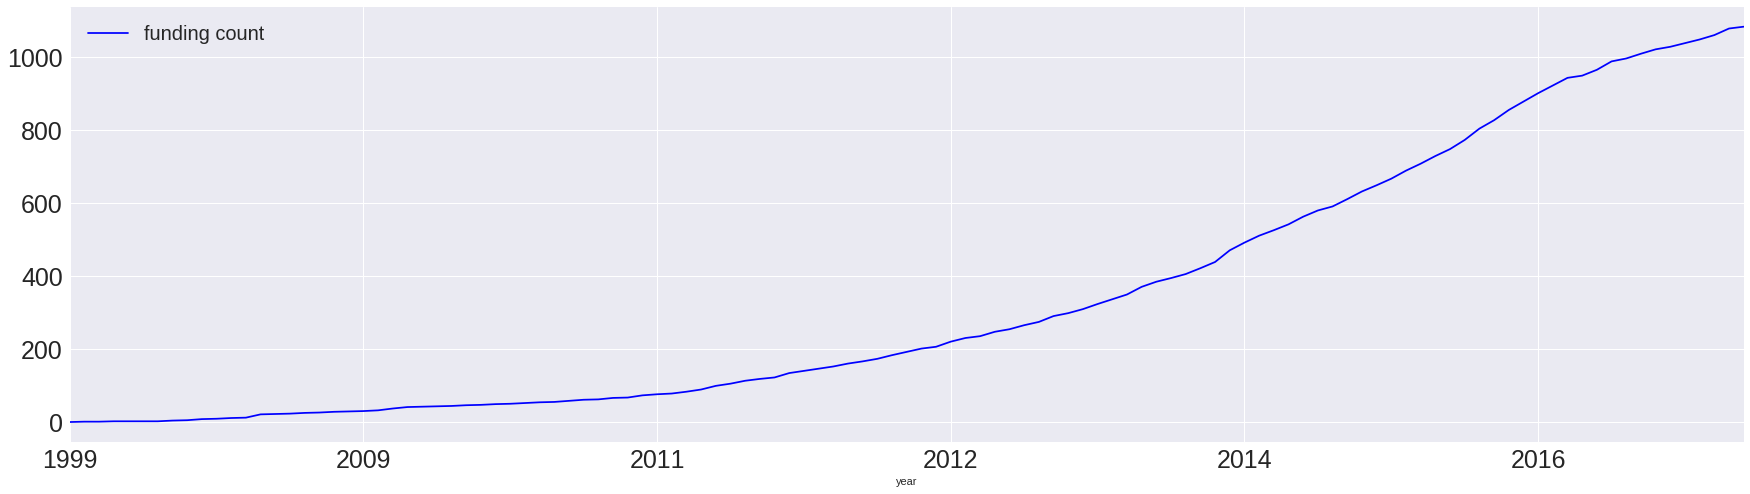

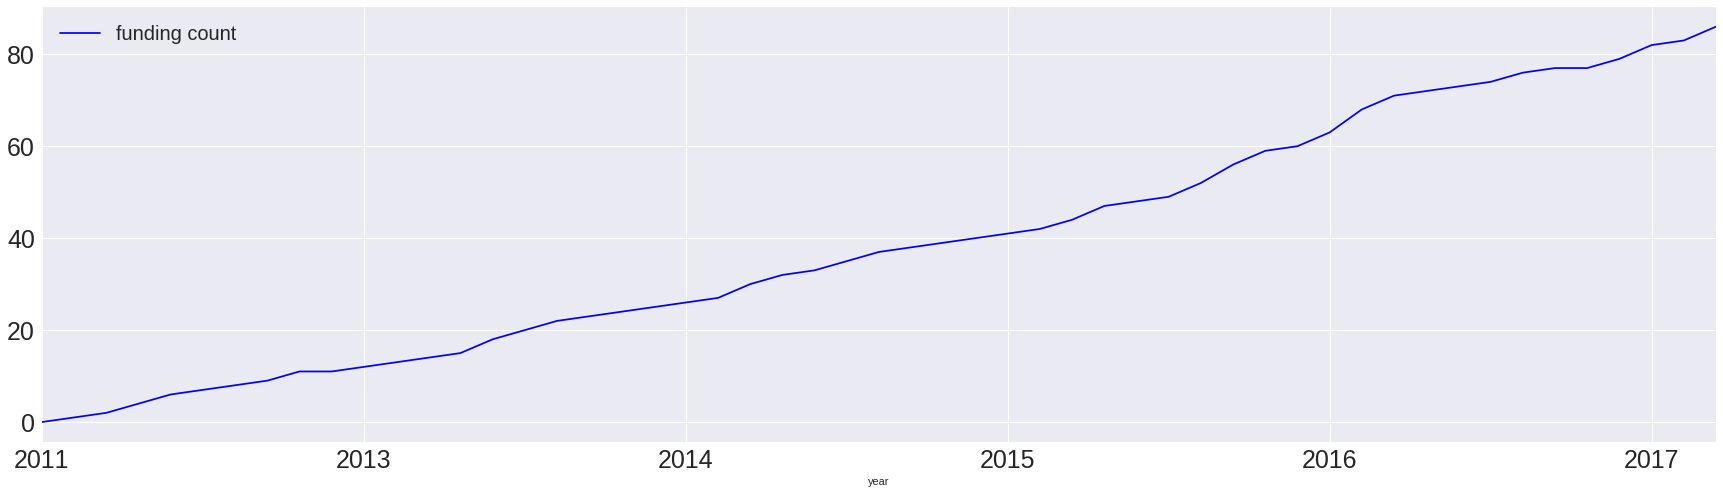

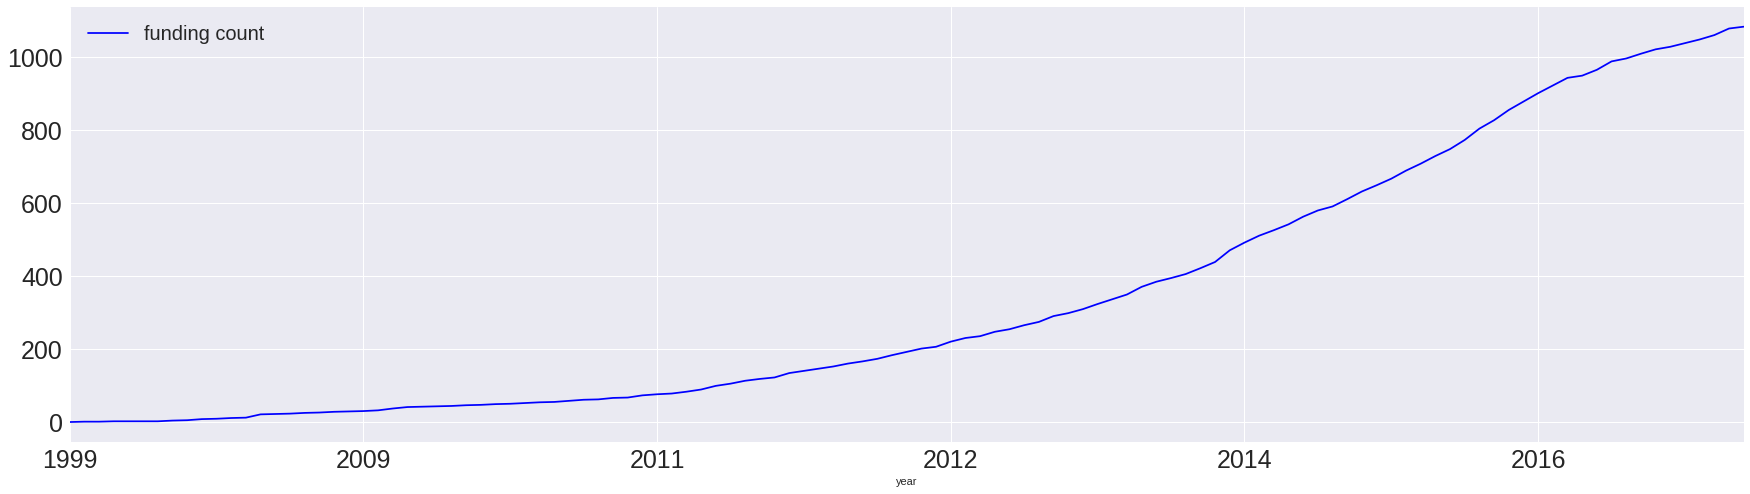

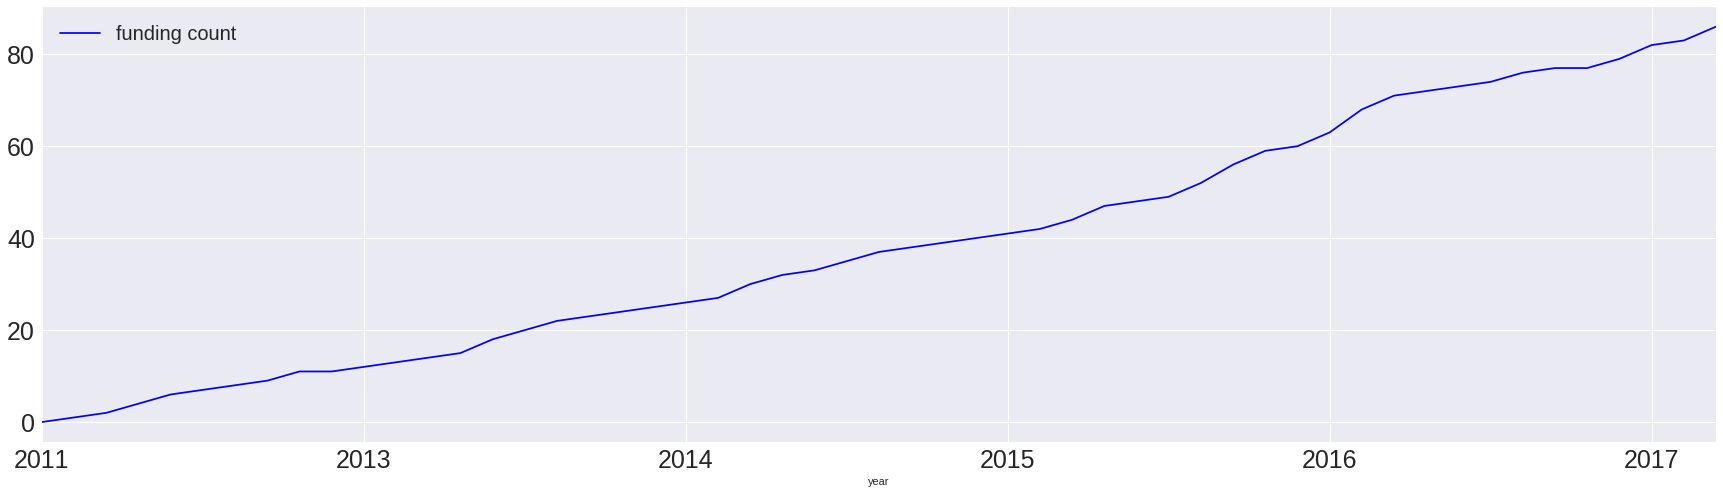

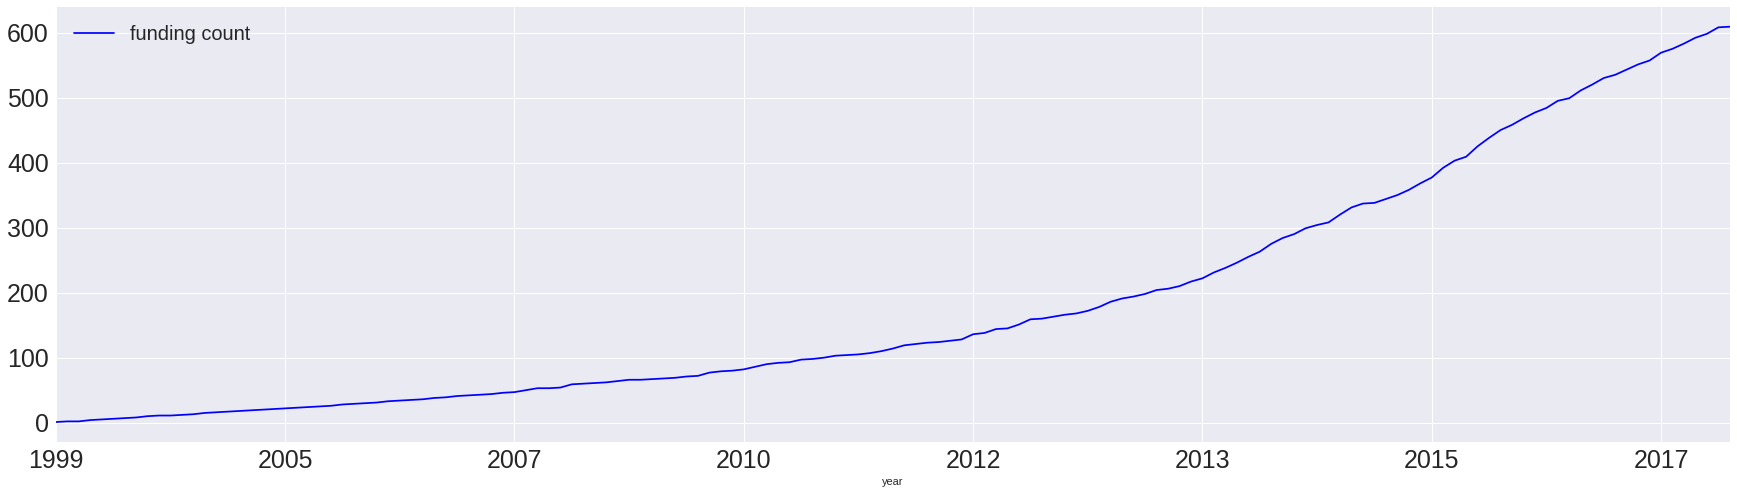

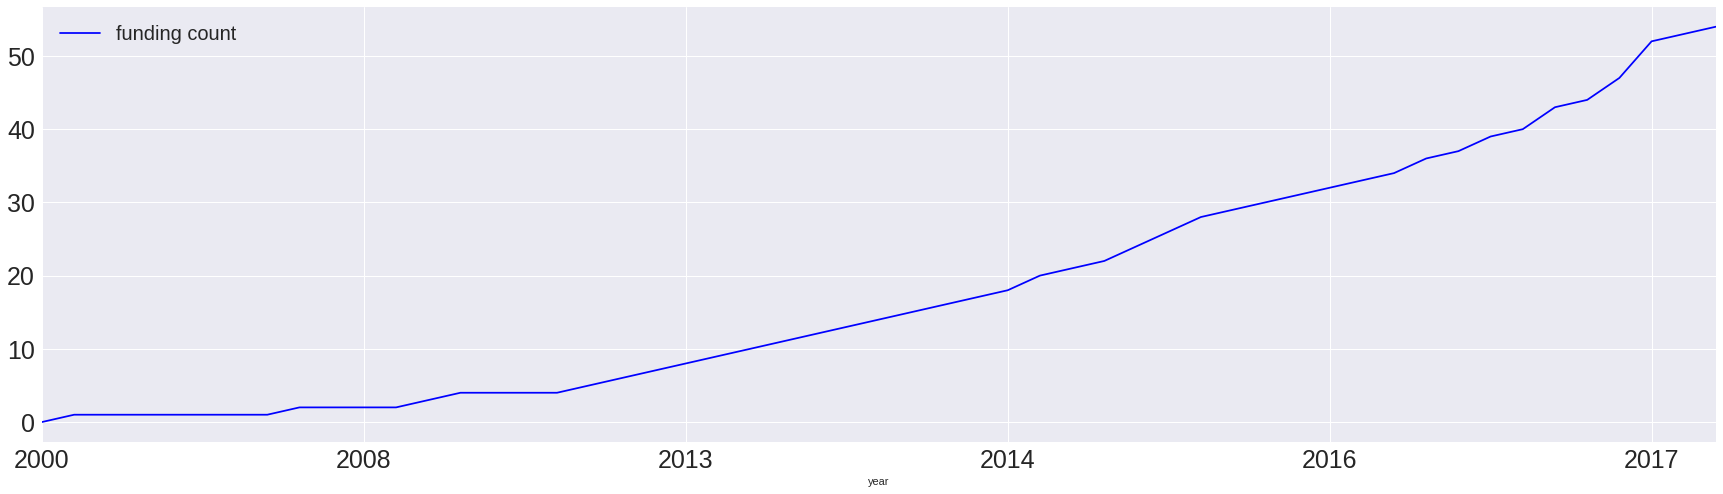

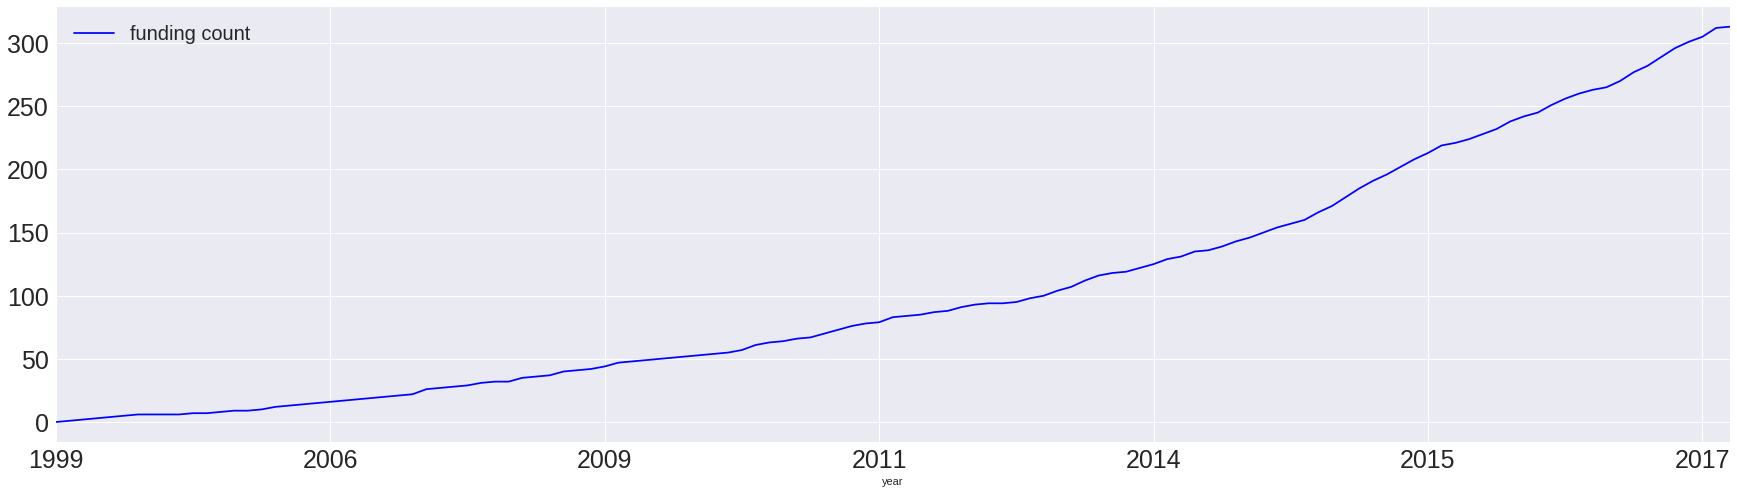

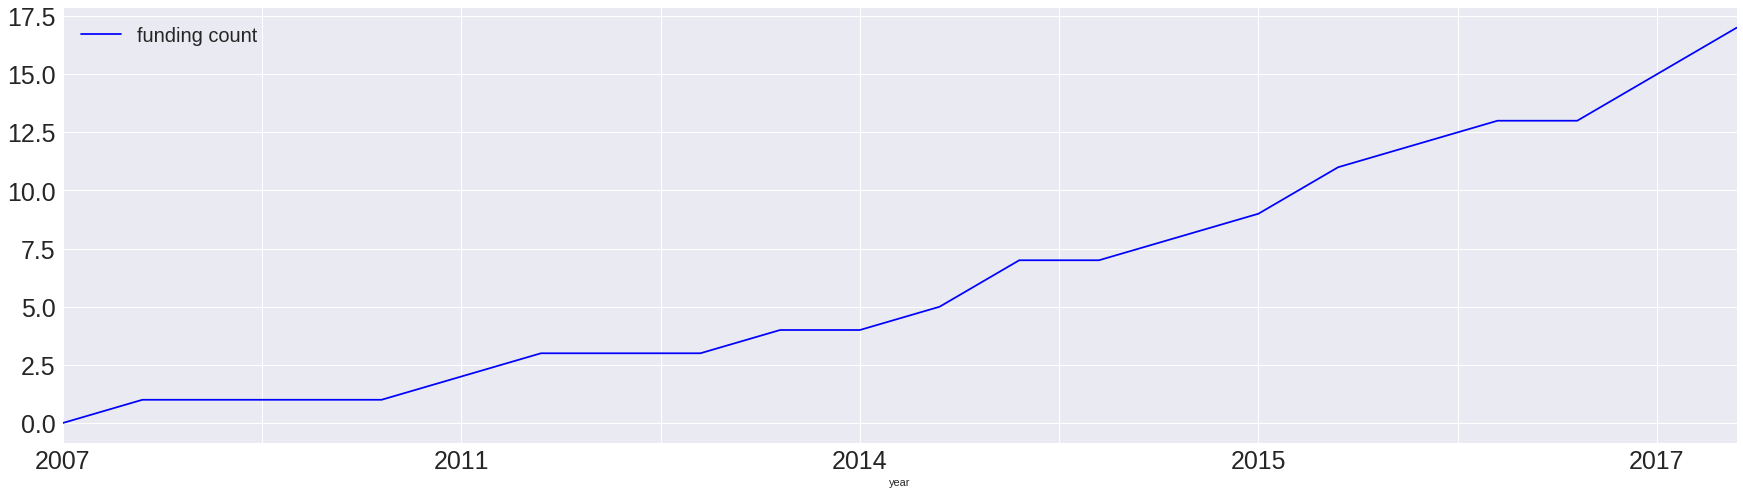

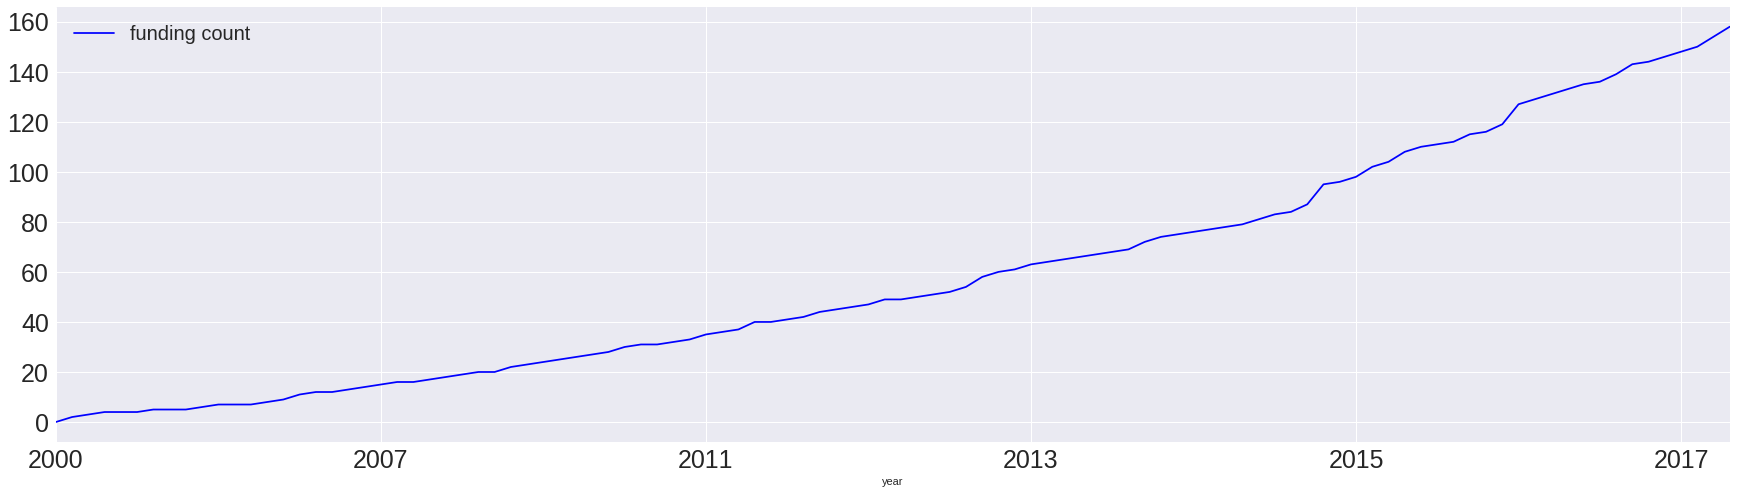

In [64]:
get_early_investors('fintech', early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['seed'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['A'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['B'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['C'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['artificial intelligence']
Early 10 percent investors before 2013-02-25 
(65 early fundings out of 659 total)
    count                                      investor_name     date
0       3                                  Horizons Ventures  2011-10
1       3                                              Wayra  2011-12
2       3  Ben Franklin Technology Partners of Northeaste...  2007-07
3       2                                  SRI International  2011-12
4       2                                   Pavel Cherkashin  2011-08
5       2                                   Felicis Ventures  2009-03
6       2                                          Techstars  2012-12
7       2                                               SOSV  2010-12
8       2                                          Techammer  2009-03
9       2                                     Eniac Ventures  2011-12
10      2                   MaRS Investment Accelerator Fund  2012-04
11      2                   

Relevant categories: ['artificial intelligence']
Early 10 percent investors before 2009-11-20 
(9 early fundings out of 98 total)
    count                investor_name     date
0       1        Mohr Davidow Ventures  2006-11
1       1           Foundation Capital  2008-08
2       1                Intel Capital  2008-12
3       1                QED Investors  2007-11
4       1                        Cisco  2000-10
5       1          Generation Partners  2005-12
6       1            Translink Capital  2008-05
7       1     Global Catalyst Partners  2008-05
8       1               Accel Partners  2006-11
9       1            Ignition Partners  2004-01
10      1       Walden Venture Capital  2008-05
11      1           Northwater Capital  2007-11
12      1      Pelion Venture Partners  2008-08
13      1    Boston Millennia Partners  2002-01
14      1                  HIG Capital  2002-01
15      1      Trilogy Equity Partners  2006-11
16      1    Atlanta Technology Angels  2002-01
17    

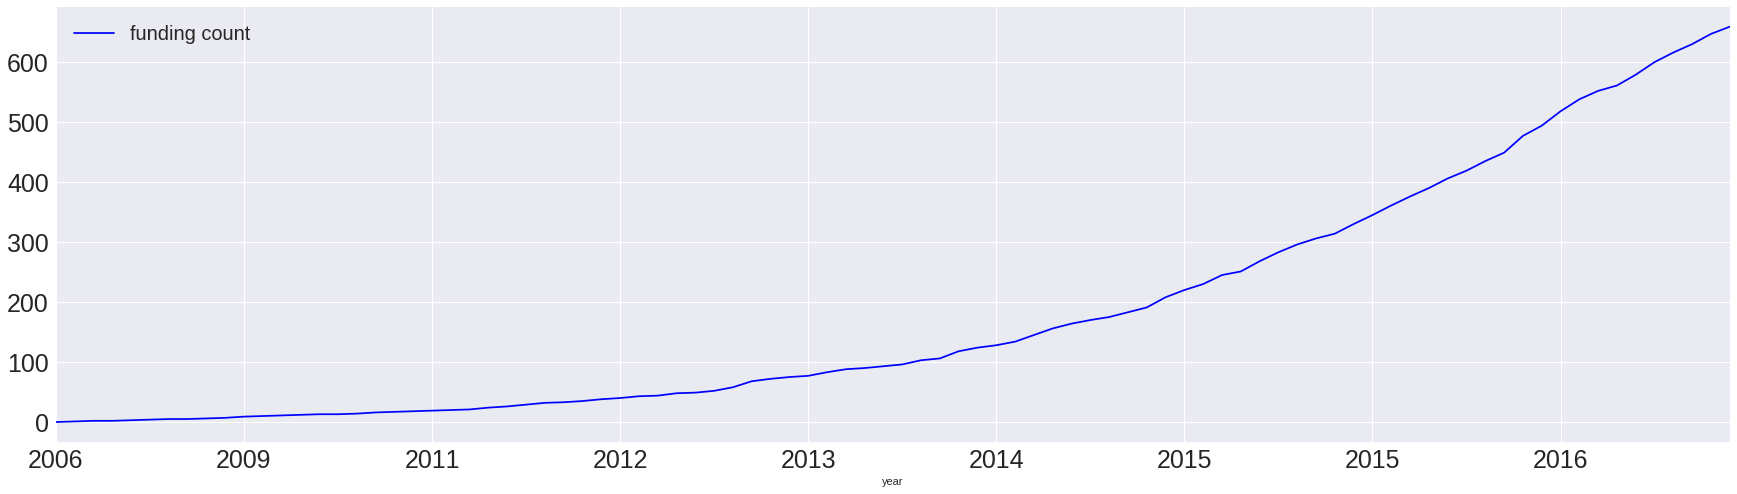

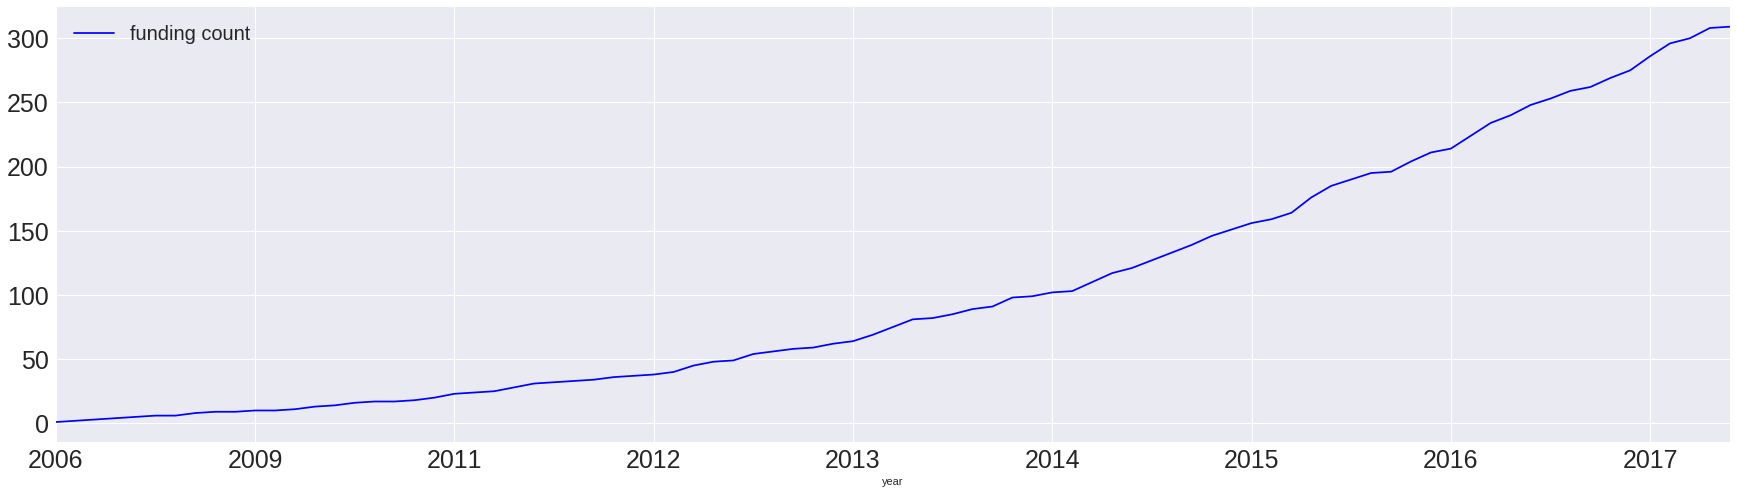

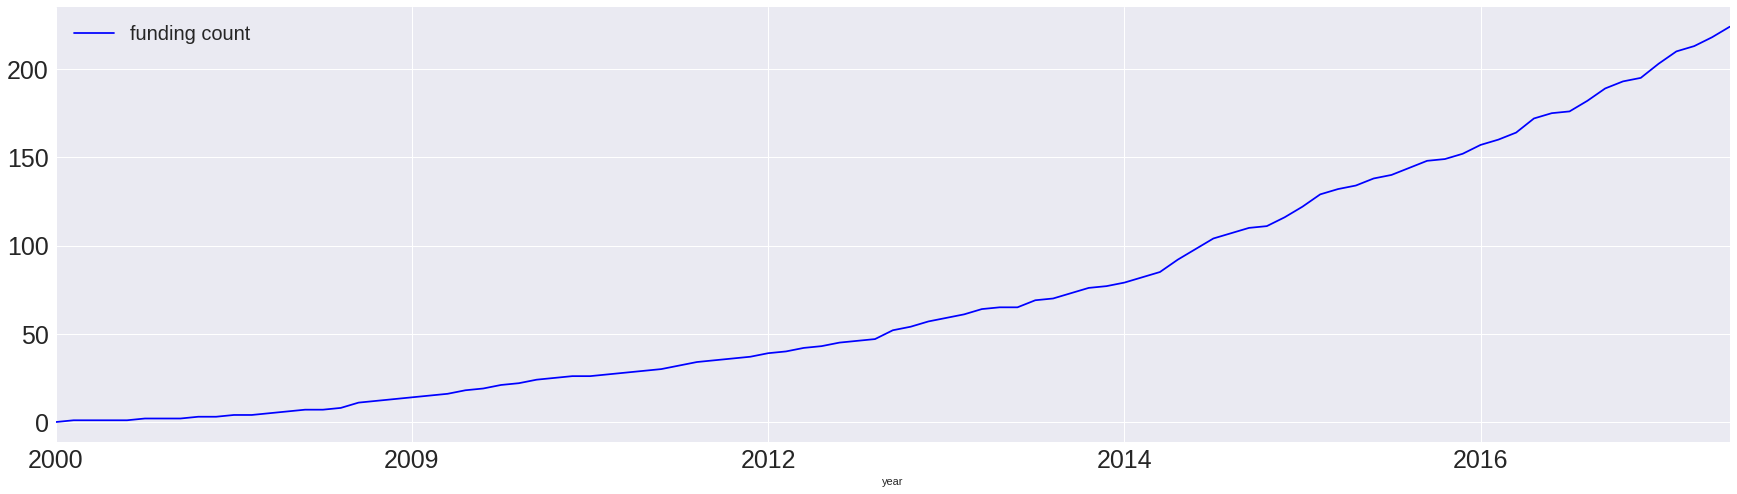

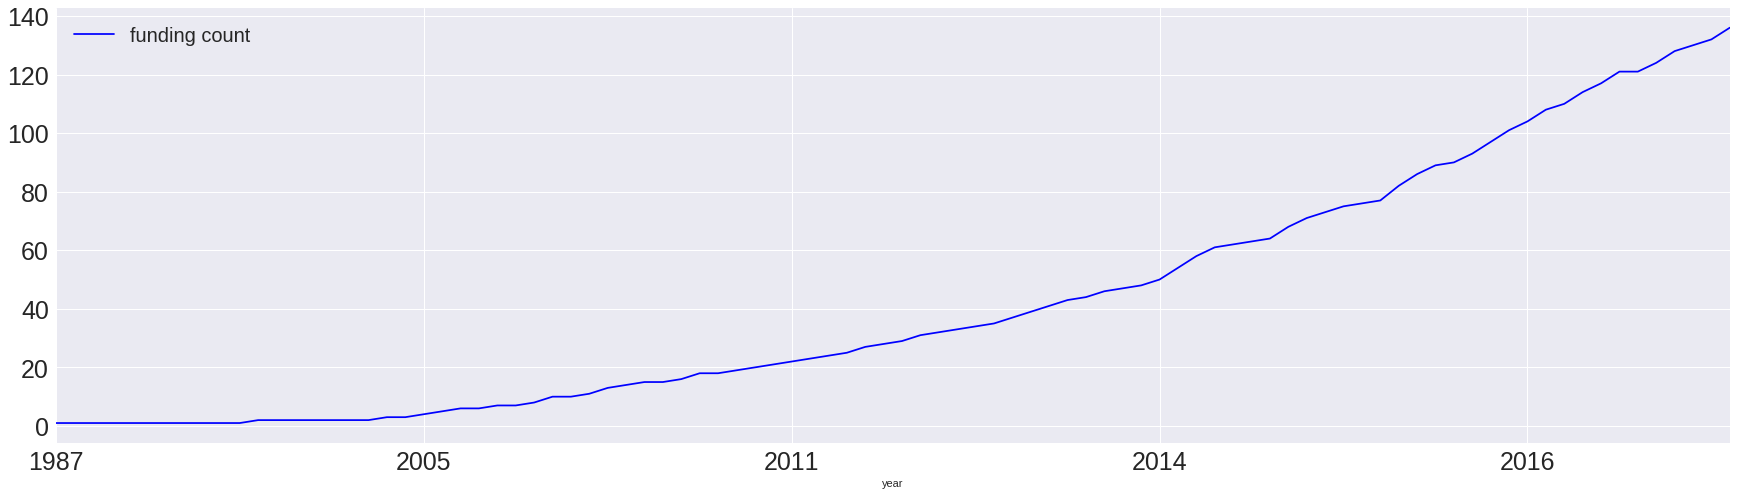

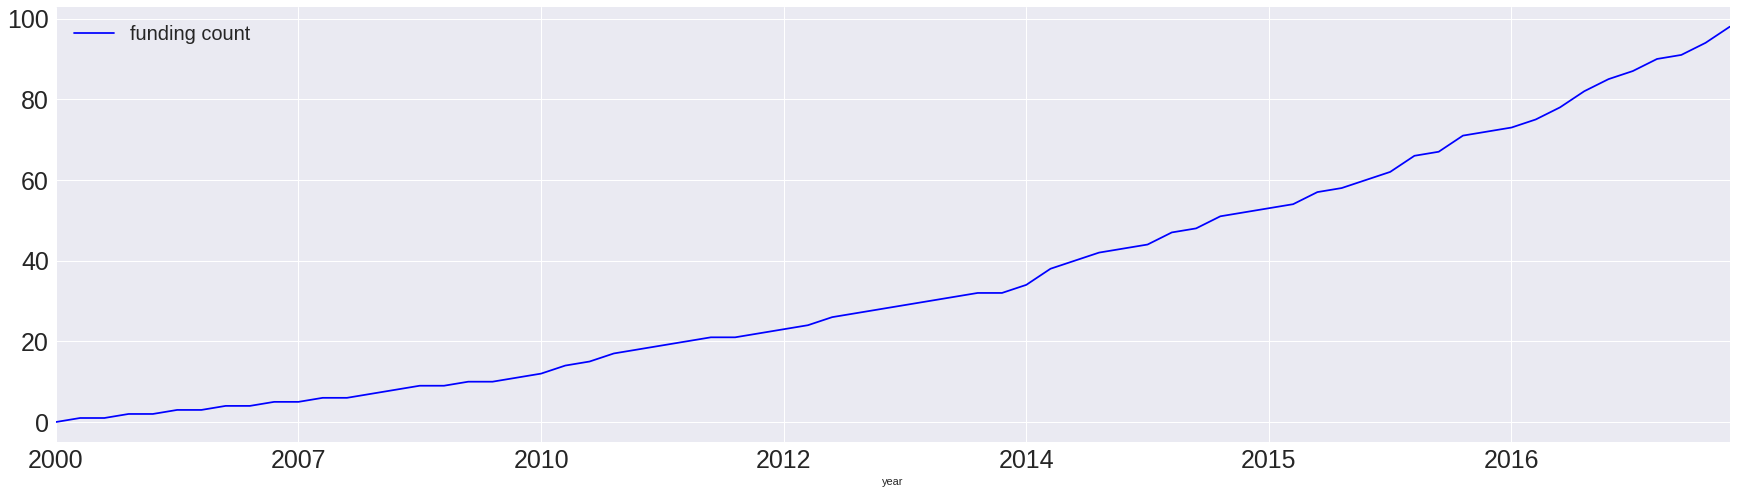

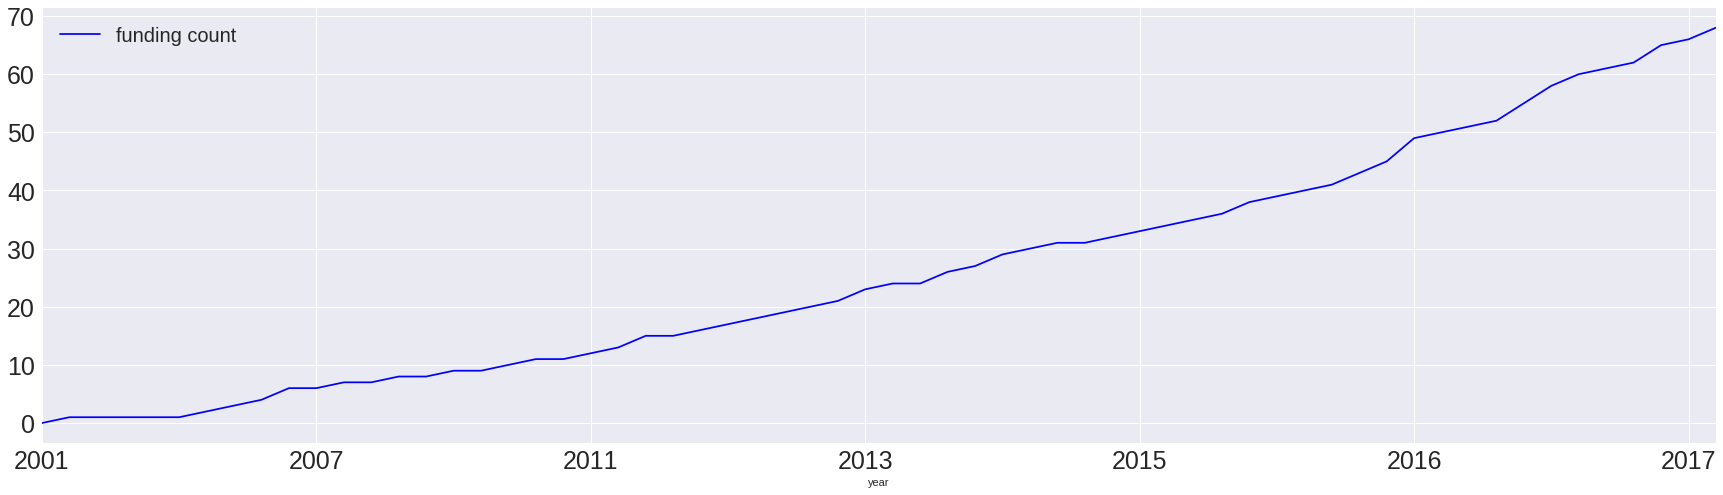

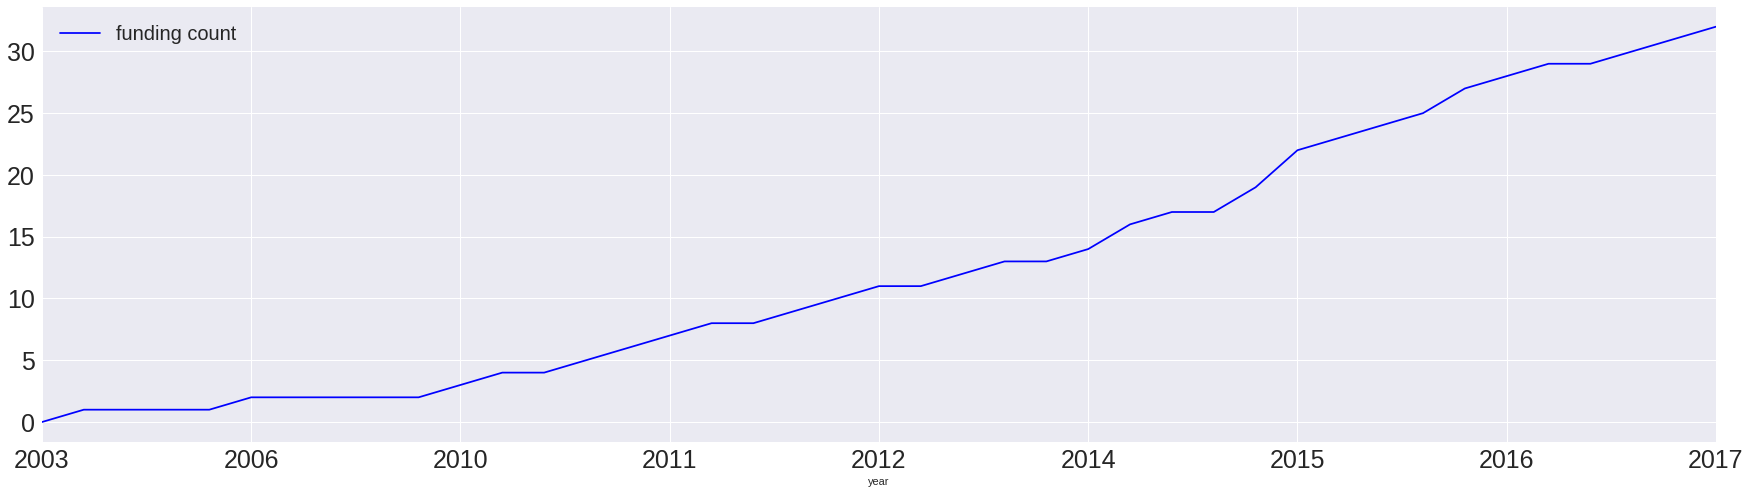

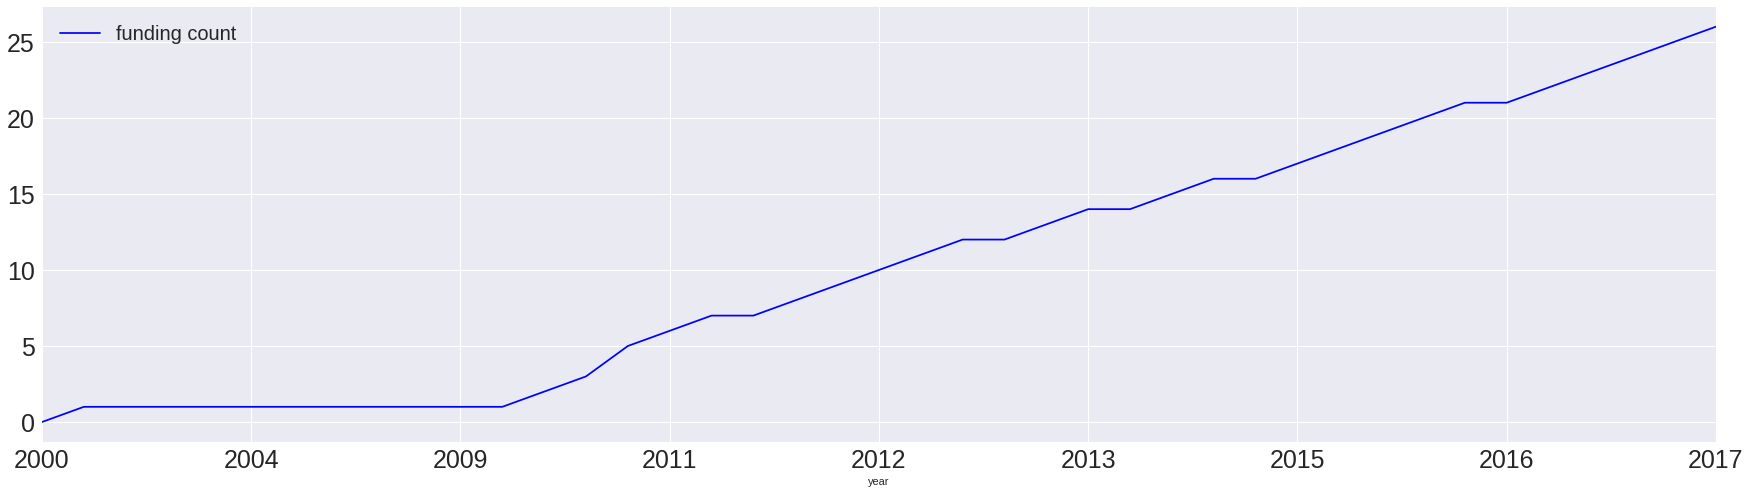

In [65]:
get_early_investors('artificial intelligence', investment_criteria=['seed'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['A'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['B'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['C'], early_investment_percent = 10, top_k = 30)

(900, 6)
Relevant categories: ['consumer']
Early 10 percent investors before 2003-08-01 
(90 early fundings out of 900 total)
    count                         investor_name     date
0       4                         Goldman Sachs  1999-12
1       4                     Flatiron Partners  2000-05
2       4                           TransCosmos  1999-11
3       4                       Summit Partners  1988-11
4       3                                   TCV  1999-12
5       3                       Lehman Brothers  2000-09
6       3                        J & W Seligman  1999-12
7       3                            HM Capital  1999-08
8       3                        Accel Partners  2000-09
9       3         Draper Fisher Jurvetson (DFJ)  2000-04
10      3                              SoftBank  1998-12
11      3                        August Capital  1999-05
12      3             Internet Healthcare Group  2000-07
13      2                        Bowman Capital  1999-12
14      2          

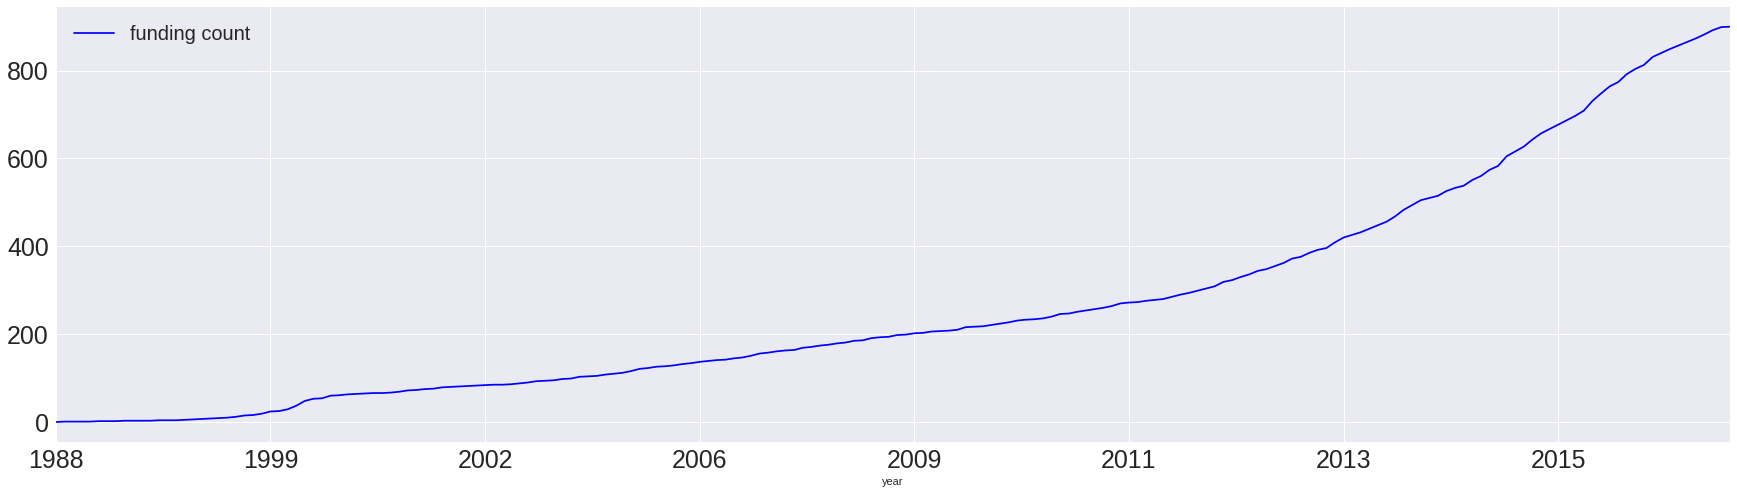

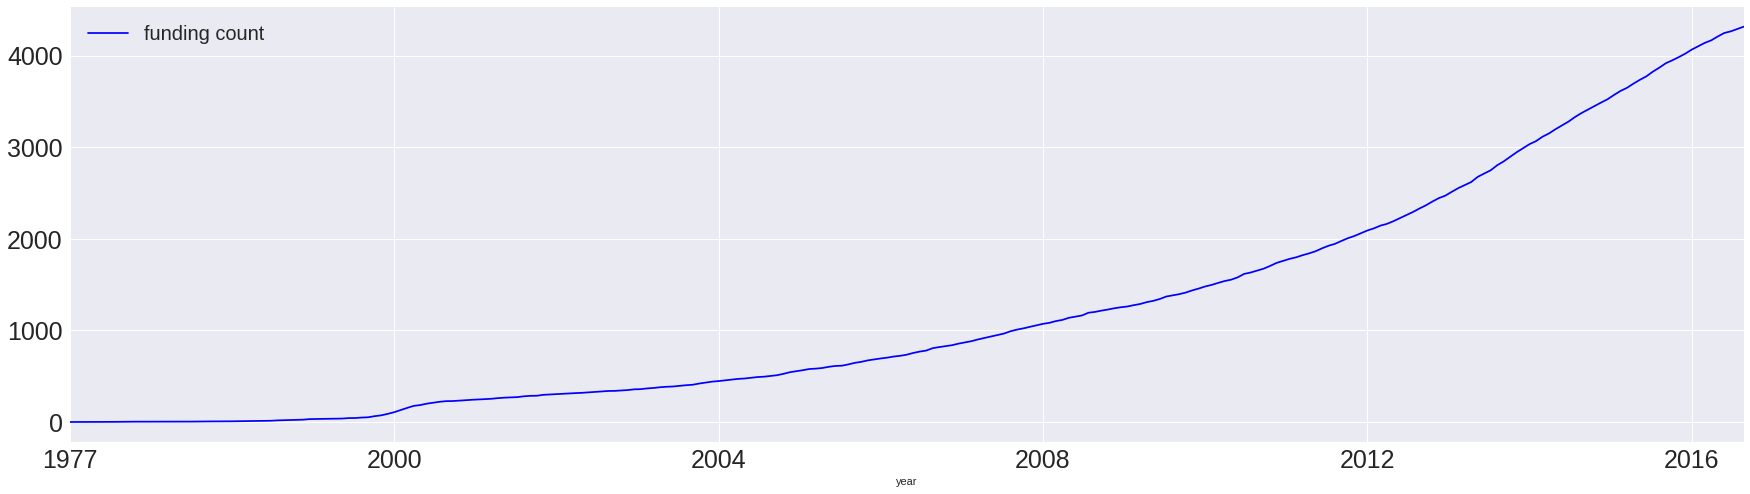

In [23]:
get_early_investors('consumer', early_investment_percent = 10, top_k = 30)

(10972, 6)
Relevant categories: ['health care']
Early 10 percent investors before 2006-02-03 
(1097 early fundings out of 10972 total)
    count                              investor_name     date
0      49                          Domain Associates  1999-02
1      46                  New Enterprise Associates  2000-06
2      44                           Versant Ventures  2000-12
3      32                        Three Arch Partners  2000-03
4      31                                    Venrock  1999-01
5      30  Johnson & Johnson Development Corporation  2000-03
6      29                              Alta Partners  2000-04
7      27                            Summit Partners  1986-05
8      27                                MPM Capital  1999-09
9      26                         InterWest Partners  2000-03
10     26                 Oxford Bioscience Partners  2001-01
11     24                           Polaris Partners  1997-12
12     23                Frazier Healthcare Partners  2000-

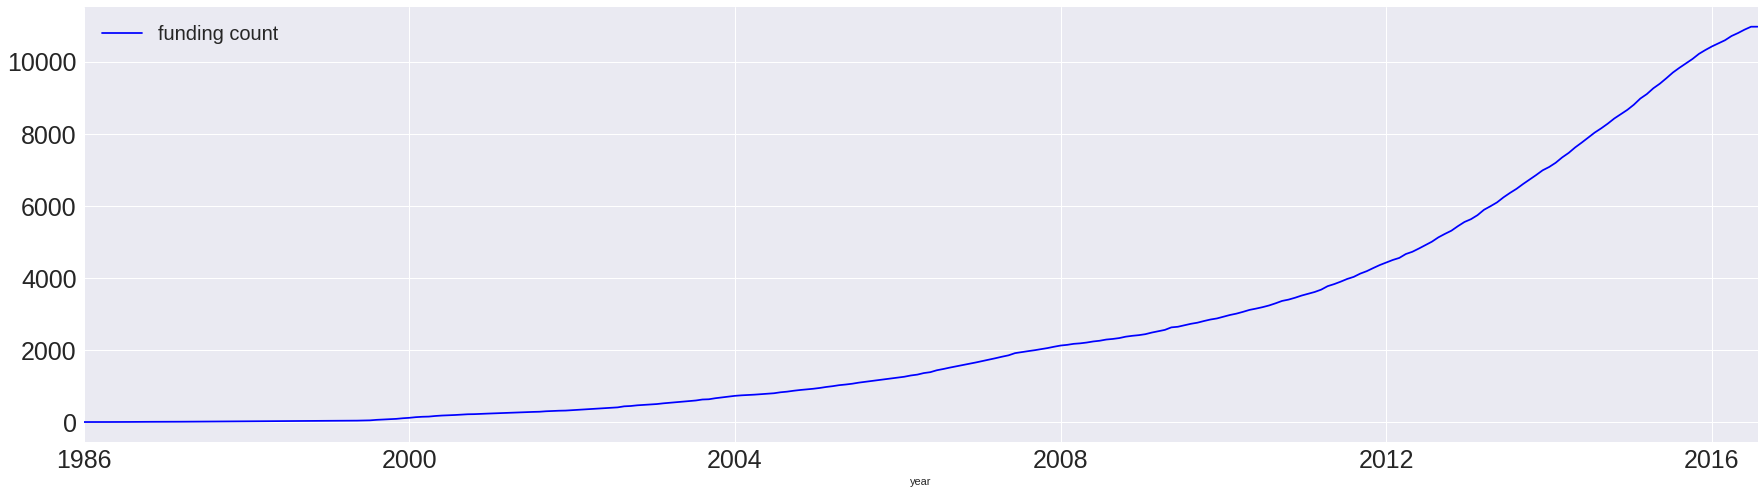

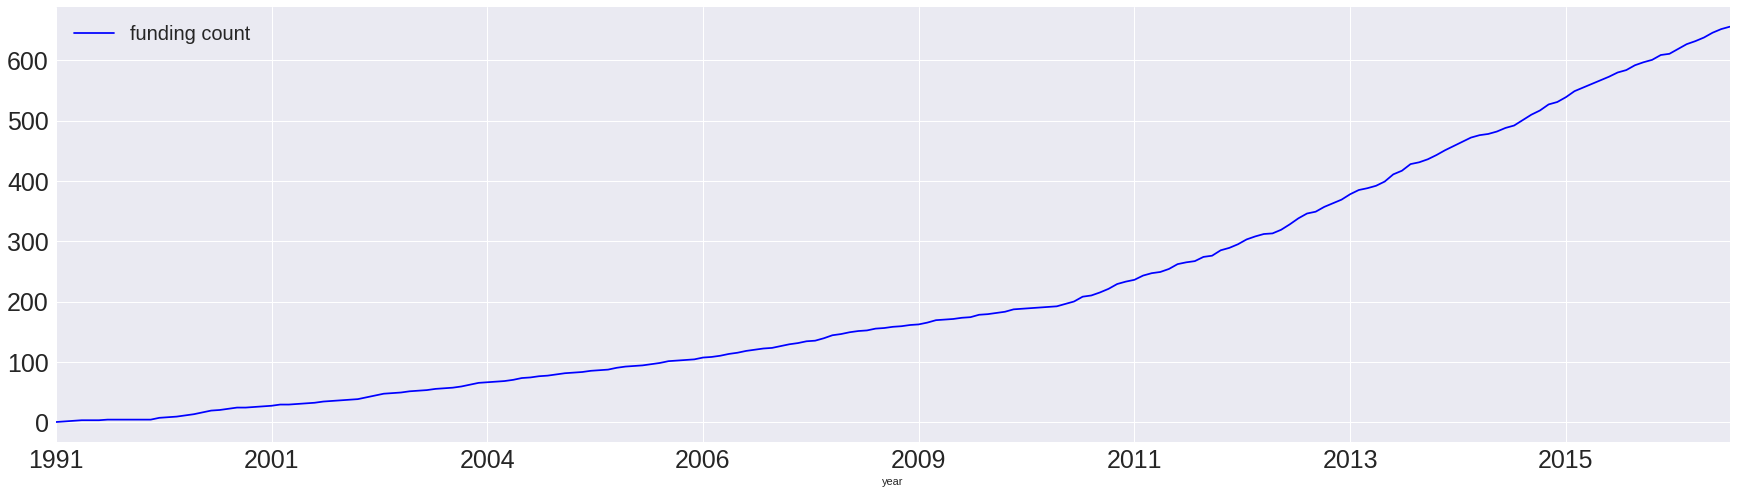

In [24]:
get_early_investors('health care', early_investment_percent = 10, top_k = 30)

(78, 6)
Relevant categories: ['craft beer']
Early 10 percent investors before 2012-10-25 
(7 early fundings out of 78 total)
   count    investor_name     date
0      2        Crowdcube  2011-10
1      1     The Brandery  2011-08
2      1  Leopard Capital  2011-05
3      1      Maxim Godin  2011-10
4      1      PV Ventures  2010-11
5      1   Consor Capital  2006-11
6      1         Rob Keve  2011-10
7      1   Victor Levitin  2011-10
(8, 3)
Keywords: ['craft_beer']
Early 10 percent investors before 2013-03-21 
(2 early fundings out of 28 total)
   count      investor_name     date
0      1         CrunchFund  2012-01
1      1      David Rusenko  2012-01
2      1  Cavallino Capital  2012-04
(3, 3)


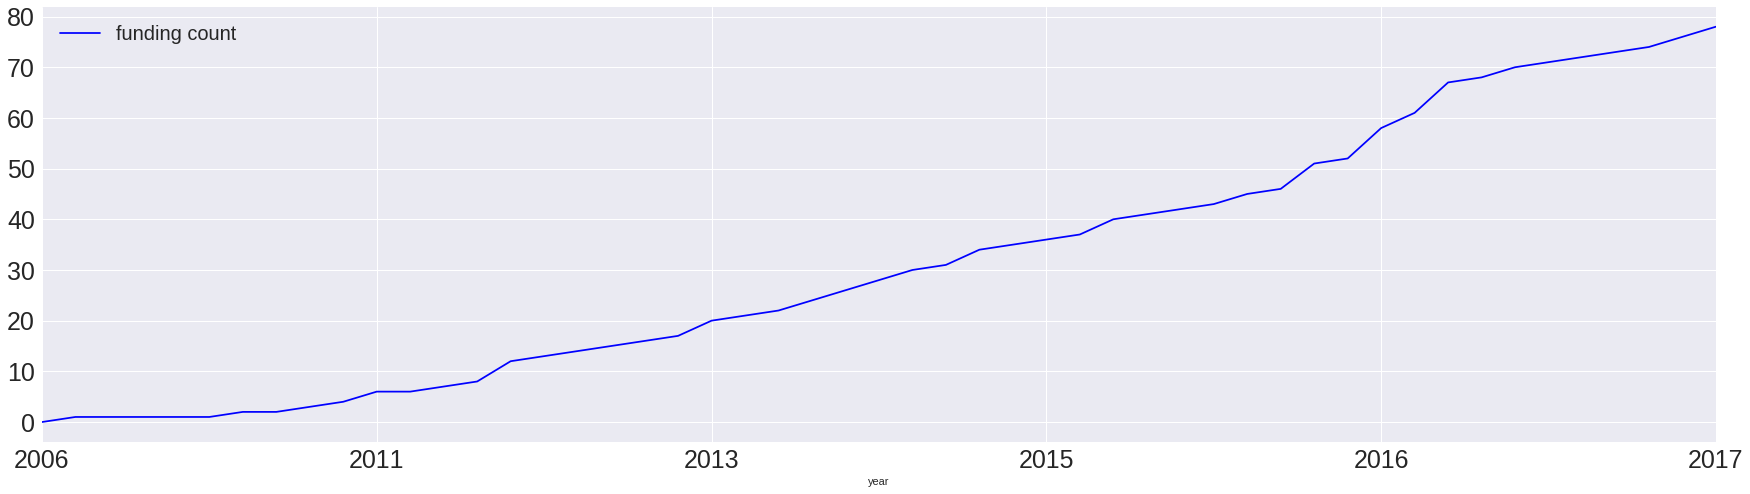

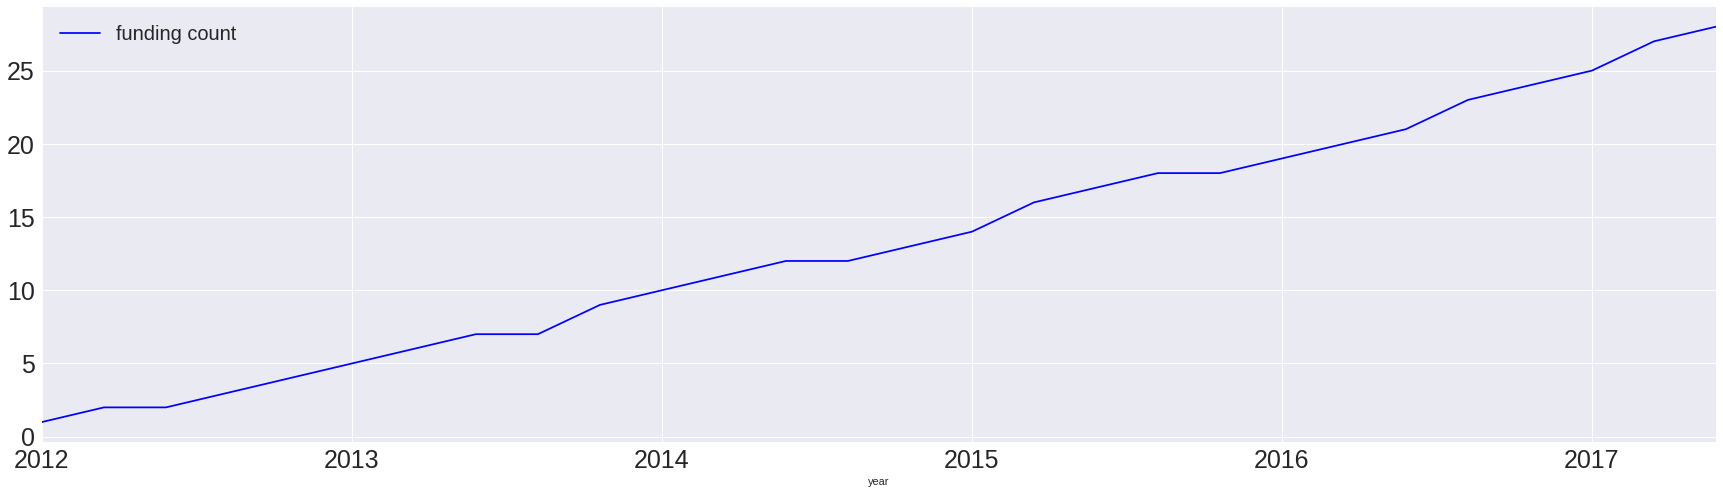

In [25]:
get_early_investors('craft beer', early_investment_percent = 10, top_k = 30)

In [54]:
# crunchbase 의 카테고리 정보로 빠른 투자자 vs 전체 그려보기
def plot_early_investors(category, weight_scheme = 'sqrt', TOP_K = 30, verbose = True, this_is_word = False, expand = False):
    color1 = 'black'
    color2 = 'blue'
    color3 = 'red'
    color4 = 'green'
    color5 = 'pink'
    
    # 일단은 centrality top VC 를 그려보자
    central = pickle.load(open(util_folder + 'investor_centrality_between_one_over_k.pickle'))
    topVC = [uuid for uuid, value in central[:TOP_K]]
    top_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(topVC)]['funding_round_uuid'].unique()
    
    if this_is_word:
        expert = pickle.load(open('../data/others/investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))
        seed_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))        
        other_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all_norm.pickle'.format(category)))        
    else:
#         expert = pickle.load(open('../data/others/investor_harmonic_rank_for_{}.pickle'.format(category)))
        expert = pickle.load(open('../data/others/investor_{}_harmonic_rank_for_{}.pickle'.format(weight_scheme, category)))
        seed_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))        
        other_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all_norm.pickle'.format(category)))        
    expert = sorted(expert.items(), key = operator.itemgetter(1))
    expertVC = [uuid for uuid, value in expert[:TOP_K]]
    expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(expertVC)]['funding_round_uuid'].unique()

    seed_expert = sorted(seed_expert.items(), key = operator.itemgetter(1))
    seed_expertVC = [uuid for uuid, value in seed_expert[:TOP_K]]
    seed_expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(seed_expertVC)]['funding_round_uuid'].unique()

    other_expert = sorted(other_expert.items(), key = operator.itemgetter(1))
    other_expertVC = [uuid for uuid, value in other_expert[:TOP_K]]
    other_expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(other_expertVC)]['funding_round_uuid'].unique()

    if this_is_word:
        if 'word2company' not in globals():
            print('loading word2company')
            global word2company
            word2company = pickle.load(open(util_folder + 'word2company.pickle'))
        if 'model' not in globals():
            print('loading word2vec model')
            global model
            model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

        words = category
        final_words = []
        if type(words) == str:
            words = [words]
        for word in words:
            if ' ' in word:
                word = word.replace(' ', '_')
            if expand:
                if word not in model: continue
                _words = model.most_similar(word)
                _words = [str(_word) for _word, sim in _words]
                final_words.extend(_words)
            final_words.append(word)
        final_words = list(set(final_words))
        print final_words

        # 해당 단어가 있는 회사들을 모은다
        companies = []
        for word in final_words:
            _companies = word2company.get(word, [])
            companies.extend(_companies)
        companies = list(set(companies))

#         if category not in word2company:
#             print 'word', category, 'is not in dataset'
#             return
        df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')    
    else:
        df = df_funding[df_funding['category'] == category].drop_duplicates('funding_round_uuid')
    df_top = df[df['funding_round_uuid'].isin(top_funding_round_uuids)]
    df_expert = df[df['funding_round_uuid'].isin(expert_funding_round_uuids)]
    df_seed_expert = df[df['funding_round_uuid'].isin(seed_expert_funding_round_uuids)]
    df_other_expert = df[df['funding_round_uuid'].isin(other_expert_funding_round_uuids)]

    print "Category:",category
    print '# investment by all VC', df.shape[0]
    print '# investment by top VC', df_top.shape[0]
    print '# investment by expert VC', df_expert.shape[0]
    print '# investment by seed expert VC', df_seed_expert.shape[0]
    print '# investment by other expert VC', df_other_expert.shape[0]
    
    if verbose:
        for vc in expertVC[:TOP_K]:
            print df_investors[df_investors['uuid'] == (vc)]['investor_name'].values[0]
    try:
        start_year = min(df['year-month'].values)[:4]
    except Exception as e:
        print 'no data'
        return
    count = df.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count').reset_index()
    count_top = df_top.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_top').reset_index()
    count_expert = df_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_expert').reset_index()
    count_seed_expert = df_seed_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_seed_expert').reset_index()
    count_other_expert = df_other_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_other_expert').reset_index()

    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.merge(count_top, on = 'year-month', how = 'left')
    count = count.merge(count_expert, on = 'year-month', how = 'left')
    count = count.merge(count_seed_expert, on = 'year-month', how = 'left')
    count = count.merge(count_other_expert, on = 'year-month', how = 'left')

    count = count.sort_values('year-month')
    count = count.fillna(0)

    count['cum_count'] = count['count'].cumsum()
    count['cum_count'] = count['cum_count'] / max(count['cum_count'])

    count['cum_count_top'] = count['count_top'].cumsum()
    count['cum_count_top'] = count['cum_count_top'] / max(count['cum_count_top'])

    count['cum_count_expert'] = count['count_expert'].cumsum()
    count['cum_count_expert'] = count['cum_count_expert'] / max(count['cum_count_expert'])
    
    count['cum_count_seed_expert'] = count['count_seed_expert'].cumsum()
    count['cum_count_seed_expert'] = count['cum_count_seed_expert'] / max(count['cum_count_seed_expert'])

    count['cum_count_other_expert'] = count['count_other_expert'].cumsum()
    count['cum_count_other_expert'] = count['cum_count_other_expert'] / max(count['cum_count_other_expert'])

    count[['year-month', 'cum_count', 'cum_count_top', 'cum_count_expert', 'cum_count_seed_expert', 'cum_count_other_expert']].plot(x = count['year'], linestyle = '-', color = [color1, color2, color3, color4, color5], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['total', 'centrality', 'all_early', 'seed_early', 'other_early'])
    plt.show()

Category: software
# investment by all VC 15892
# investment by top VC 1405
# investment by expert VC 1254
# investment by seed expert VC 796
# investment by other expert VC 760


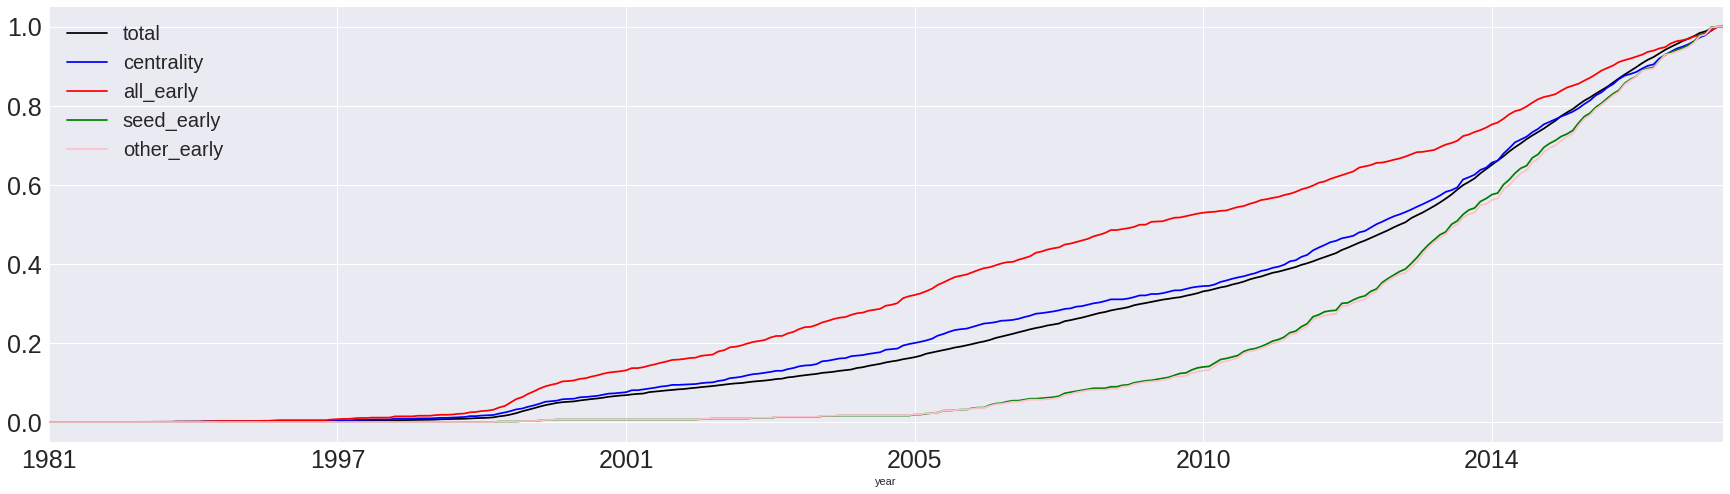

Category: mobile
# investment by all VC 12275
# investment by top VC 1329
# investment by expert VC 945
# investment by seed expert VC 753
# investment by other expert VC 753


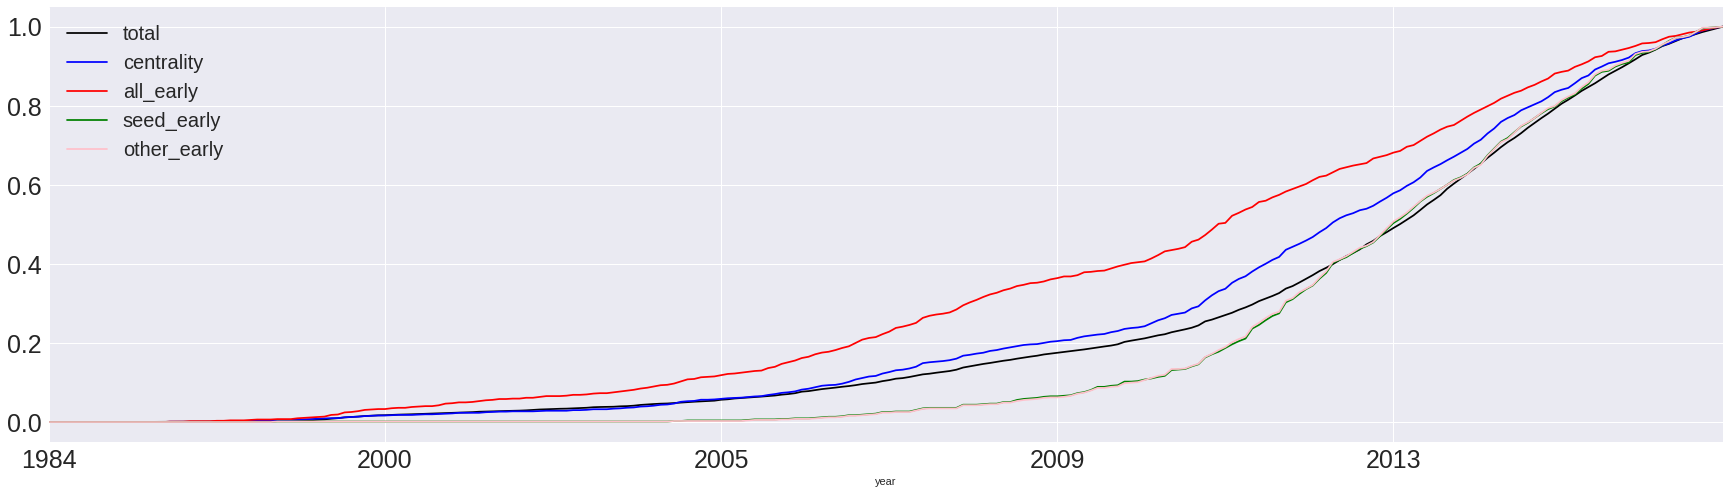

Category: health care
# investment by all VC 10972
# investment by top VC 690
# investment by expert VC 543
# investment by seed expert VC 374
# investment by other expert VC 421


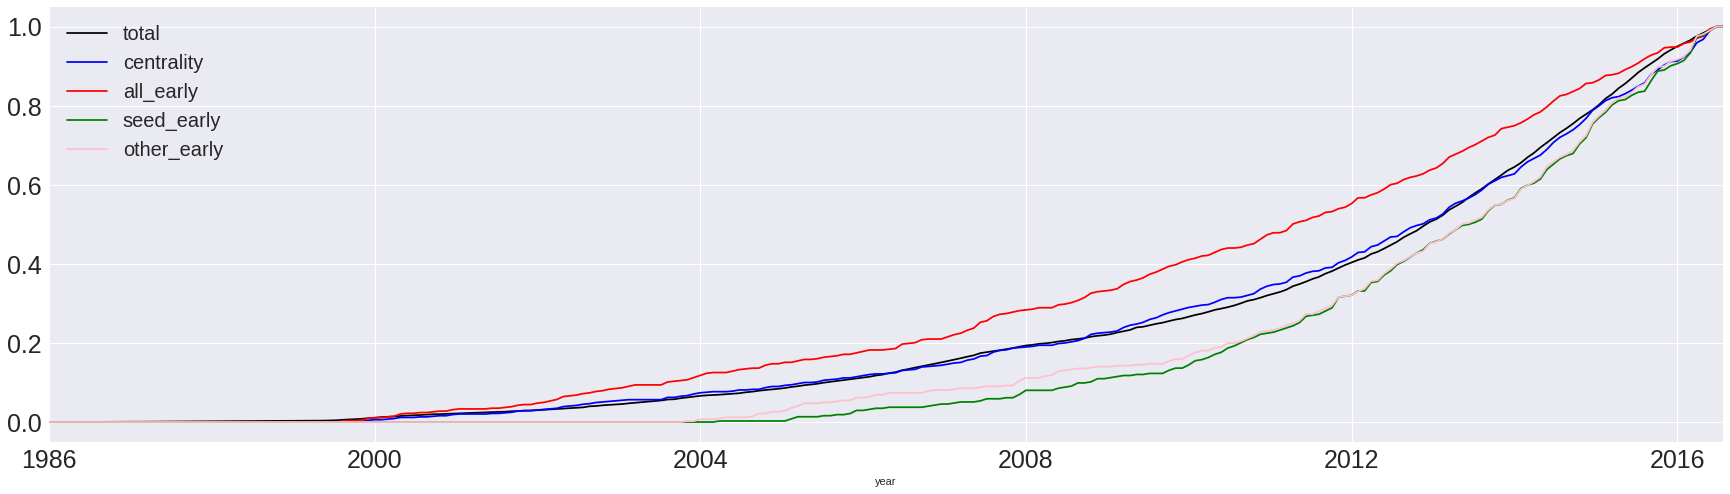

Category: enterprise software
# investment by all VC 9600
# investment by top VC 1163
# investment by expert VC 1019
# investment by seed expert VC 487
# investment by other expert VC 479


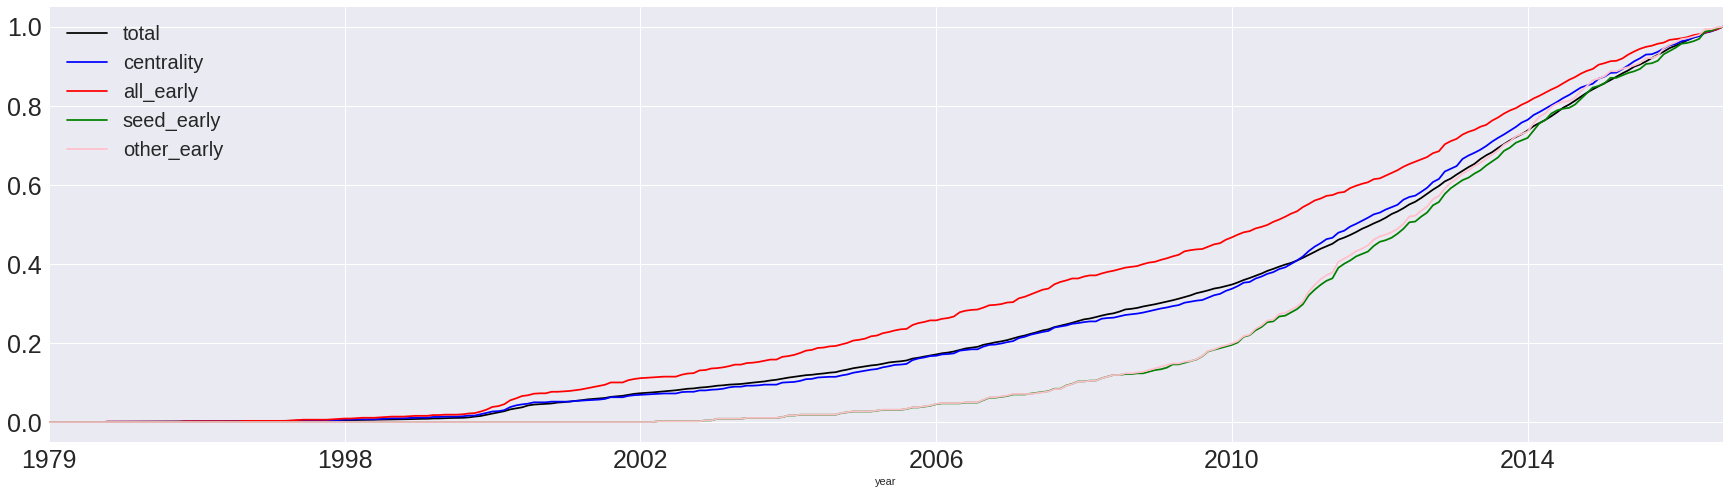

Category: e-commerce
# investment by all VC 9173
# investment by top VC 963
# investment by expert VC 612
# investment by seed expert VC 632
# investment by other expert VC 638


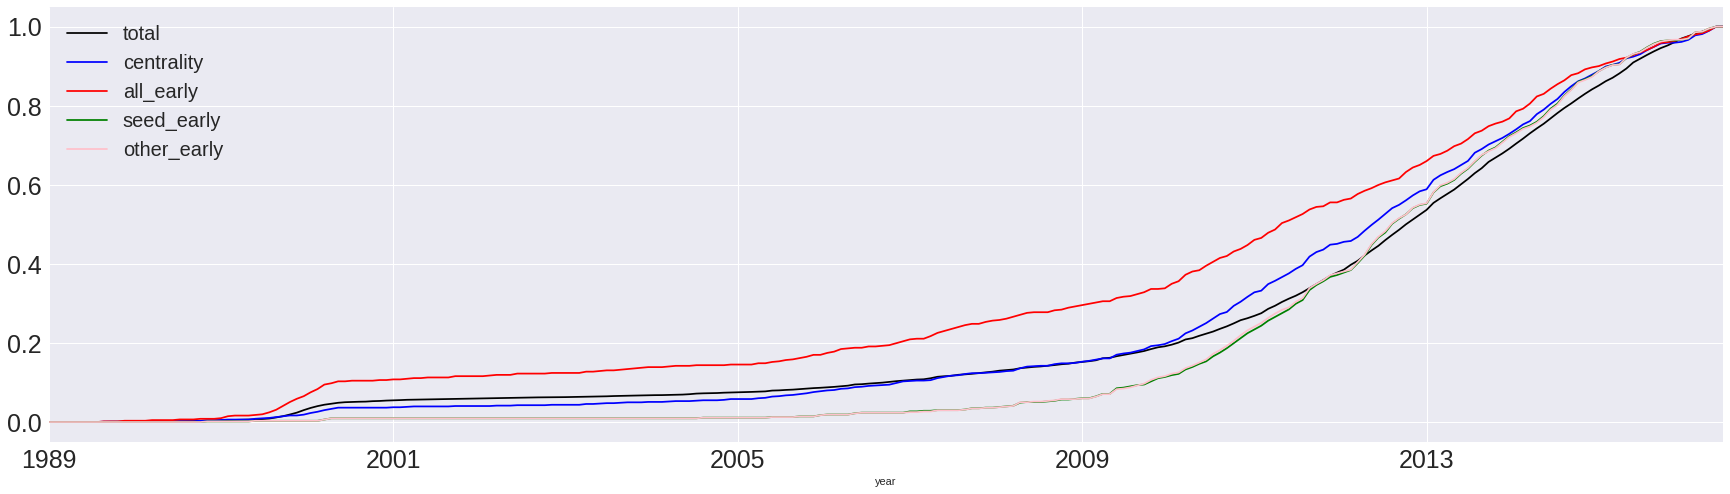

Category: internet
# investment by all VC 8314
# investment by top VC 1037
# investment by expert VC 911
# investment by seed expert VC 396
# investment by other expert VC 414


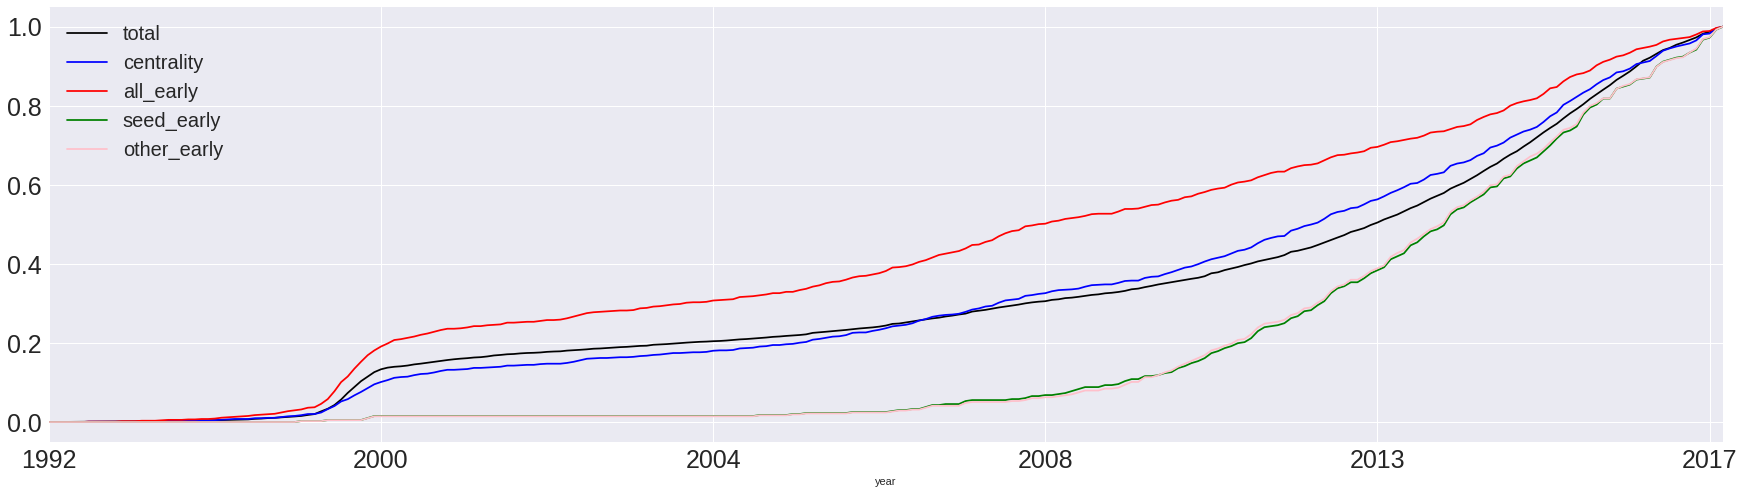

Category: biotechnology
# investment by all VC 7931
# investment by top VC 456
# investment by expert VC 406
# investment by seed expert VC 199
# investment by other expert VC 278


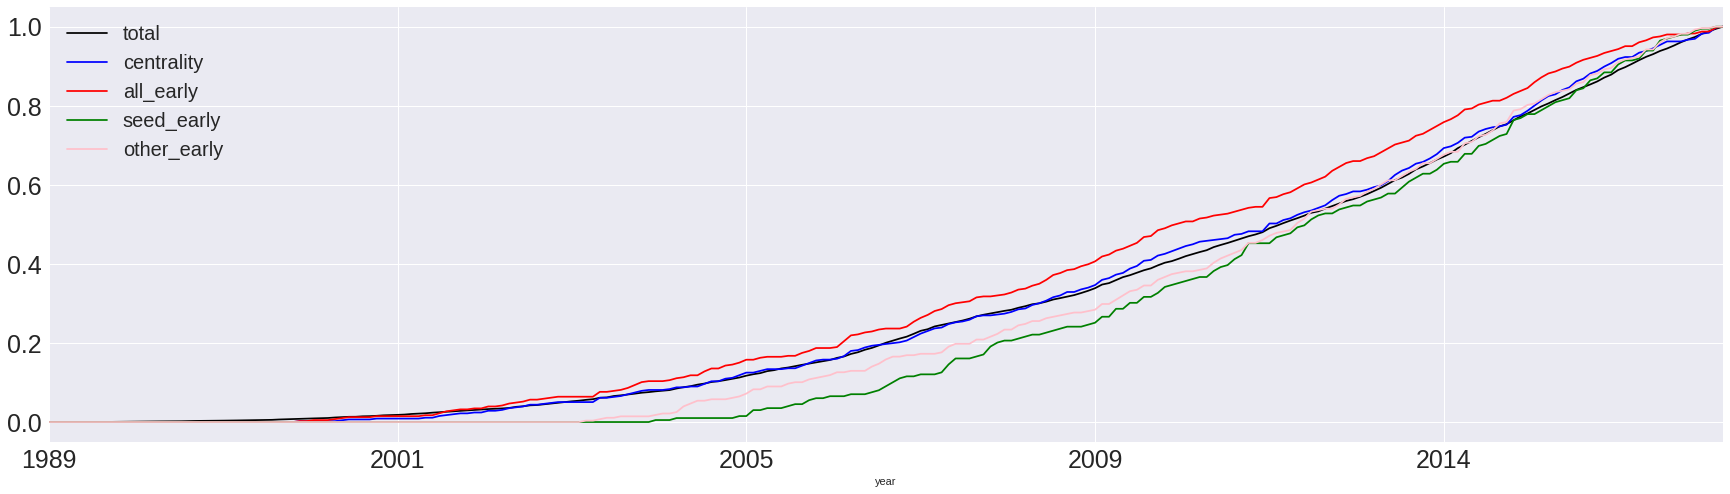

Category: information technology
# investment by all VC 6659
# investment by top VC 495
# investment by expert VC 473
# investment by seed expert VC 232
# investment by other expert VC 223


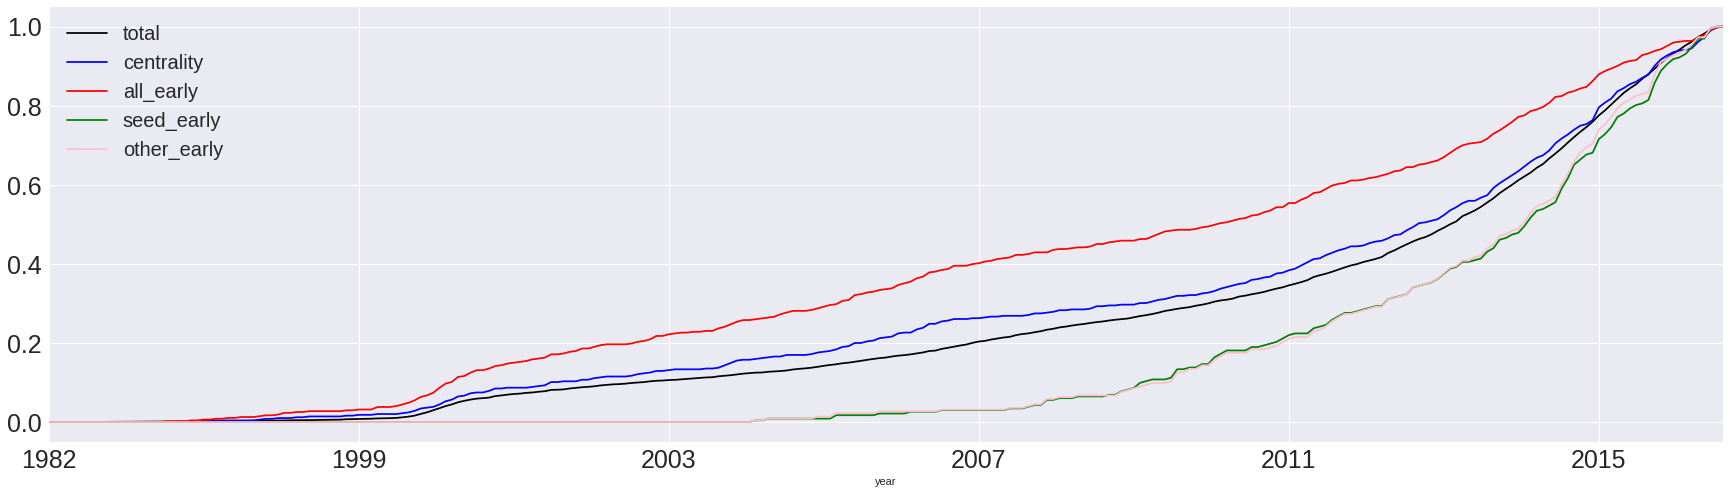

Category: saas
# investment by all VC 6240
# investment by top VC 608
# investment by expert VC 385
# investment by seed expert VC 441
# investment by other expert VC 423


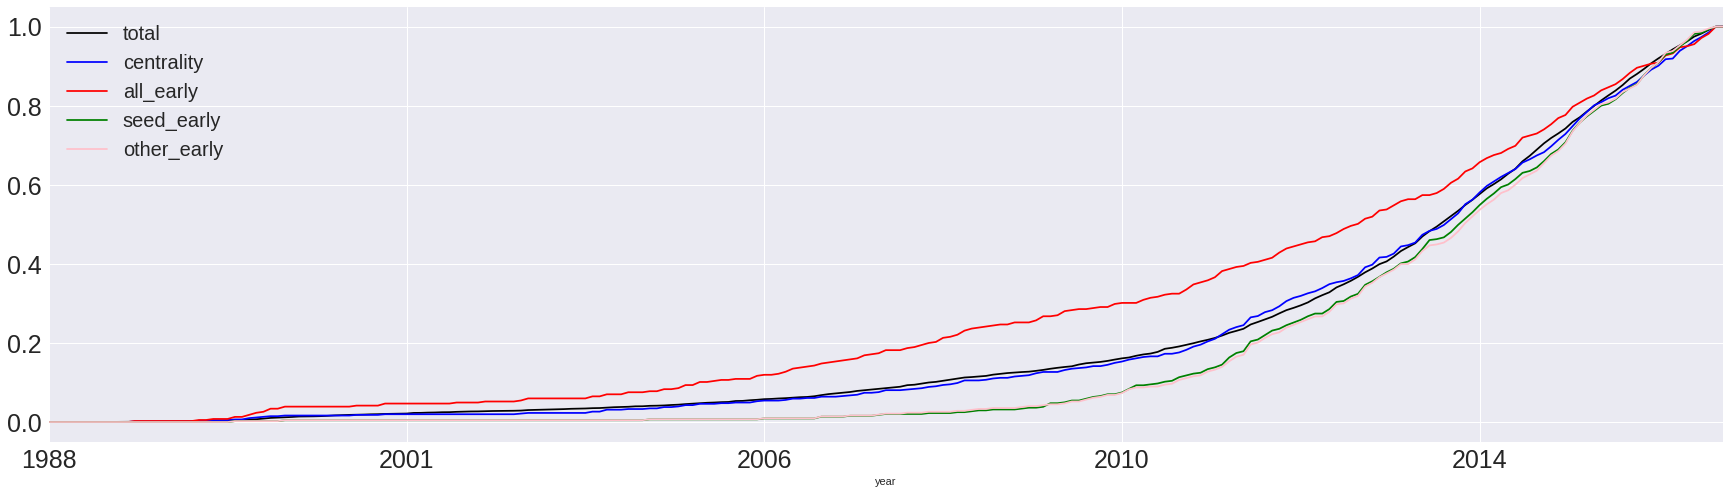

Category: analytics
# investment by all VC 5959
# investment by top VC 654
# investment by expert VC 494
# investment by seed expert VC 404
# investment by other expert VC 392


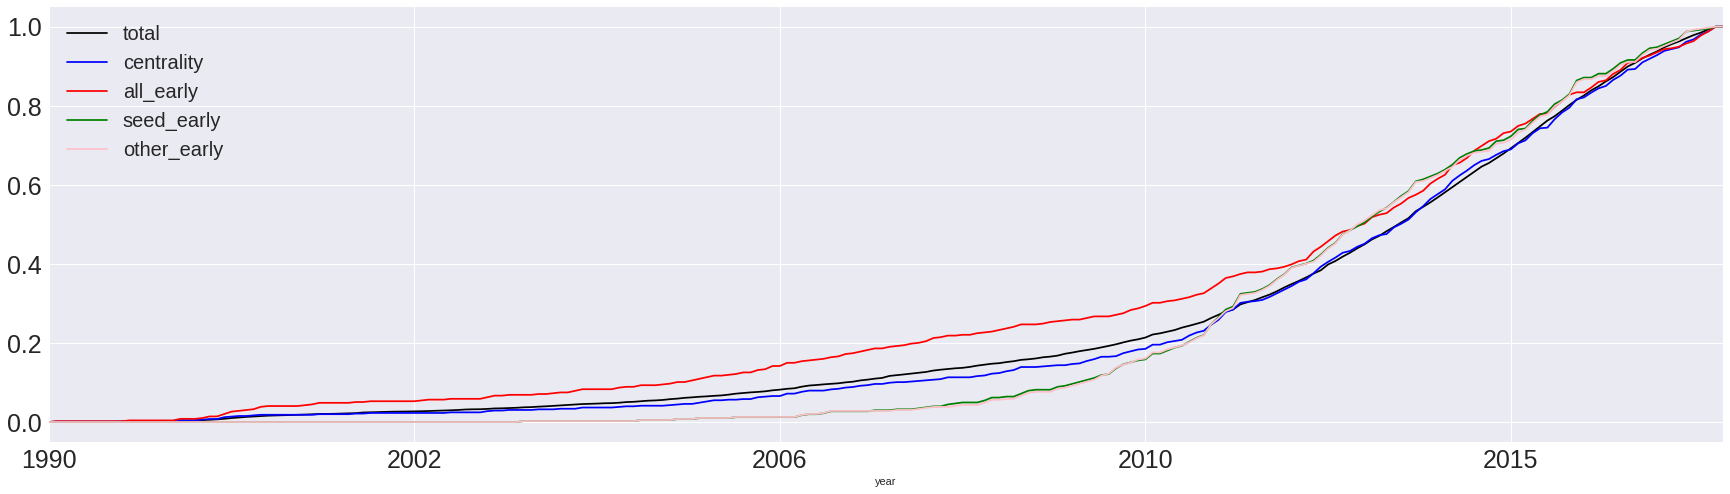

Category: advertising
# investment by all VC 4872
# investment by top VC 407
# investment by expert VC 331
# investment by seed expert VC 307
# investment by other expert VC 314


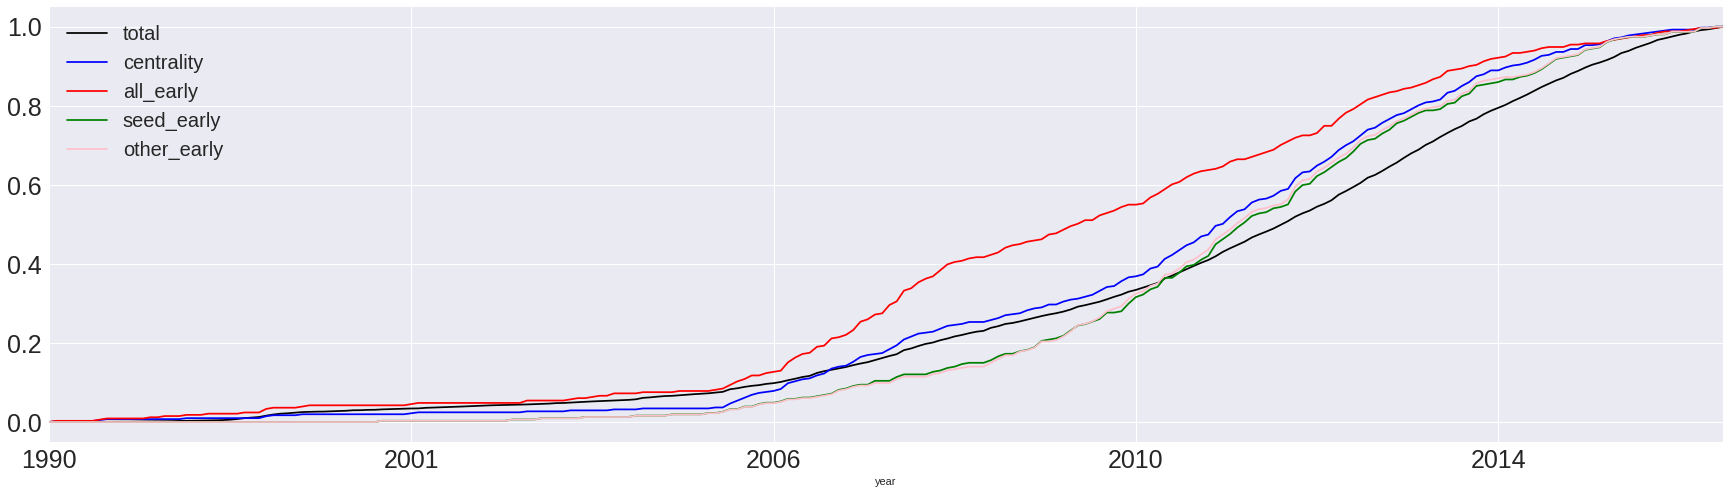

Category: manufacturing
# investment by all VC 4829
# investment by top VC 392
# investment by expert VC 534
# investment by seed expert VC 119
# investment by other expert VC 110


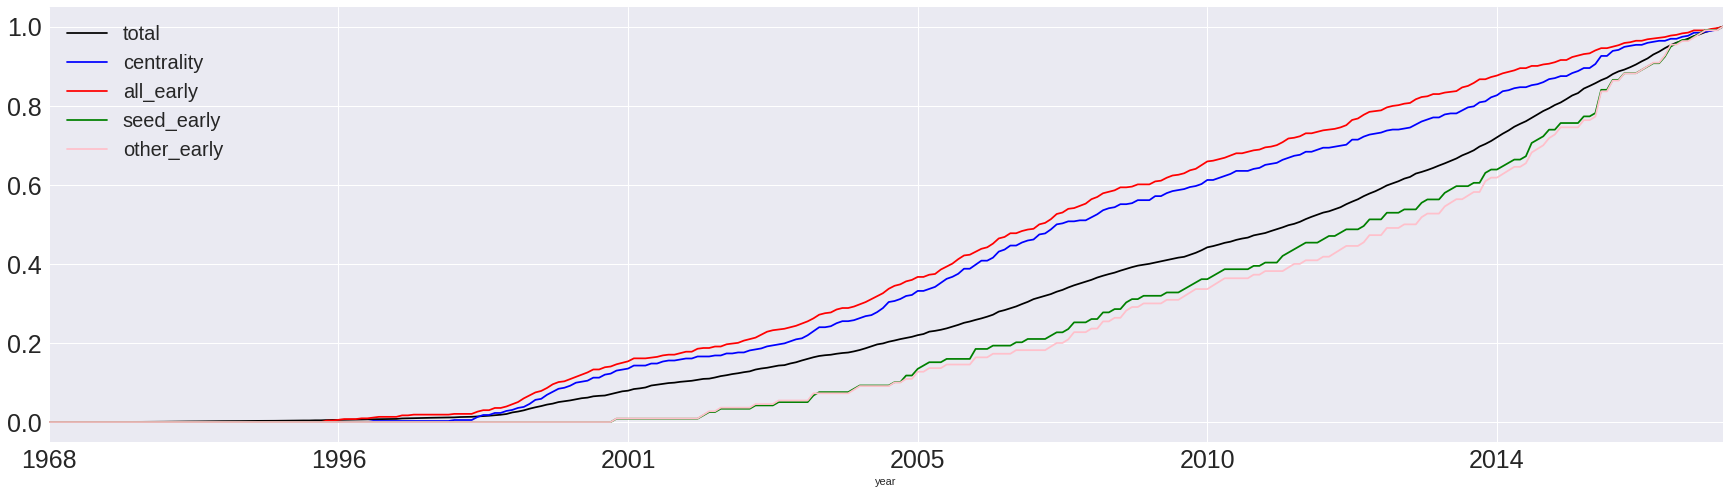

Category: medical
# investment by all VC 4767
# investment by top VC 246
# investment by expert VC 215
# investment by seed expert VC 147
# investment by other expert VC 156


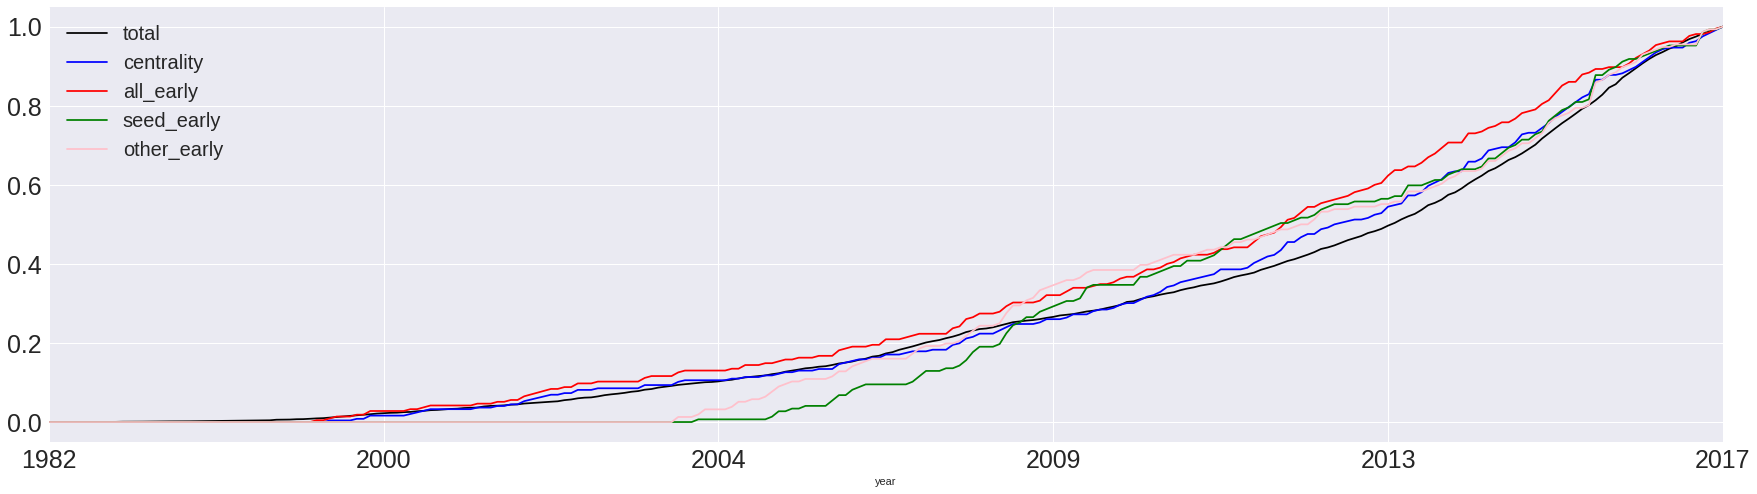

Category: apps
# investment by all VC 4493
# investment by top VC 496
# investment by expert VC 276
# investment by seed expert VC 334
# investment by other expert VC 329


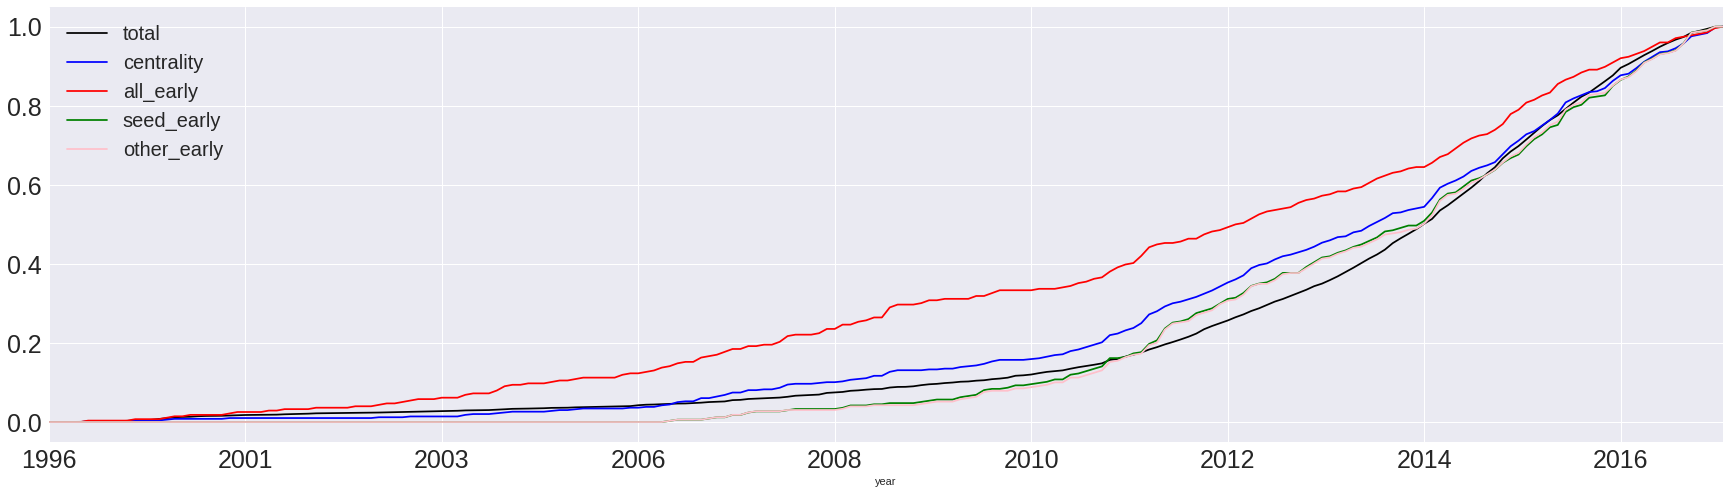

Category: social media
# investment by all VC 4357
# investment by top VC 392
# investment by expert VC 251
# investment by seed expert VC 301
# investment by other expert VC 295


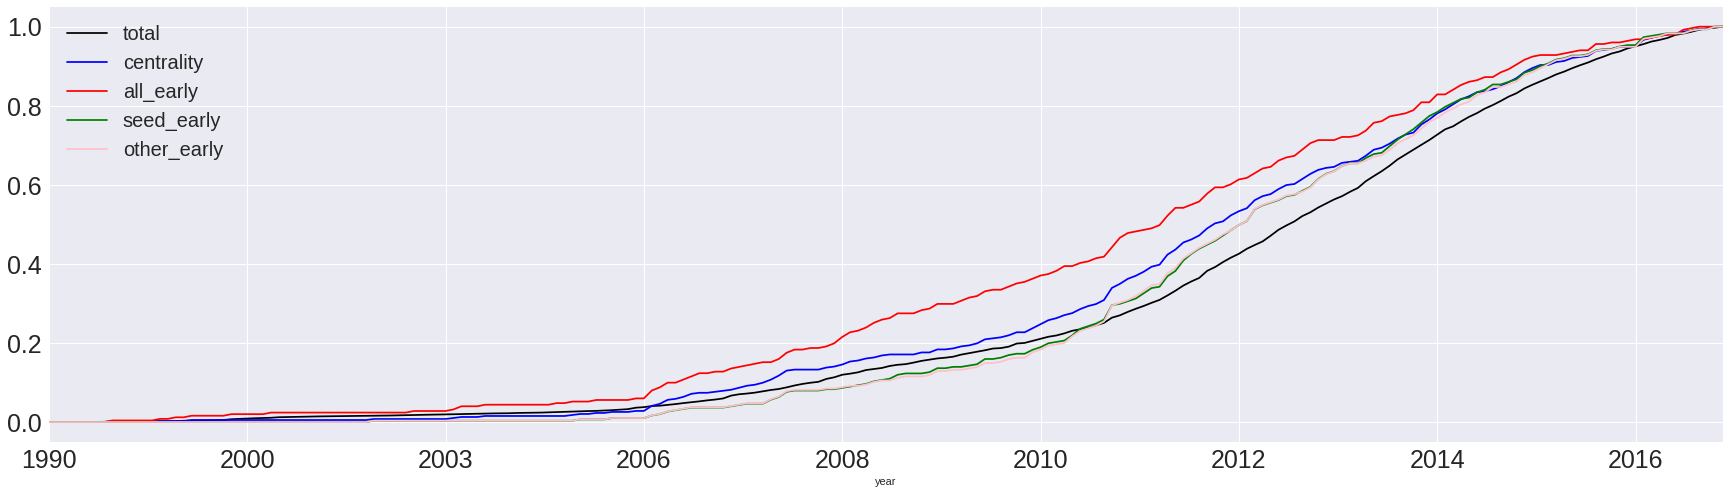

Category: education
# investment by all VC 3717
# investment by top VC 281
# investment by expert VC 147
# investment by seed expert VC 239
# investment by other expert VC 241


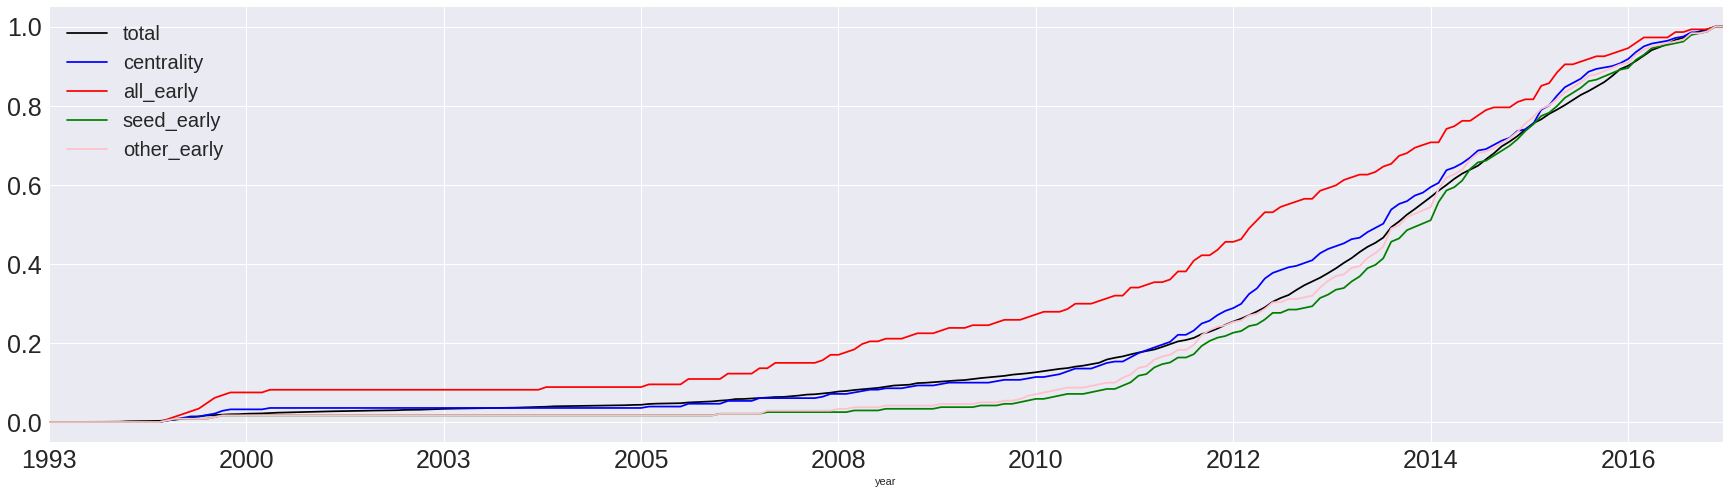

Category: finance
# investment by all VC 3650
# investment by top VC 288
# investment by expert VC 199
# investment by seed expert VC 366
# investment by other expert VC 349


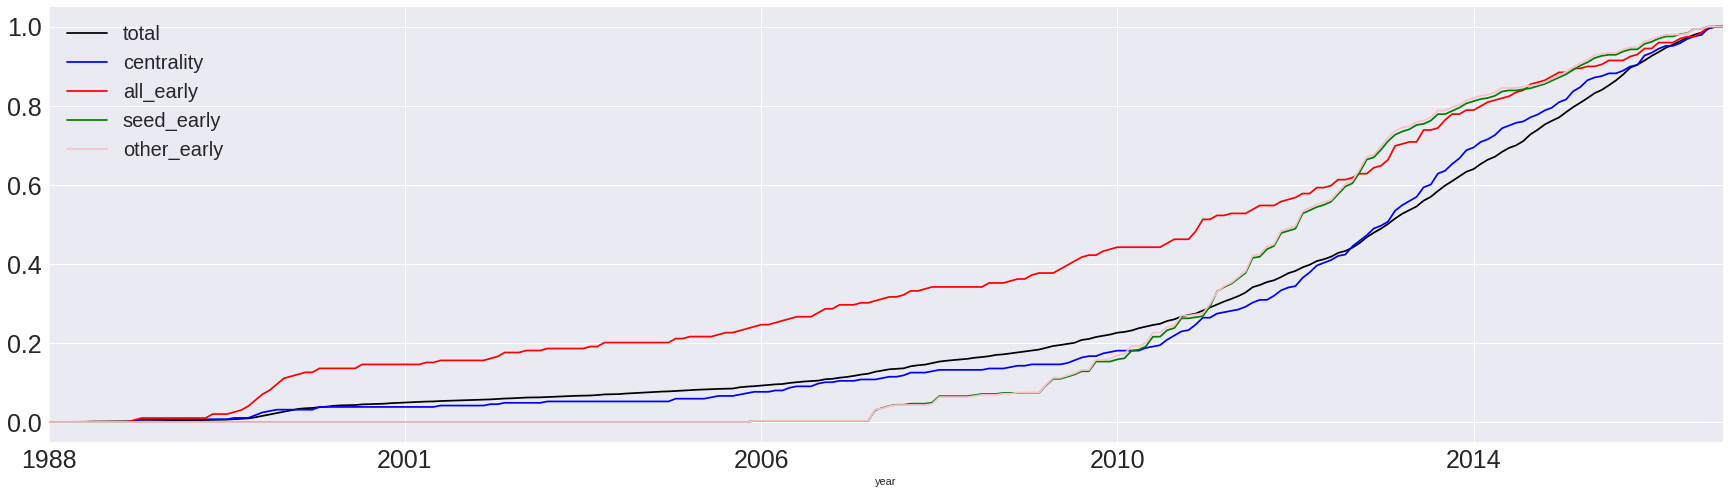

Category: big data
# investment by all VC 3482
# investment by top VC 406
# investment by expert VC 280
# investment by seed expert VC 232
# investment by other expert VC 223


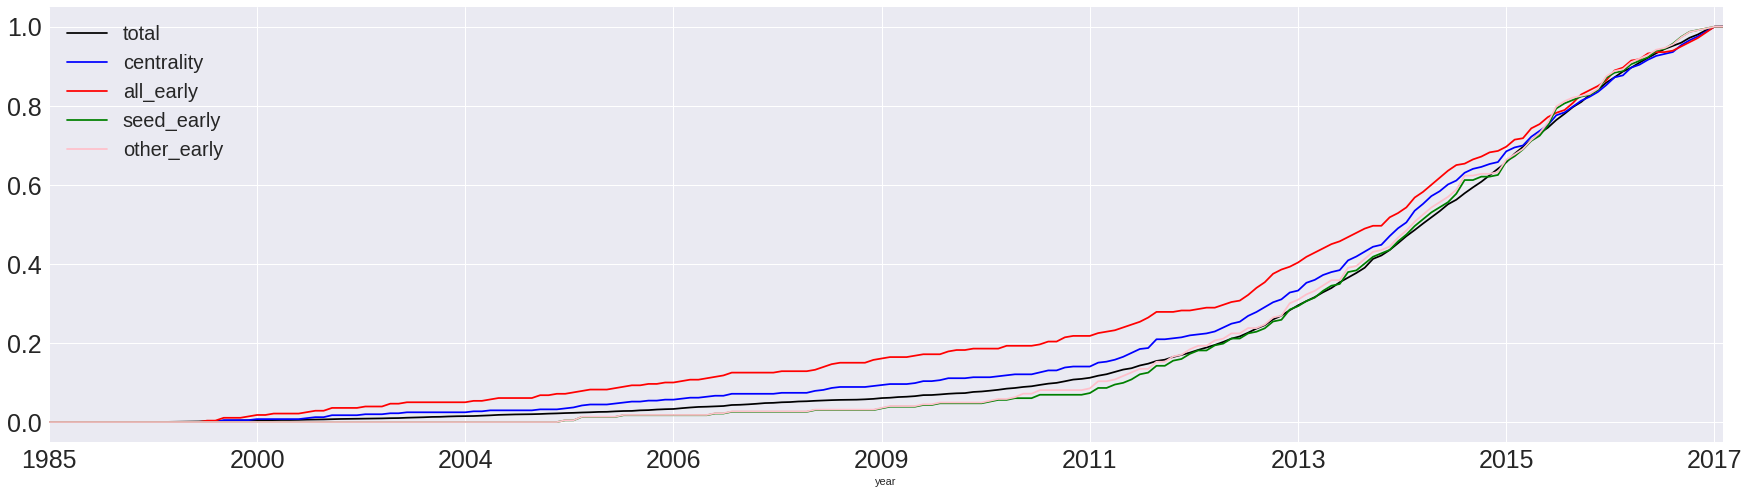

Category: fintech
# investment by all VC 3348
# investment by top VC 332
# investment by expert VC 209
# investment by seed expert VC 272
# investment by other expert VC 262


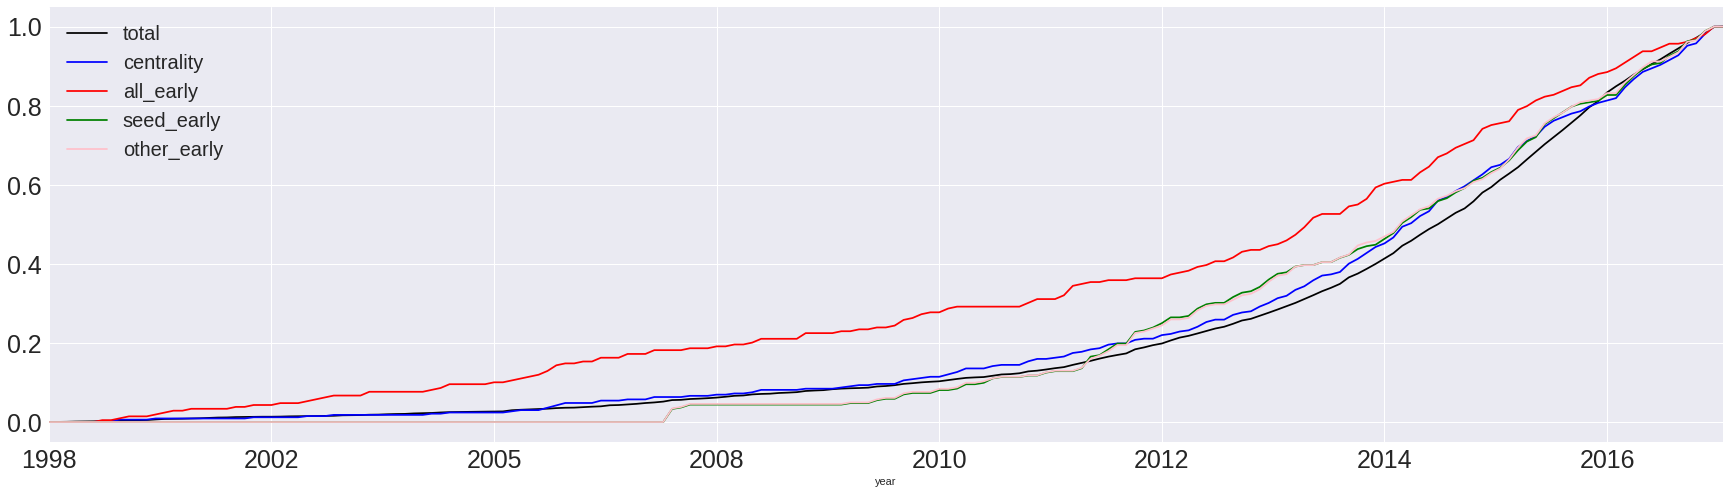

Category: hardware
# investment by all VC 3257
# investment by top VC 305
# investment by expert VC 298
# investment by seed expert VC 177
# investment by other expert VC 167


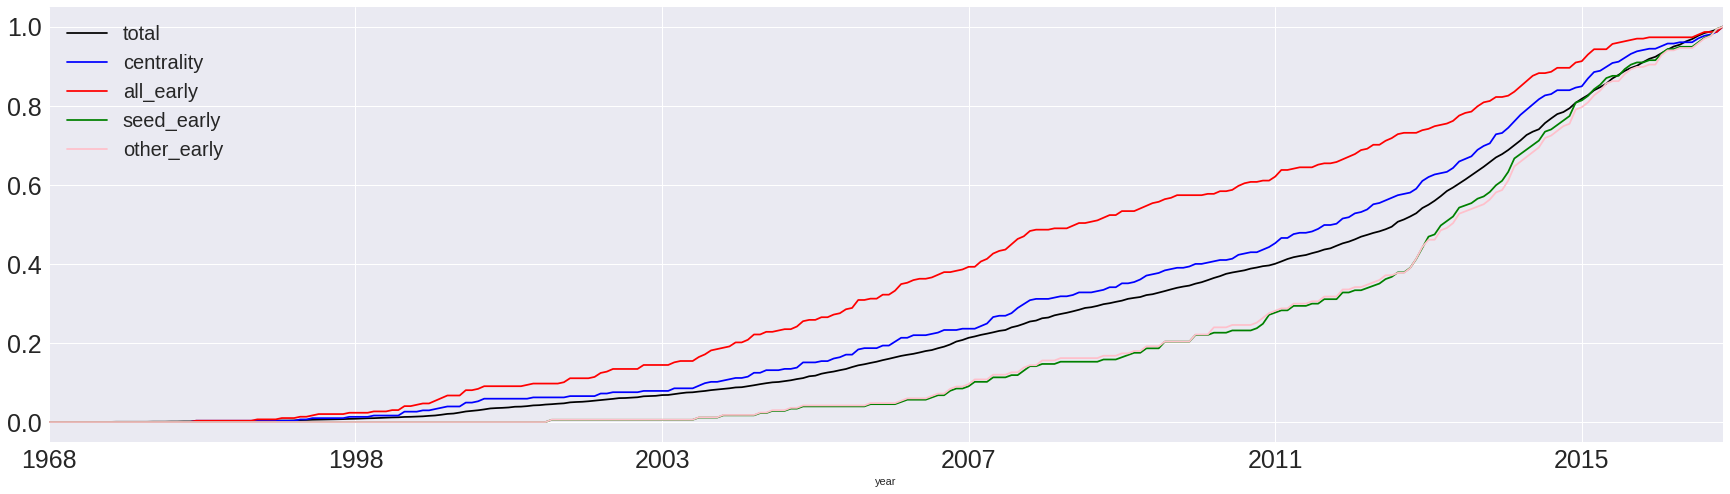

Category: financial services
# investment by all VC 3200
# investment by top VC 276
# investment by expert VC 203
# investment by seed expert VC 167
# investment by other expert VC 152


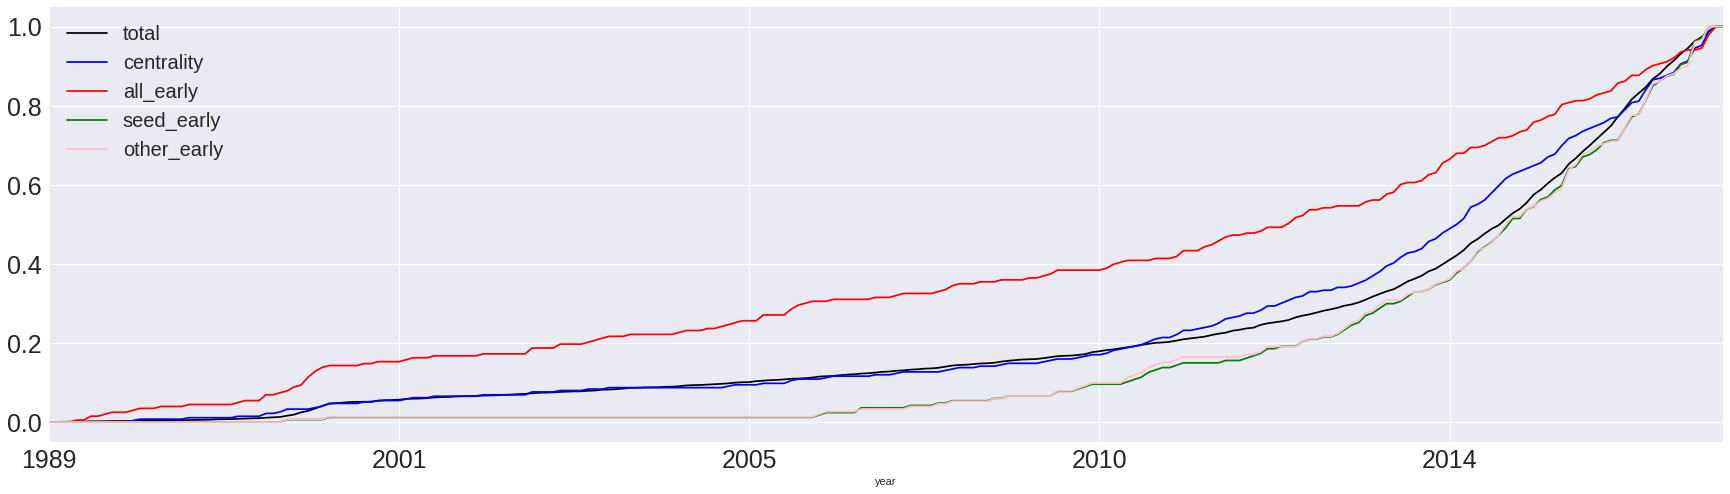

Category: medical device
# investment by all VC 3113
# investment by top VC 187
# investment by expert VC 189
# investment by seed expert VC 85
# investment by other expert VC 74


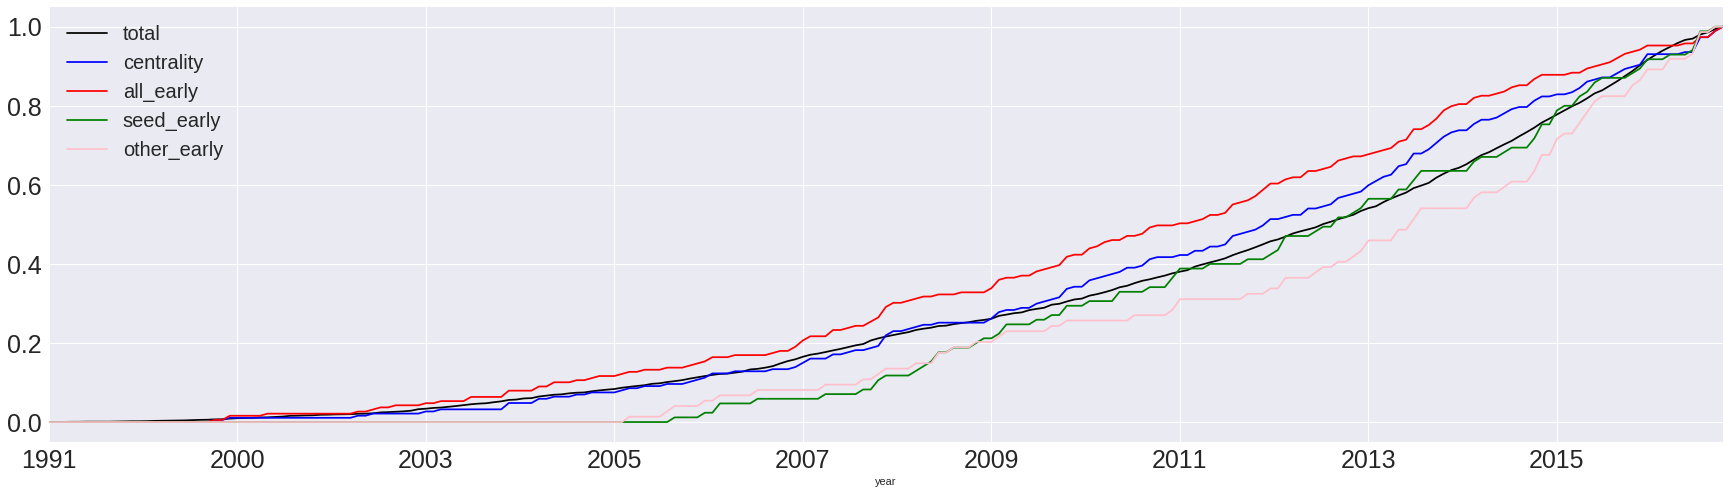

Category: security
# investment by all VC 2877
# investment by top VC 347
# investment by expert VC 374
# investment by seed expert VC 99
# investment by other expert VC 105


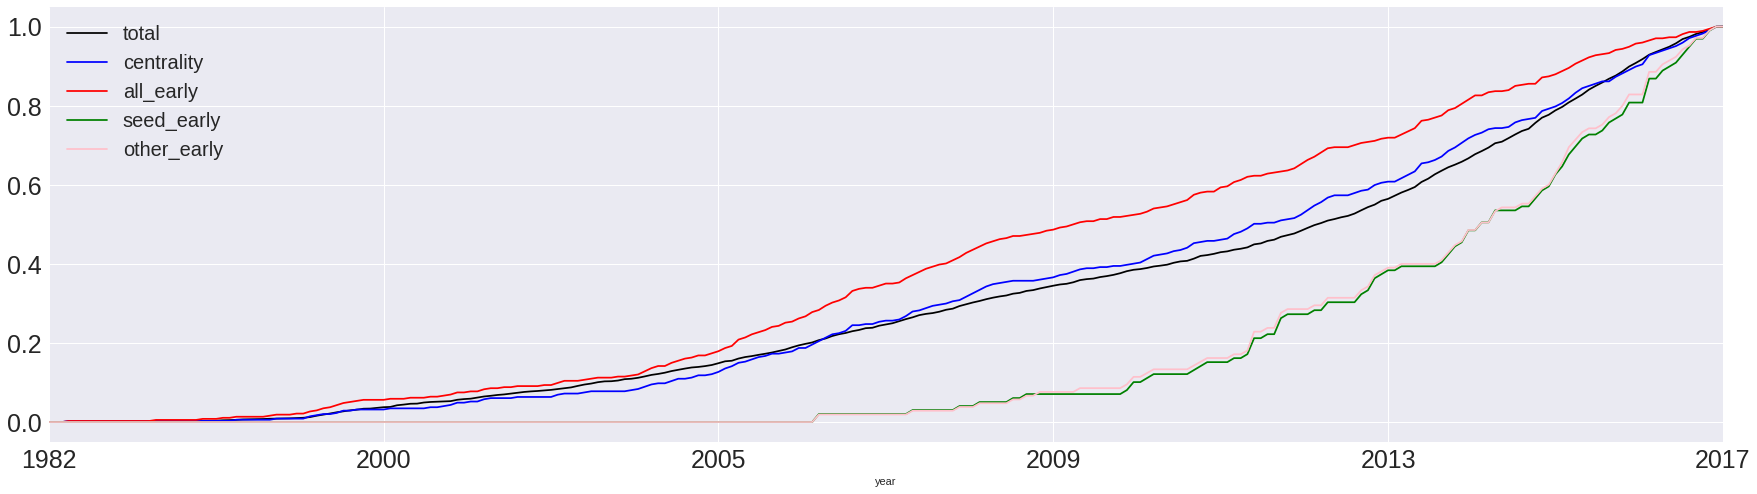

Category: cloud computing
# investment by all VC 2782
# investment by top VC 371
# investment by expert VC 355
# investment by seed expert VC 139
# investment by other expert VC 139


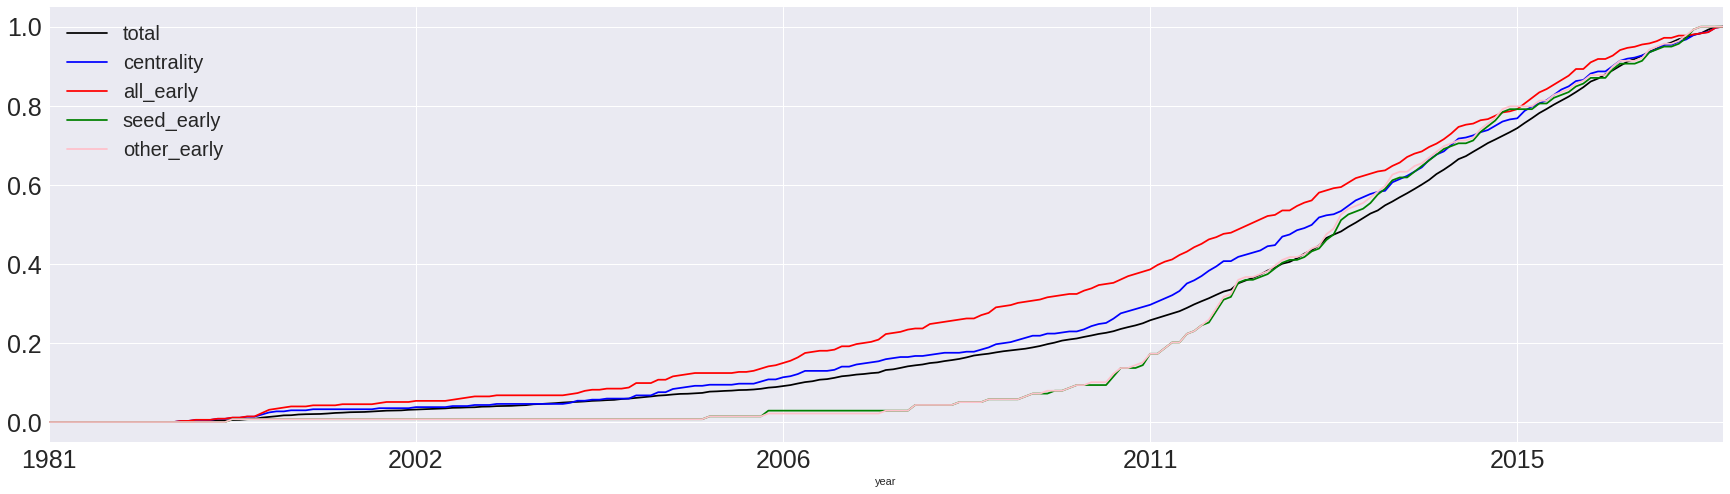

Category: video
# investment by all VC 2703
# investment by top VC 293
# investment by expert VC 229
# investment by seed expert VC 180
# investment by other expert VC 168


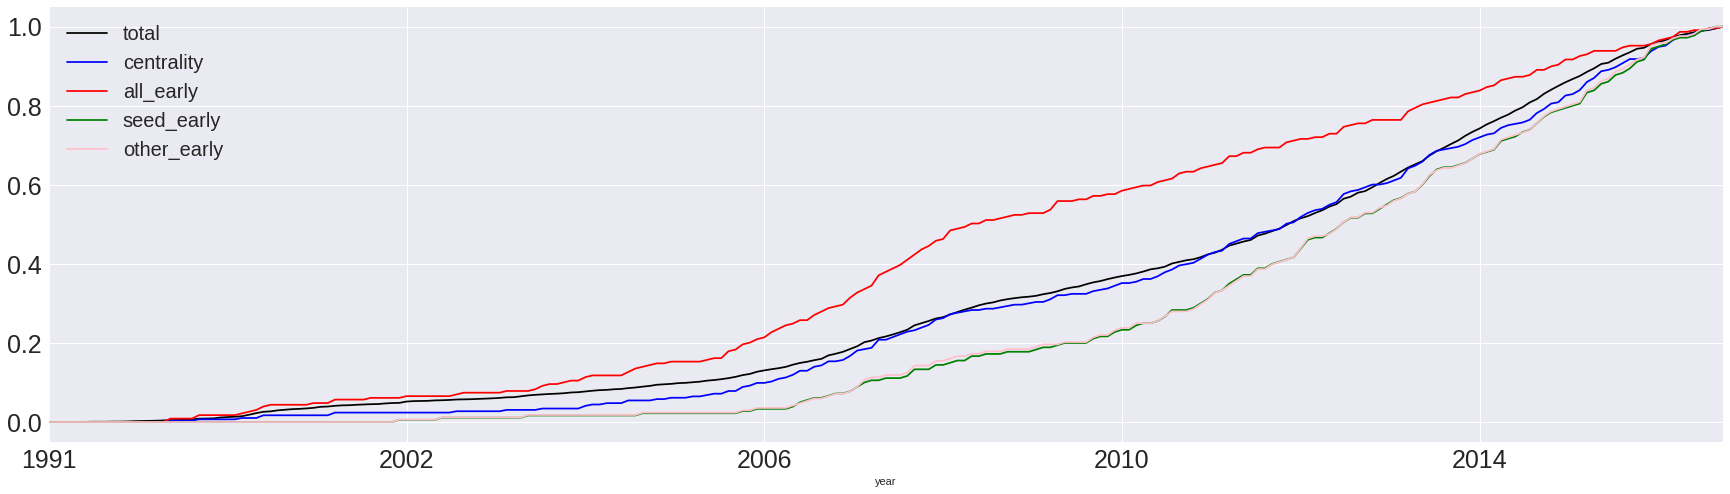

Category: retail
# investment by all VC 2509
# investment by top VC 230
# investment by expert VC 180
# investment by seed expert VC 132
# investment by other expert VC 135


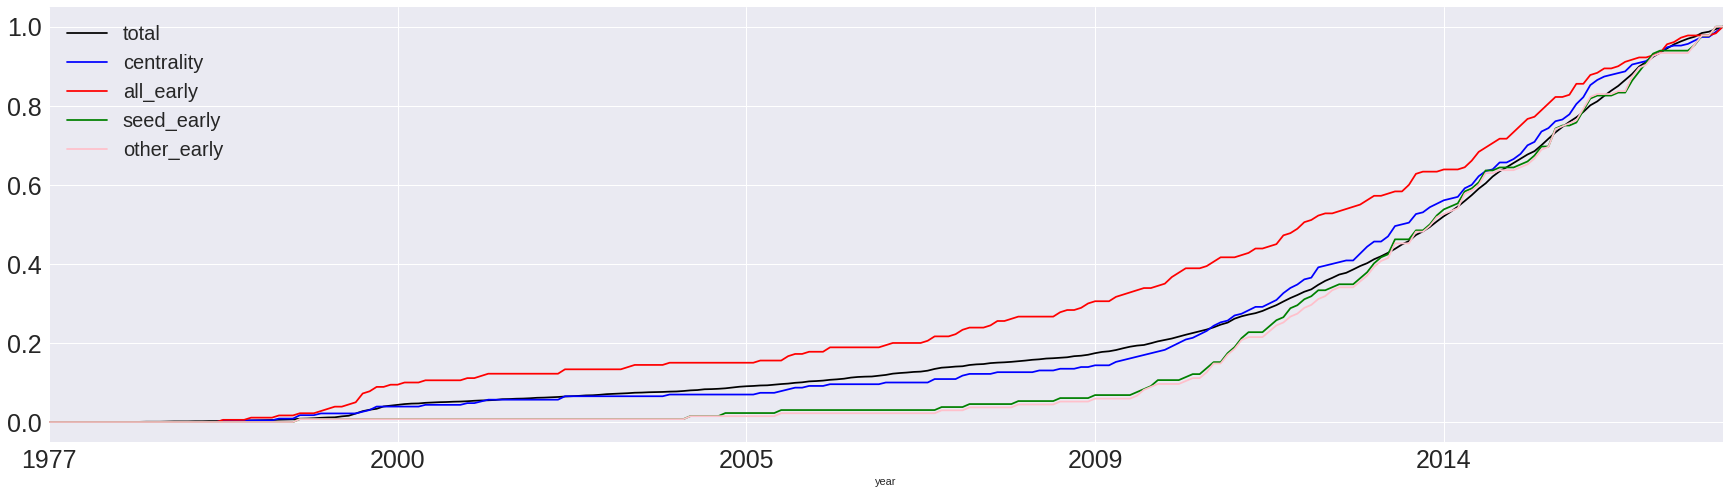

Category: telecommunications
# investment by all VC 2406
# investment by top VC 305
# investment by expert VC 353
# investment by seed expert VC 51
# investment by other expert VC 50


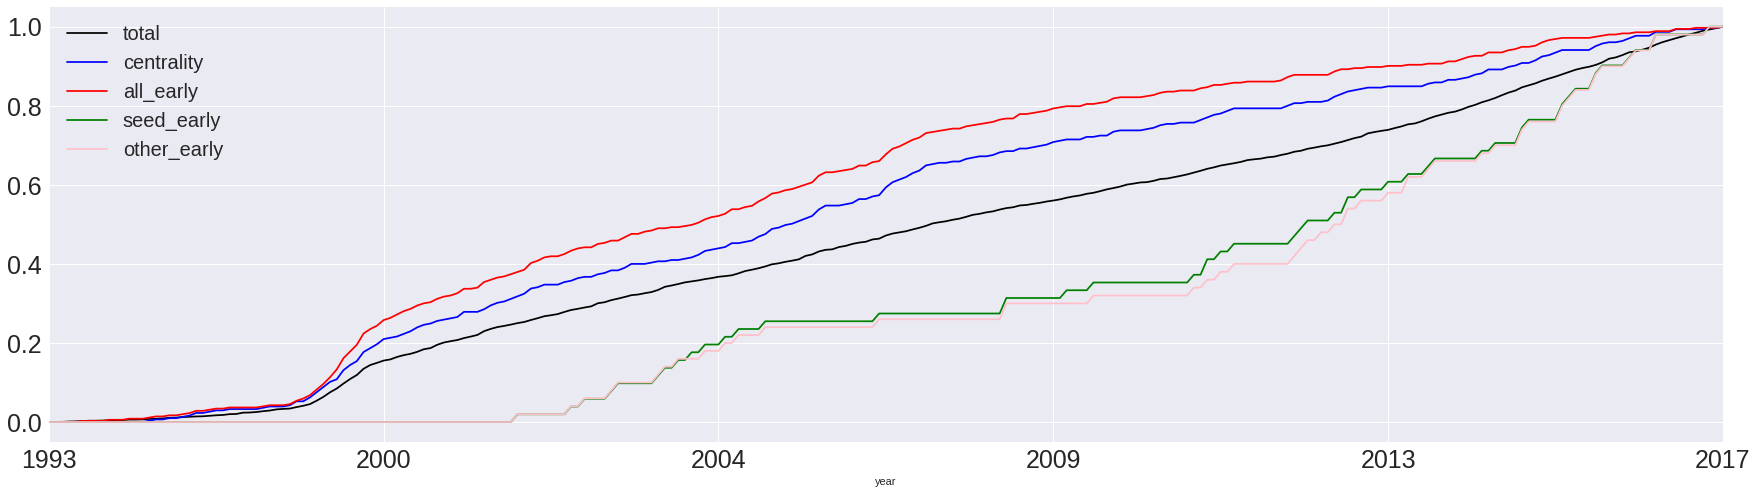

Category: wireless
# investment by all VC 2317
# investment by top VC 284
# investment by expert VC 340
# investment by seed expert VC 49
# investment by other expert VC 44


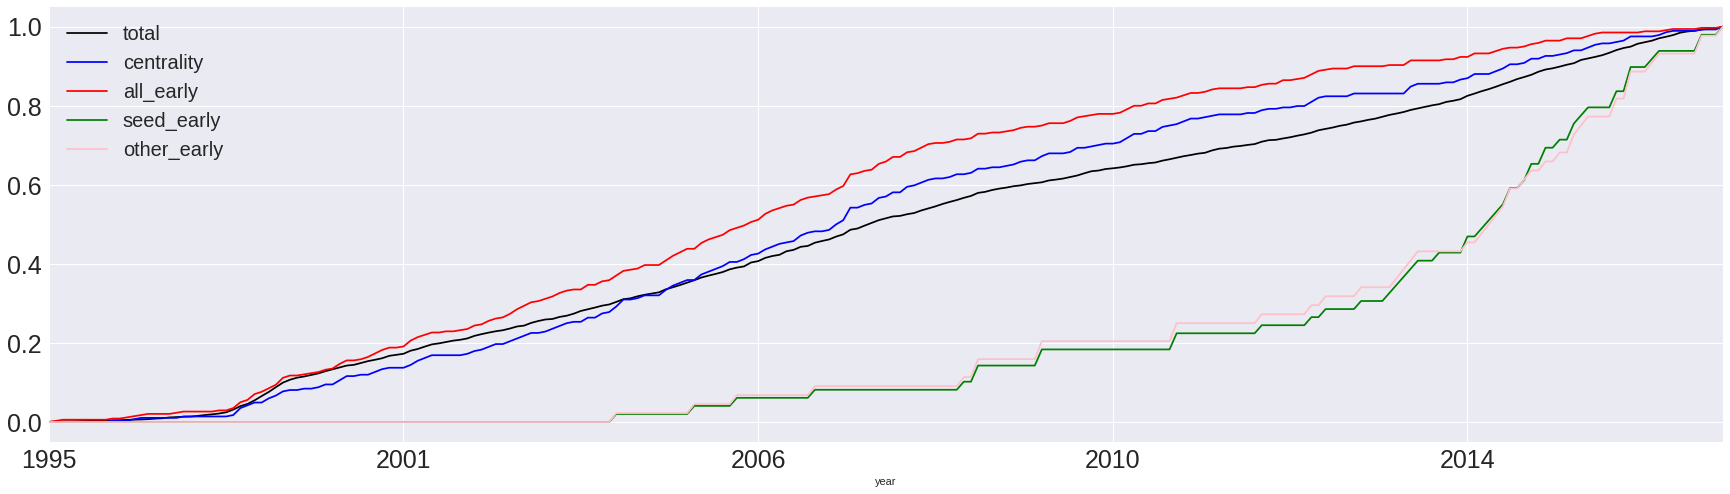

Category: travel
# investment by all VC 2249
# investment by top VC 187
# investment by expert VC 106
# investment by seed expert VC 138
# investment by other expert VC 138


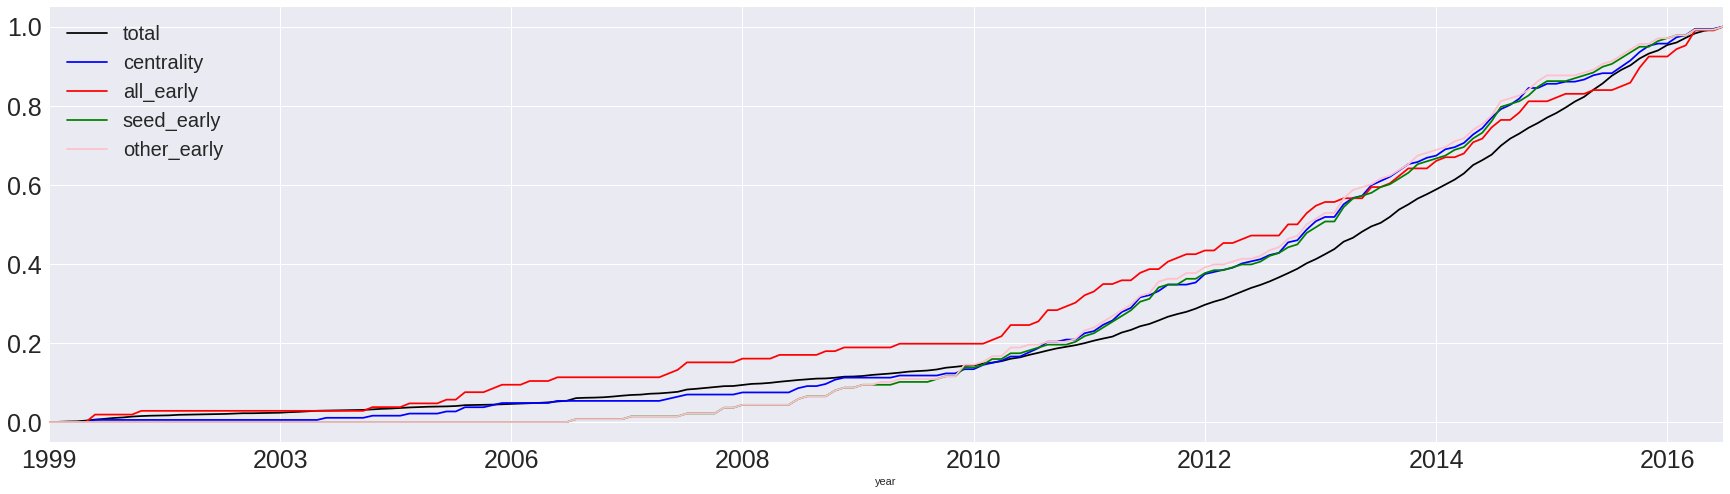

Category: pharmaceutical
# investment by all VC 2217
# investment by top VC 119
# investment by expert VC 113
# investment by seed expert VC 28
# investment by other expert VC 88


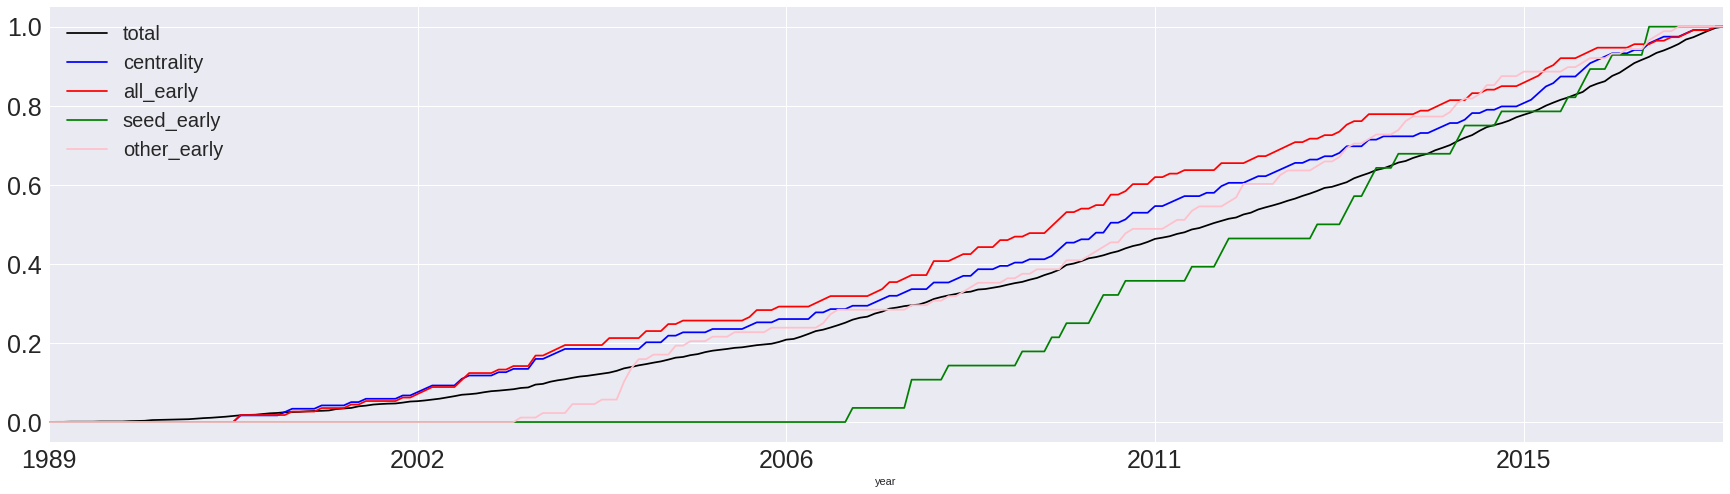

In [55]:
for category in df_category_count['category'].head(30).values:
    plot_early_investors(category = category, weight_scheme = 'log', TOP_K = 10, verbose = False)

['deep_learning']
Category: deep_learning
# investment by all VC 196
# investment by top VC 33
# investment by expert VC 13
# investment by seed expert VC 22
# investment by other expert VC 20


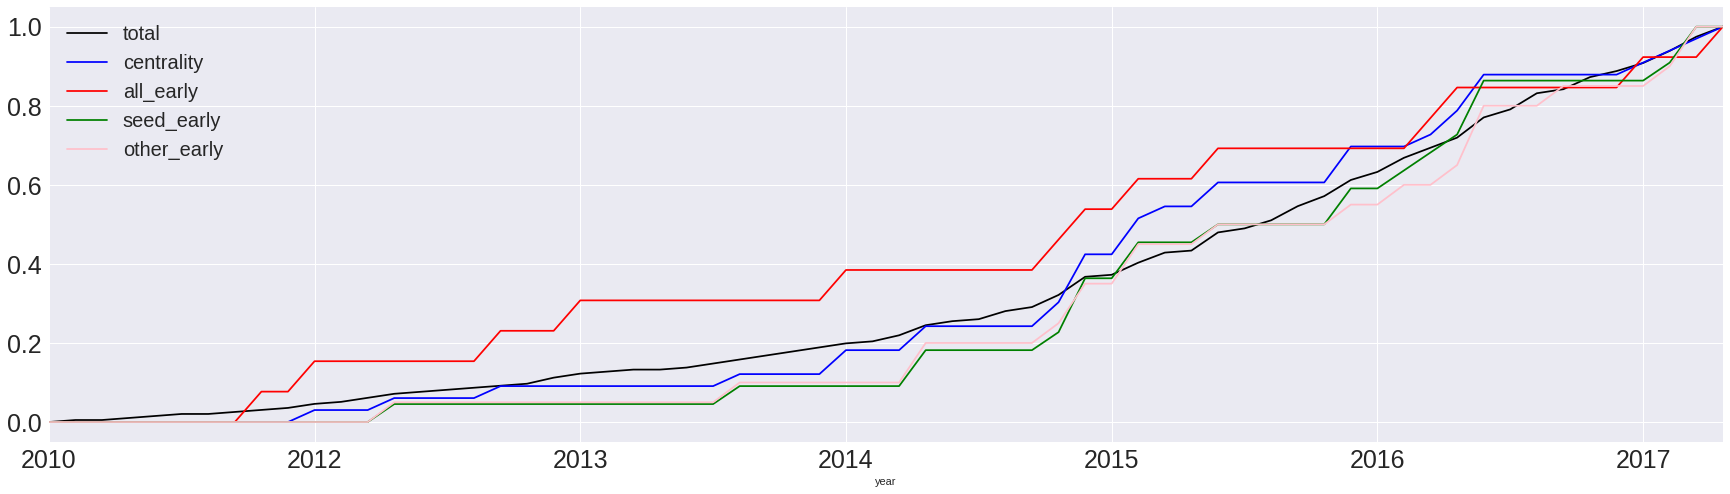

['neural_network', 'computer_vision', 'big_data', 'ai', 'reinforcement_learning', 'cognitive_computing', 'pattern_recognition', 'neural_networks', 'machine_learning', 'artificial_intelligence', 'deep_learning']
Category: deep_learning
# investment by all VC 4162
# investment by top VC 698
# investment by expert VC 527
# investment by seed expert VC 465
# investment by other expert VC 503


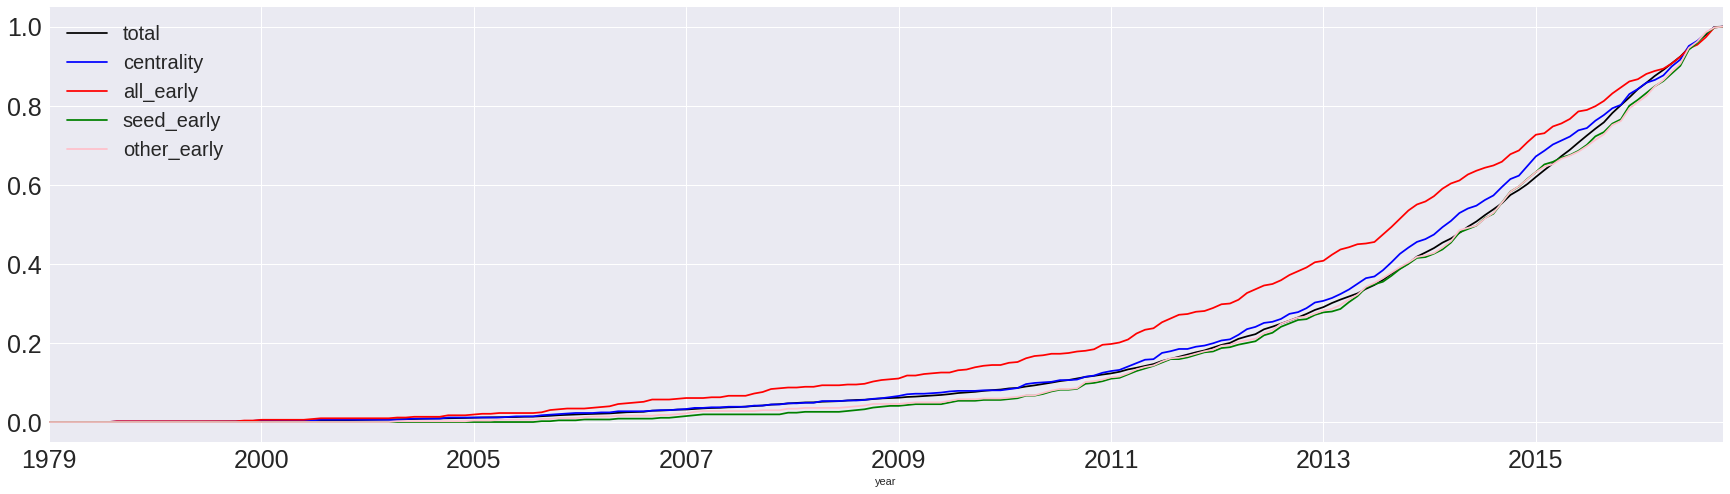

['fintech']
Category: fintech
# investment by all VC 268
# investment by top VC 37
# investment by expert VC 8
# investment by seed expert VC 31
# investment by other expert VC 29


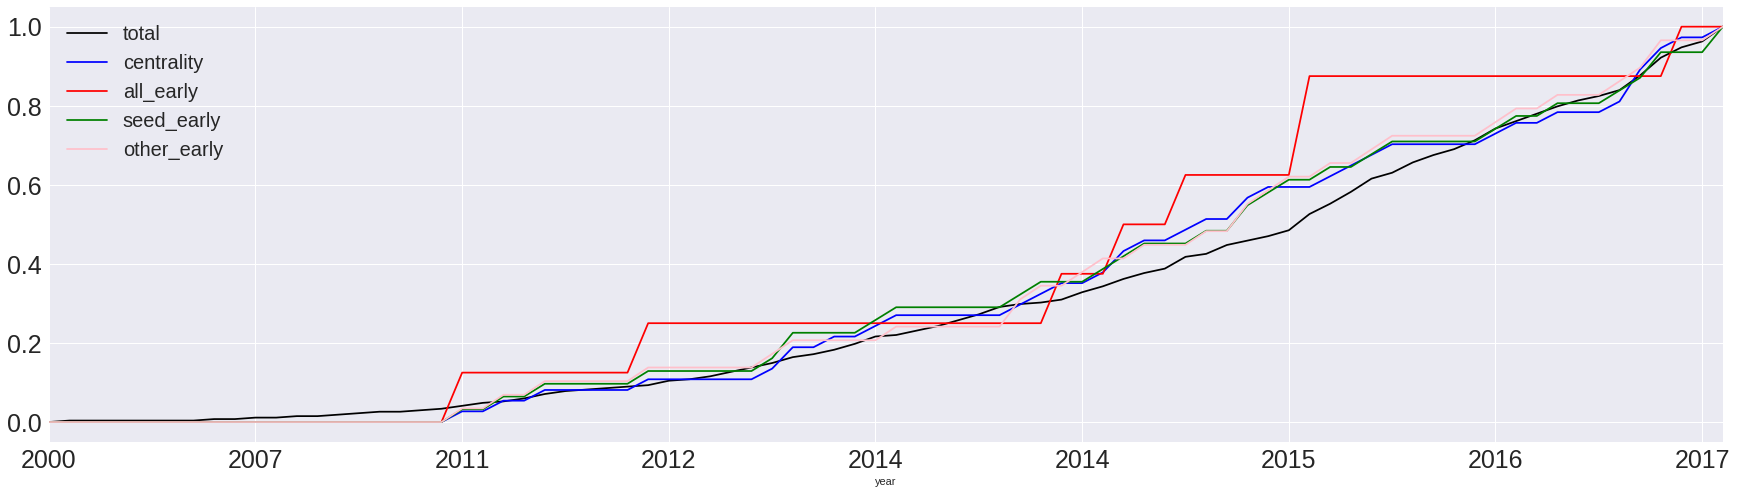

['agtech', 'fintech', 'regtech', 'insurtech', 'edtech', 'cleantech', 'tech', 'fin_tech', 'ad_tech', 'healthtech', 'adtech']
Category: fintech
# investment by all VC 1904
# investment by top VC 257
# investment by expert VC 134
# investment by seed expert VC 233
# investment by other expert VC 246


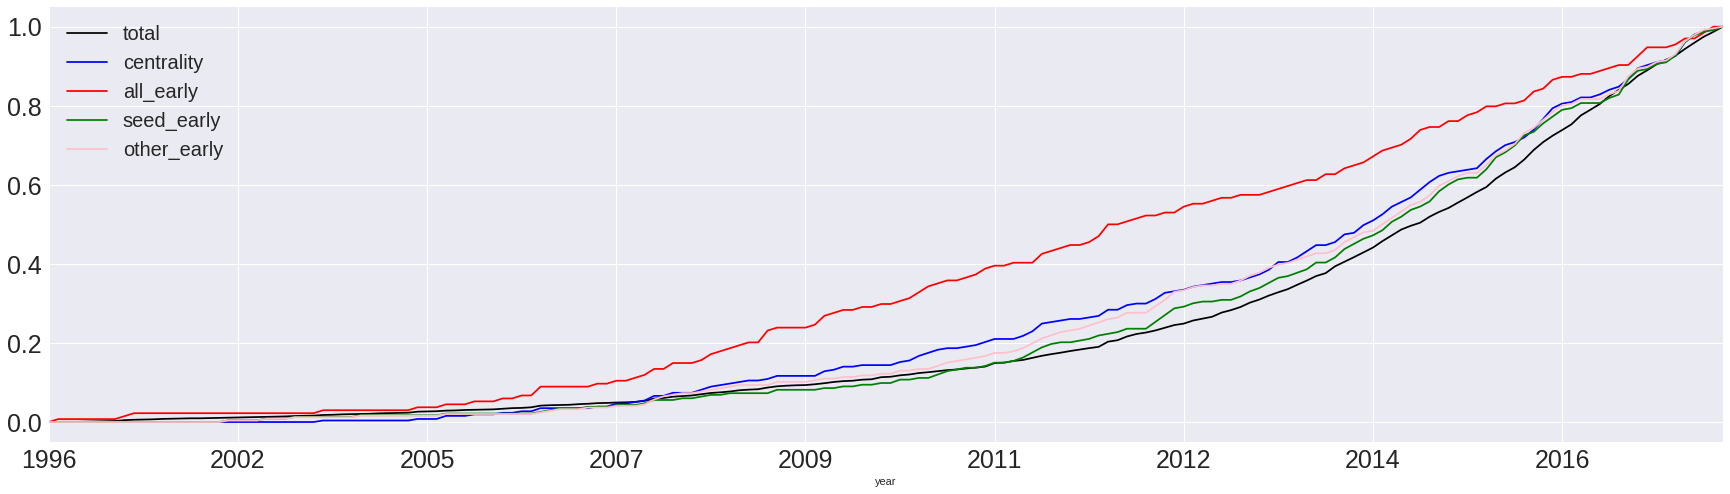

['drone']
Category: drone
# investment by all VC 180
# investment by top VC 31
# investment by expert VC 14
# investment by seed expert VC 34
# investment by other expert VC 34


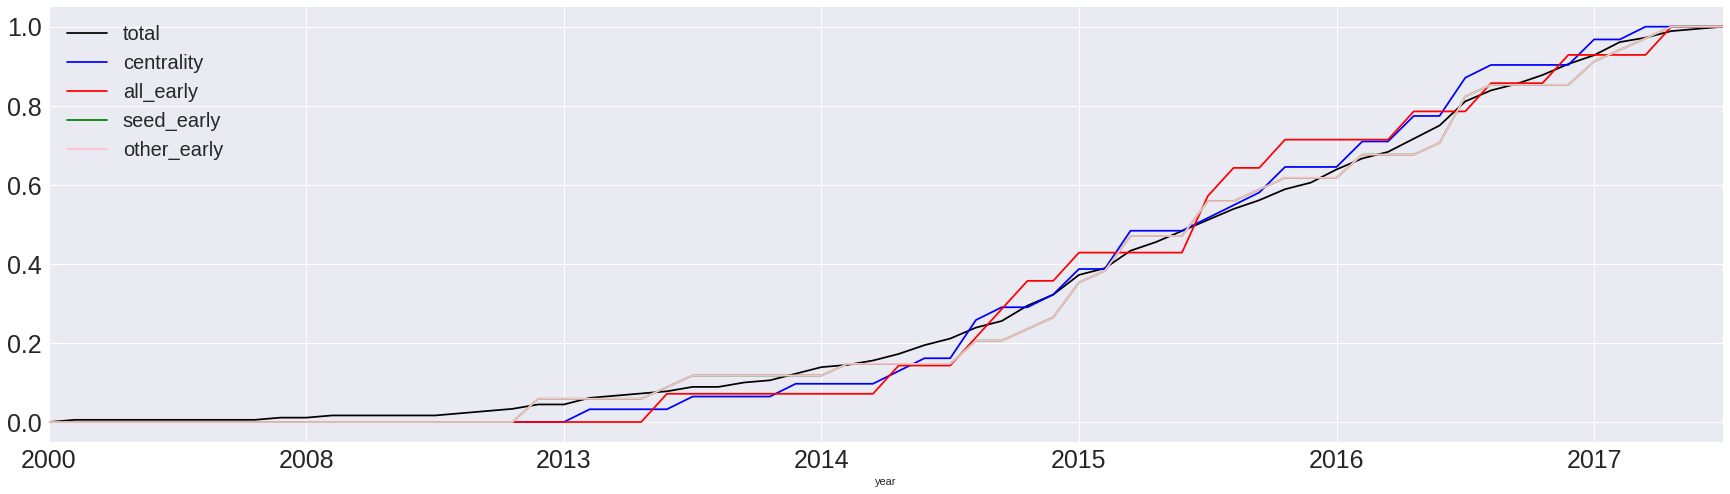

['remotely_operated', 'drone', 'uas', 'unmanned_aerial', 'uav', 'unmanned', 'uavs', 'drones', 'unmanned_aircraft', 'vtol', 'fixed_wing']
Category: drone
# investment by all VC 363
# investment by top VC 63
# investment by expert VC 43
# investment by seed expert VC 50
# investment by other expert VC 52


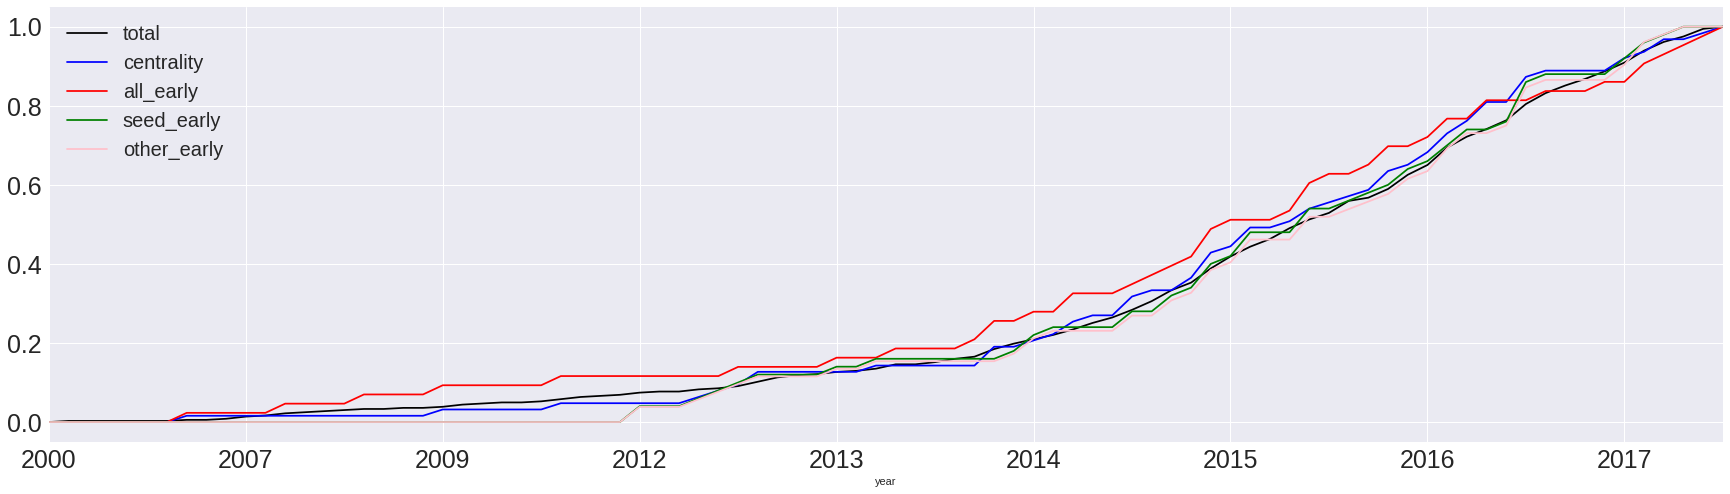

['wearable']
Category: wearable
# investment by all VC 337
# investment by top VC 23
# investment by expert VC 16
# investment by seed expert VC 25
# investment by other expert VC 27


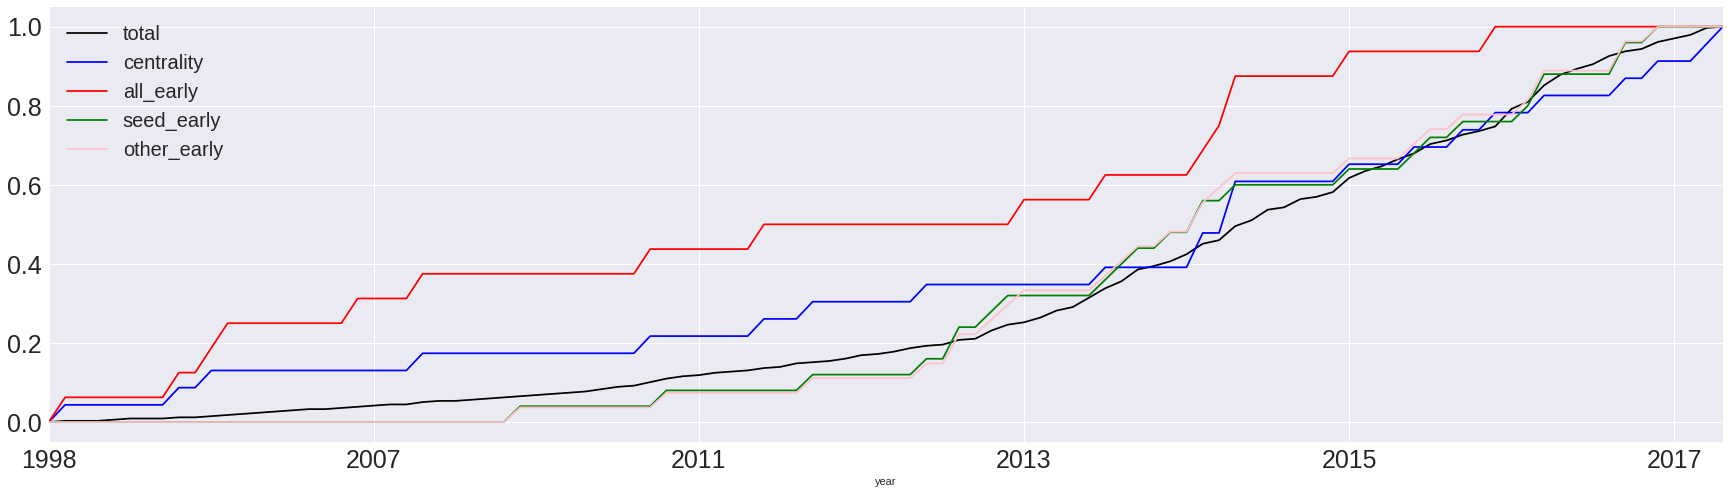

['wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wearable', 'wrist_worn', 'bluetooth_smart', 'wearable_devices', 'sensor', 'wearable_tech', 'wearable_technology']
Category: wearable
# investment by all VC 1473
# investment by top VC 171
# investment by expert VC 142
# investment by seed expert VC 139
# investment by other expert VC 149


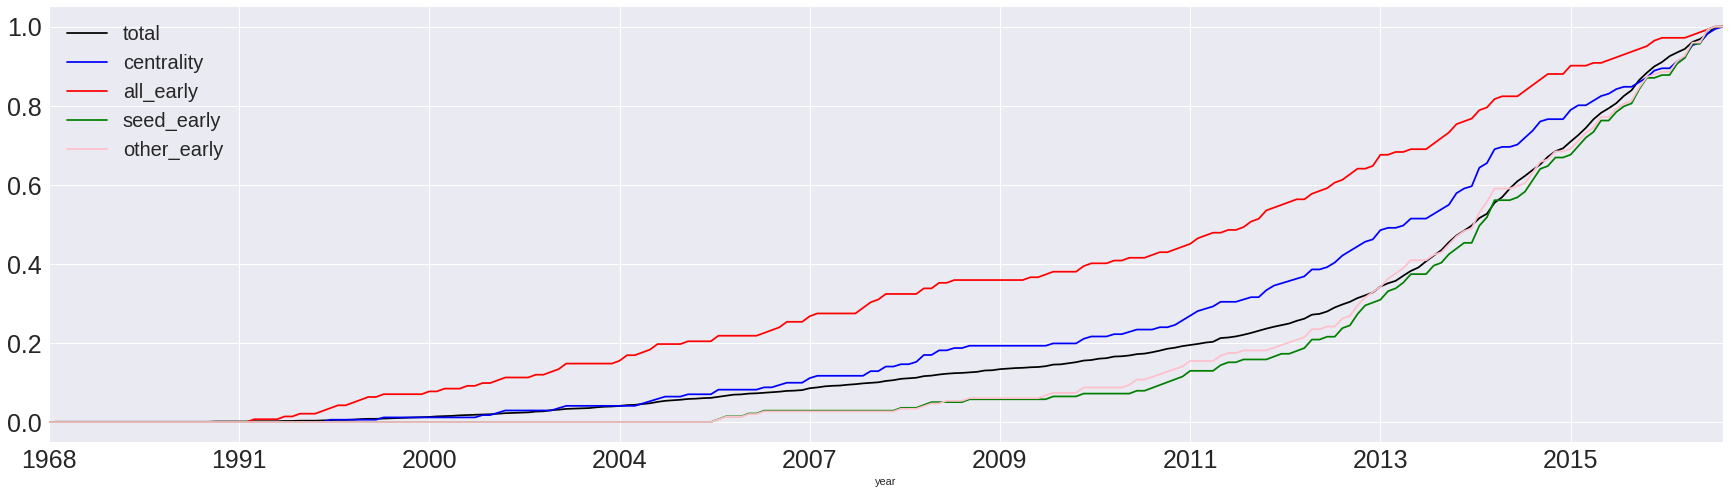

['3d_printing']
Category: 3d printing
# investment by all VC 0
# investment by top VC 0
# investment by expert VC 0
# investment by seed expert VC 0
# investment by other expert VC 0
no data
[]
Category: 3d printing
# investment by all VC 0
# investment by top VC 0
# investment by expert VC 0
# investment by seed expert VC 0
# investment by other expert VC 0
no data
['virtual_reality']
Category: virtual reality
# investment by all VC 310
# investment by top VC 53
# investment by expert VC 33
# investment by seed expert VC 29
# investment by other expert VC 29


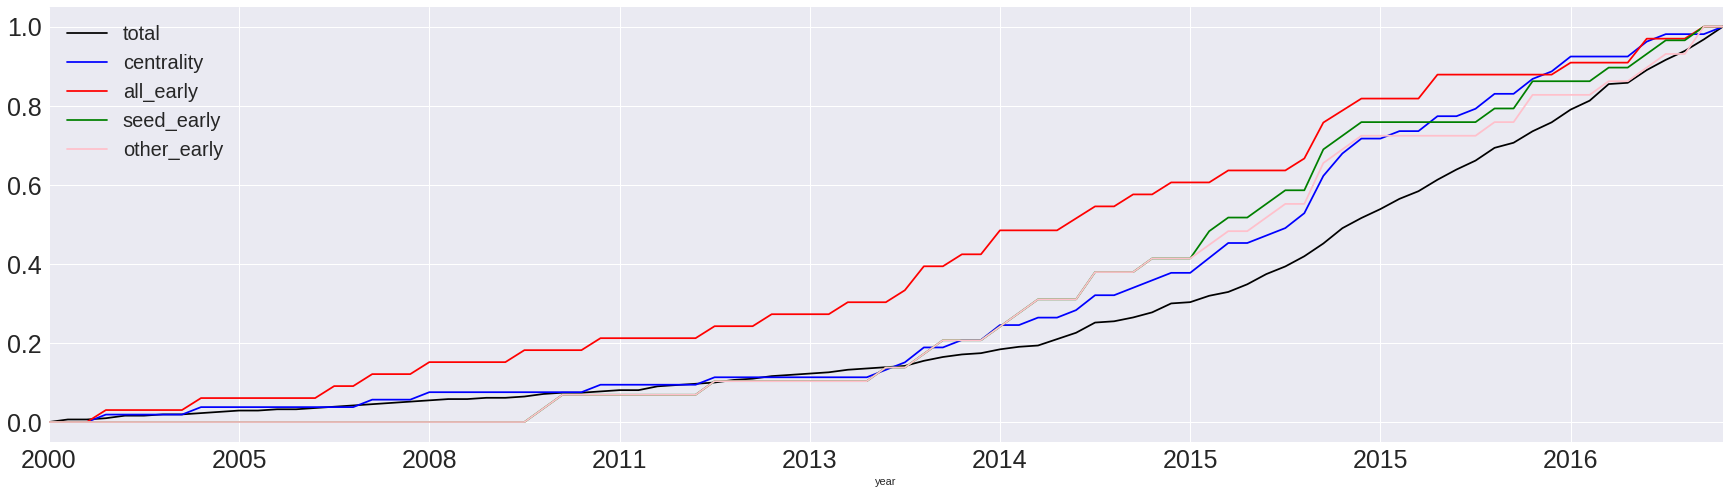

['ar_vr', 'htc_vive', 'virtual_reality', 'cinematic_vr', 'augmented_reality', 'vr_ar', 'vr', 'ar', 'immersive', 'oculus_rift', 'mixed_reality']
Category: virtual reality
# investment by all VC 981
# investment by top VC 160
# investment by expert VC 98
# investment by seed expert VC 102
# investment by other expert VC 104


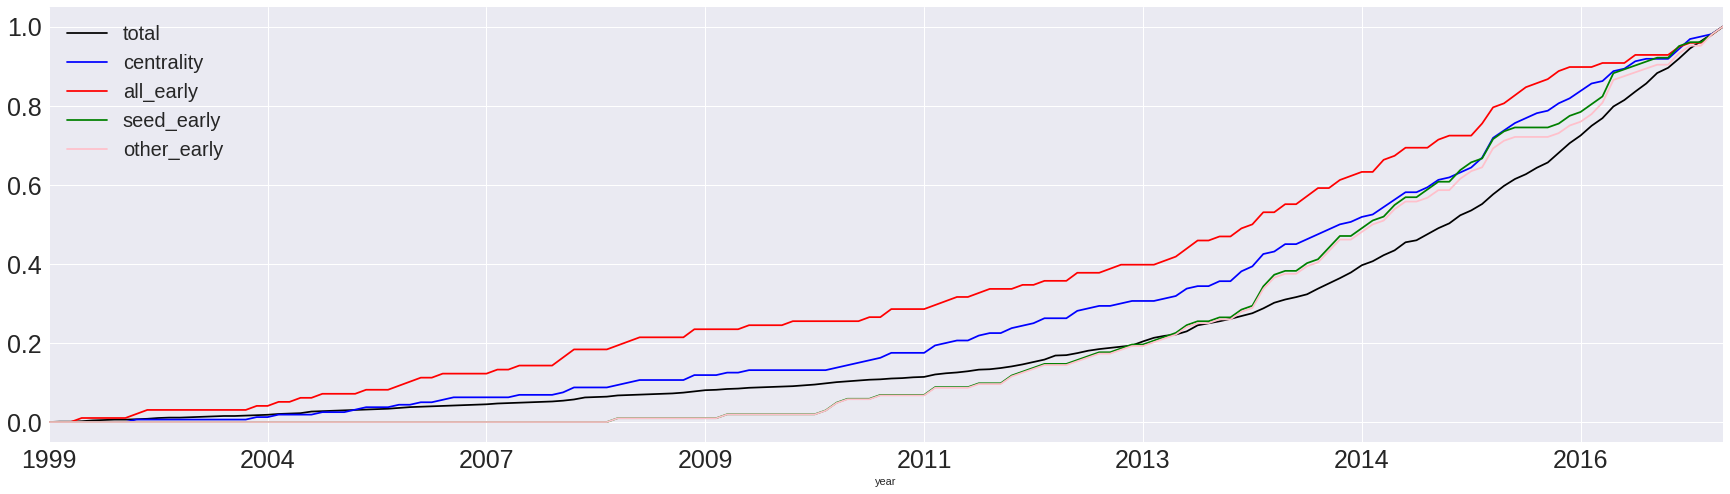

In [56]:
word_list = ['deep_learning', 'fintech', 'drone', 'wearable', '3d printing', 'virtual reality']
for word in word_list:
    plot_early_investors(category = word, weight_scheme = 'log', TOP_K = 30, verbose = False, this_is_word = True, expand = False)
    plot_early_investors(category = word, weight_scheme = 'log', TOP_K = 30, verbose = False, this_is_word = True, expand = True)